In [2]:
import numpy as np
import matplotlib.pyplot as plt


def qdot( state, params ):
    return state[:,2:4]


def pdot(state, params):
    positions = state[:, 0:2]
    L = params[0]  #length scale of potential
    F = params[1]  #Strength of the force
    rij = positions[np.newaxis, :, :] - positions[:, np.newaxis, :]
    
    #shift as needed
    mask = np.abs(rij) > 0.5
    rij[mask] = rij[mask] - np.sign(rij[mask])
    
    #rij now has the closest contributions
    #rij_0 = np.copy(rij)
    force = 0; #get force in scope. This value is not used
    #for i in np.arange(-1,2,1):
    #    for j in np.arange(-1,2,1):
    #        rij = np.copy(rij_0)
    #        rij[:,:,0] = rij[:,:,0] + i
    #        rij[:,:,1] = rij[:,:,1] + j
    #
    #        dsq = np.linalg.norm(rij, axis=2)**2
    #        dsq = np.stack([dsq, dsq], axis=2)
    #        force = force + F*(rij/L)*np.exp(-dsq/2/(L**2))
    
    dsq = np.linalg.norm(rij, axis=2)**2
    dsq = np.stack([dsq, dsq], axis=2)
    force = force + F*(rij/L)*np.exp(-dsq/2/(L**2))
    
    v = np.sum(force, axis=0)

    return v
   
    
def fix_state(state):
    N = np.size(state,0)
    for i in np.arange(0,N,1):
        for j in np.arange(0,2,1):
            if state[i,j] > 1:
                state[i,j] = state[i,j] - 1
            if state[i,j] < 0:
                state[i,j] = state[i,j] + 1
    return state


def symplectic_step( state, h, params ):
    # This is a symplectic integration preserving the area of phase space exactly
    # I want to try a rather agressive scheme from Yoshida's 1990 paper 
    # "Construction of higher order dymplectic integrators"
    # This will contain Solution A of the sixth order integrators (Table 1)
    
    # The idea is to define S^(m)(t) = ... S_2(w_2 t) S_2(w_1 t) S_2(w_0 t) S_2(w_1 t) S(w_2 t) ...
    # S_2 is the leapfrog scheme 
    
    
    w1 = -0.117767998417887E1
    w2 =  0.235573213359357E0
    w3 =  0.7845136104775E0
    
    w0 =  1 - 2*(w1+w2+w3) #from equation 5.18
    
    c = np.zeros(8)
    d = np.zeros(7)
    
    #always taking a mix of half-steps in q-space
    c[0] =  w3    /2
    c[1] = (w3+w2)/2
    c[2] = (w2+w1)/2
    c[3] = (w1+w0)/2
    c[4] = (w0+w1)/2
    c[5] = (w1+w2)/2
    c[6] = (w2+w3)/2
    c[7] =  w3    /2
    
    #full steps in p-space
    d[0] = w3
    d[1] = w2
    d[2] = w1
    d[3] = w0
    d[4] = w1
    d[5] = w2
    d[6] = w3
    
    for i in np.arange(0,7,1):
        state[:,0:2] = state[:,0:2] + c[i]*h*qdot(state, params)
        state = fix_state(state)
        state[:,2:4] = state[:,2:4] + d[i]*h*pdot(state, params)
    #take final step in q
    state[:,0:2] = state[:,0:2] + c[7]*h*qdot(state, params)
    state = fix_state(state)
    
    return state

    
    

def kinetic_and_potential_energy(state):
    #kinetic energy T
    T = np.sum( np.square( state[:,2:4] ) )/2
    
    N = np.size(state, 0) #number of particles
    
    positions = state[:, 0:2]
    L = params[0]  #length scale of potential
    F = params[1]  #Strength of the force
    rij = positions[np.newaxis, :, :] - positions[:, np.newaxis, :]
    
    #shift as needed
    mask = np.abs(rij[:,:,0])>0.5
    rij[mask,0] = rij[mask,0] - np.sign(rij[mask,0])
    mask = np.abs(rij[:,:,1])>0.5
    rij[mask,1] = rij[mask,1] - np.sign(rij[mask,1])
    
    dsq = np.linalg.norm(rij, axis=2)**2
    pot = F*L*np.exp(-dsq/(L**2)/2)
    
    #Potential energy. Divide by two because we double count
    V = np.sum(pot) # sum individual contributions
    V = V - N*F*L   # subtract the self-interaction
    V = V/2         # divide by 2 because we double counted
    
    return T, V

In [7]:
#%%prun

N = 256 #number of particles

L_ave = 1/np.sqrt(N)

I1 =  0.1  # v^2/(LF) ratio of kinetic energy to characteristic interaction energy
I2 =  0.3  # L/L_0    how many particles you expect to interact with in each direction

V = 1 #initial velocity will be this scale
F = V*V/I1/I2/L_ave
L = I2*L_ave

time_scale = np.sqrt(L/F) #time scale of particle interactions

params = np.array( [L, F] )

every = 4   #take this many timesteps before saving to array
M     = 512 #saved timesteps

T = 3*64*time_scale
h = T/M/every

traj  = np.zeros( [N,4,M] )
state = np.zeros( [N,4]   )

#energy values during time integration
kinetic   = np.zeros( [M,1] )
potential = np.zeros( [M,1] ) 

#random initial data
np.random.seed(0) #for reporducibility
state[:,0:2] = np.random.rand(N,2)

print("relaxing potential...")
for i in np.arange(1,128,1):
    print(i)
    for j in np.arange(0,every,1):
        state = symplectic_step( state, h, params)
    state[:,2:4] = 0

    
#state[:,2]   = V * np.sin(  4*2*np.pi*state[:,1] )
#state[:,3]   = V * np.cos(    2*np.pi*state[:,0] ) 

state[:,2]   = V * np.sin(    2*np.pi*state[:,1]  )
state[:,3]   = V * np.sin(    2*np.pi*state[:,0]  ) 

state[:,2] = state[:,2] - np.mean(state[:,2])
state[:,3] = state[:,3] - np.mean(state[:,3])

traj[:,:,0]  = state


kinetic[0], potential[0] = kinetic_and_potential_energy(state)
for i in np.arange(1,M,1):
    print(i)
    for j in np.arange(0,every,1):
        state = symplectic_step( state, h, params)
    
    traj[:,:,i] = state

    
#Save the trajectory to a file
file = f"sim_n{N}_1i{I1}_2i{I2}.npy"

pos = traj[:,0:2,:]
vels= traj[:,2:4,:]
deltat= T/M
dims = np.array([1, M])

ndata_path = 'sims/'
with open(ndata_path + file, 'wb') as out_file:
                np.save(out_file, pos)
                np.save(out_file, vels)
                np.save(out_file, deltat)
                np.save(out_file, dims)

relaxing potential...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
17

In [9]:
file = f"sim_n{N}_1i{I1}_2i{I2}.npy"

pos = traj[:,0:2,:]
vels= traj[:,2:4,:]
deltat= T/M
dims = np.array([1, M])

ndata_path = 'sims/'
with open(ndata_path + file, 'wb') as out_file:
                np.save(out_file, pos)
                np.save(out_file, vels)
                np.save(out_file, deltat)
                np.save(out_file, dims)

print(file)

sim_n1024_1i1_2i3.npy


In [ ]:
#%%prun

#The dimensionless
N       = 1024 #number of particles
v_scale = 1    #max velocity for initial data
L_ave   = 1/np.sqrt(N) #expected separation of particles for a uniform lattice

num1    = 8  #values of L_impact/L_ave
num2    = 8  #values of L/L_ave

#limits of search for invariant_1 = L_impact/L_ave
I1_min   = 0.5
I1_max   = 2

#limits of search for invariant_2 = L/L_ave
I2_min  = 0.25
I2_max  = 1

M       = 32 #number of timesteps
every   = 1
h       = 0.2/M #timestep

boxes_per_side = 6 #boxes for velocity correlation

corr = np.zeros( [num1, num2, M] )

I1s = np.linspace( I1_min, I1_max, num1 )
I2s = np.linspace( I2_min, I2_max, num2 )


state0 = np.zeros([N,4])
state0[:,0:2] = np.random.rand(N,2)
state0[:,2] = v_scale * np.sin( 2*np.pi*state0[:,1] )
state0[:,3] = v_scale * np.sin( 2*np.pi*state0[:,0] )


for idx1 in np.arange(0, num1, 1):
    for idx2 in np.arange(0, num2, 1):
        #corr[idx1,idx2,:] = idx2
        #continue
        
        print([idx1, idx2])
        
        A = v_scale**2/I1s[idx1]/L_ave
        L = I2s[idx2]*L_ave
        
        num_boxes = int(10) #boxes for computing particle interactions
        params = np.array( [L, A, num_boxes] )
        state = np.copy(state0)
        v0 = coarse_velocity( state, boxes_per_side )
        
        for i in np.arange(0,M,1):
            v = coarse_velocity( state, boxes_per_side )
            corr[idx1, idx2, i] = correlation(v,v0)
            for j in np.arange(0,every,1):
                state = symplectic_step( state, h/every, params) 

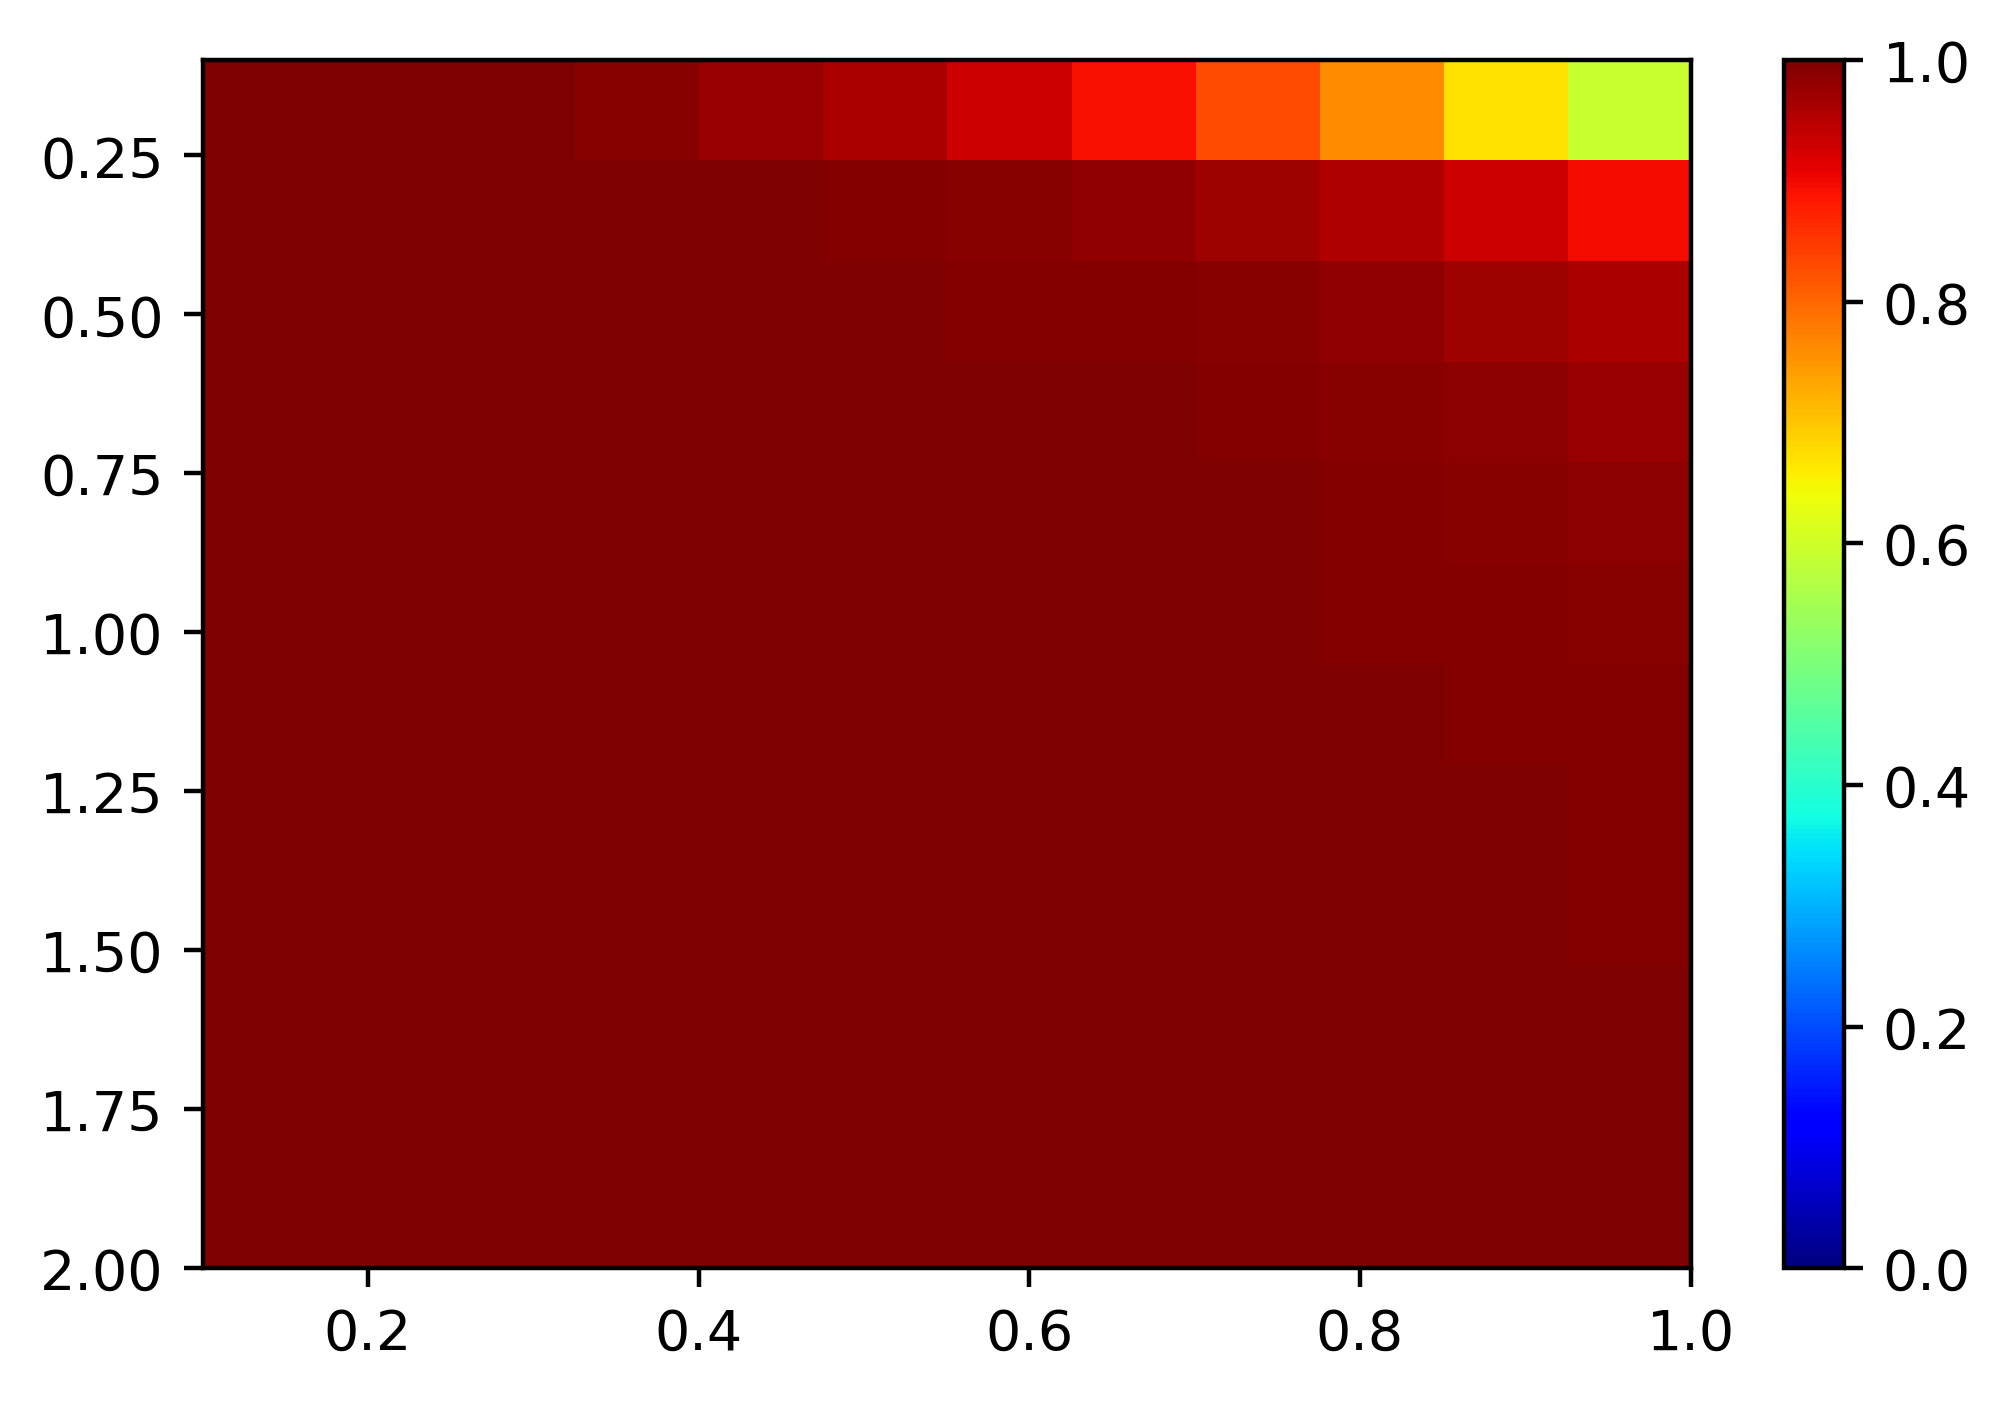

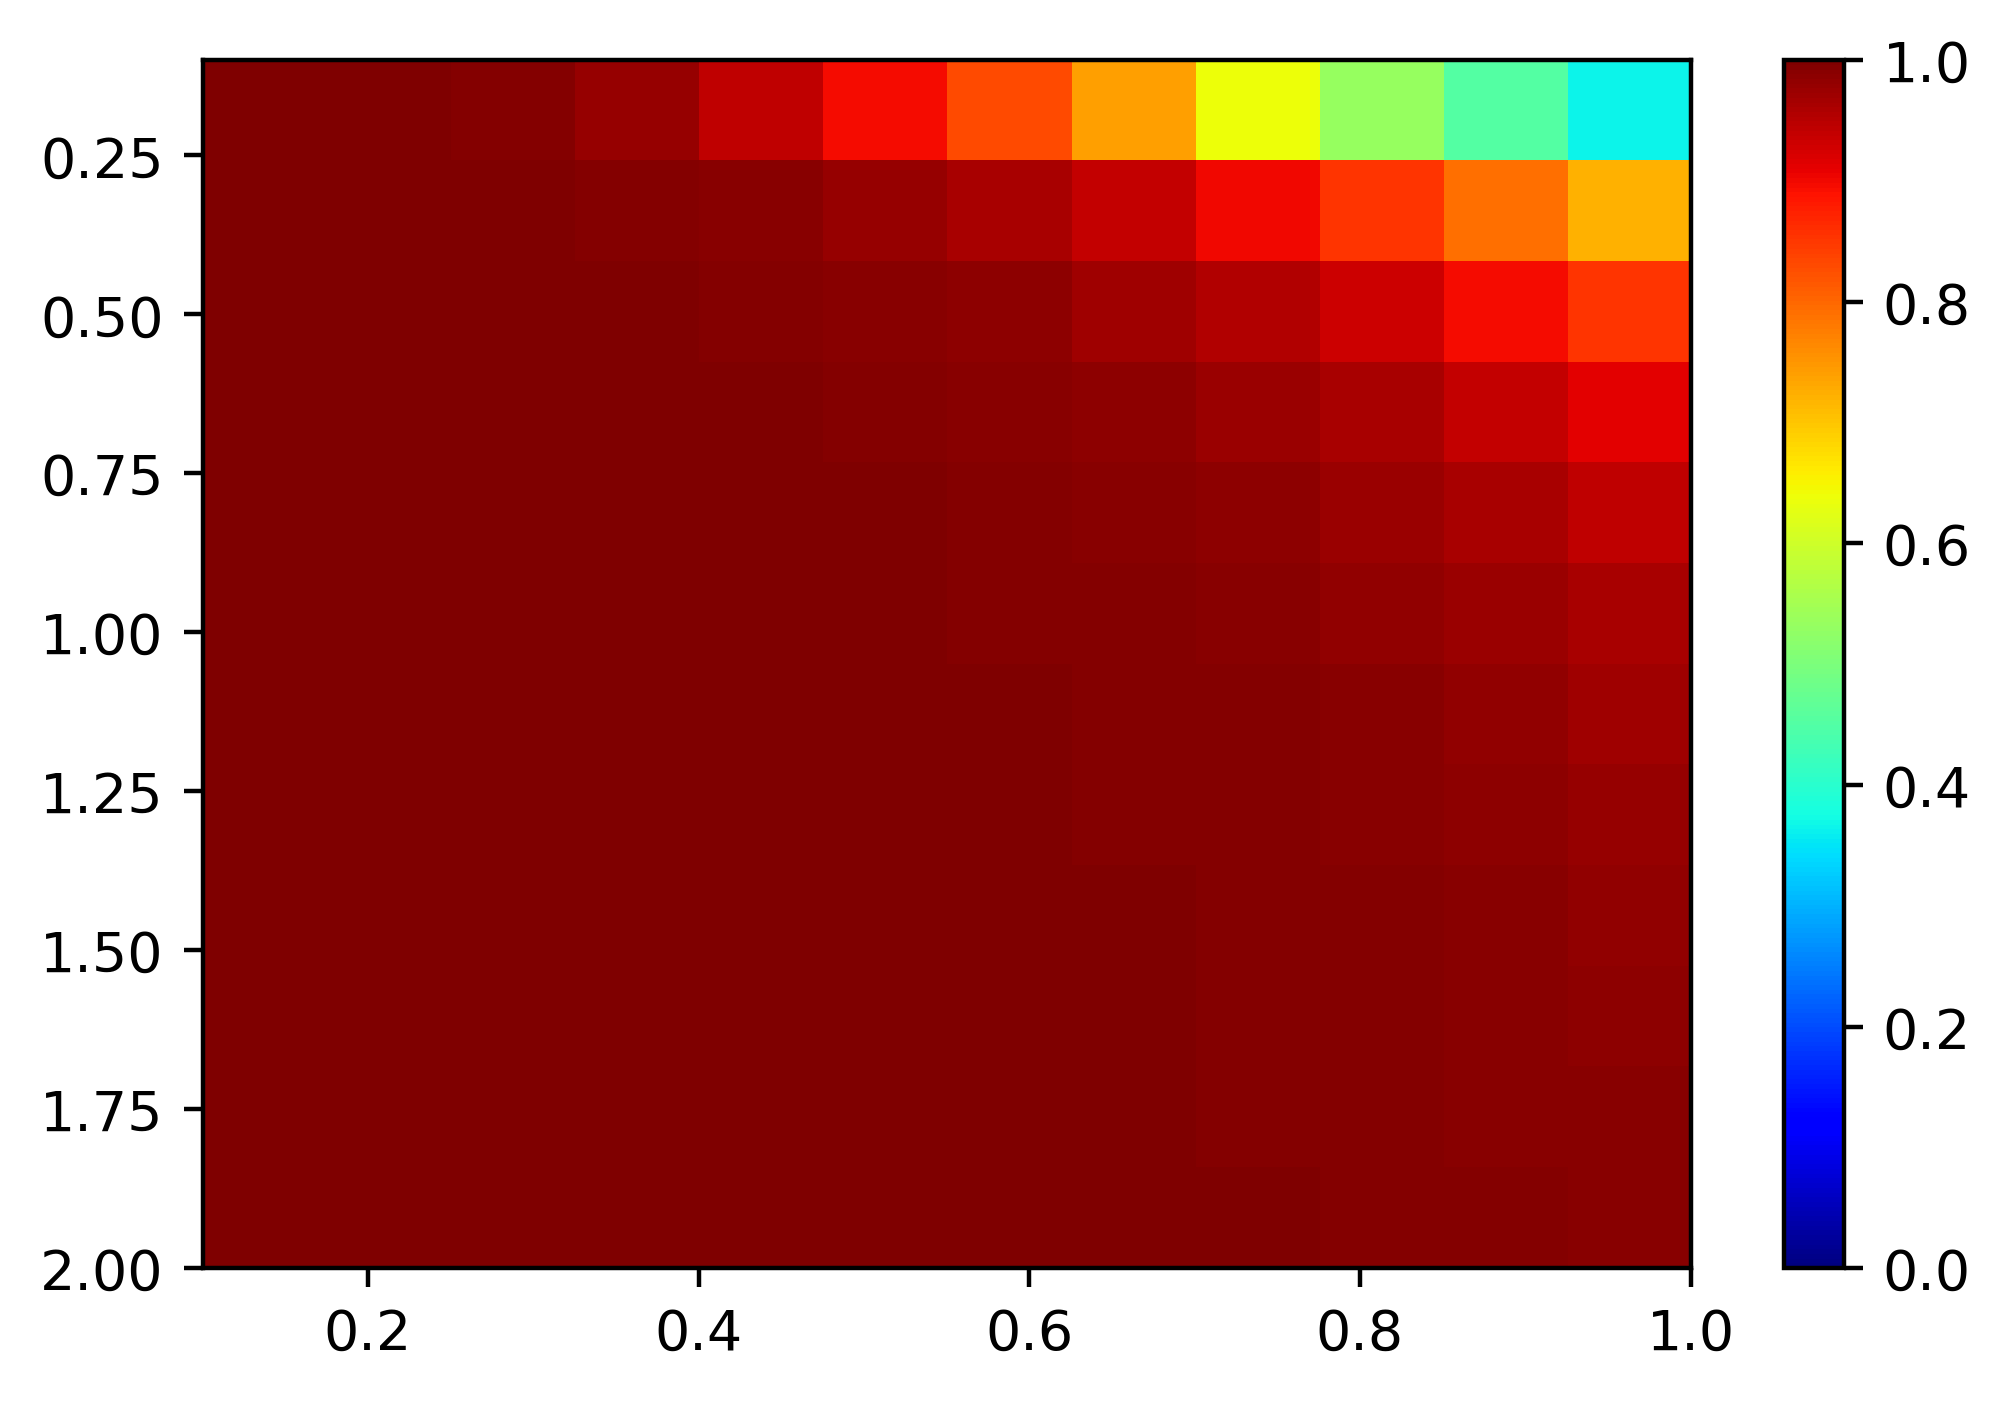

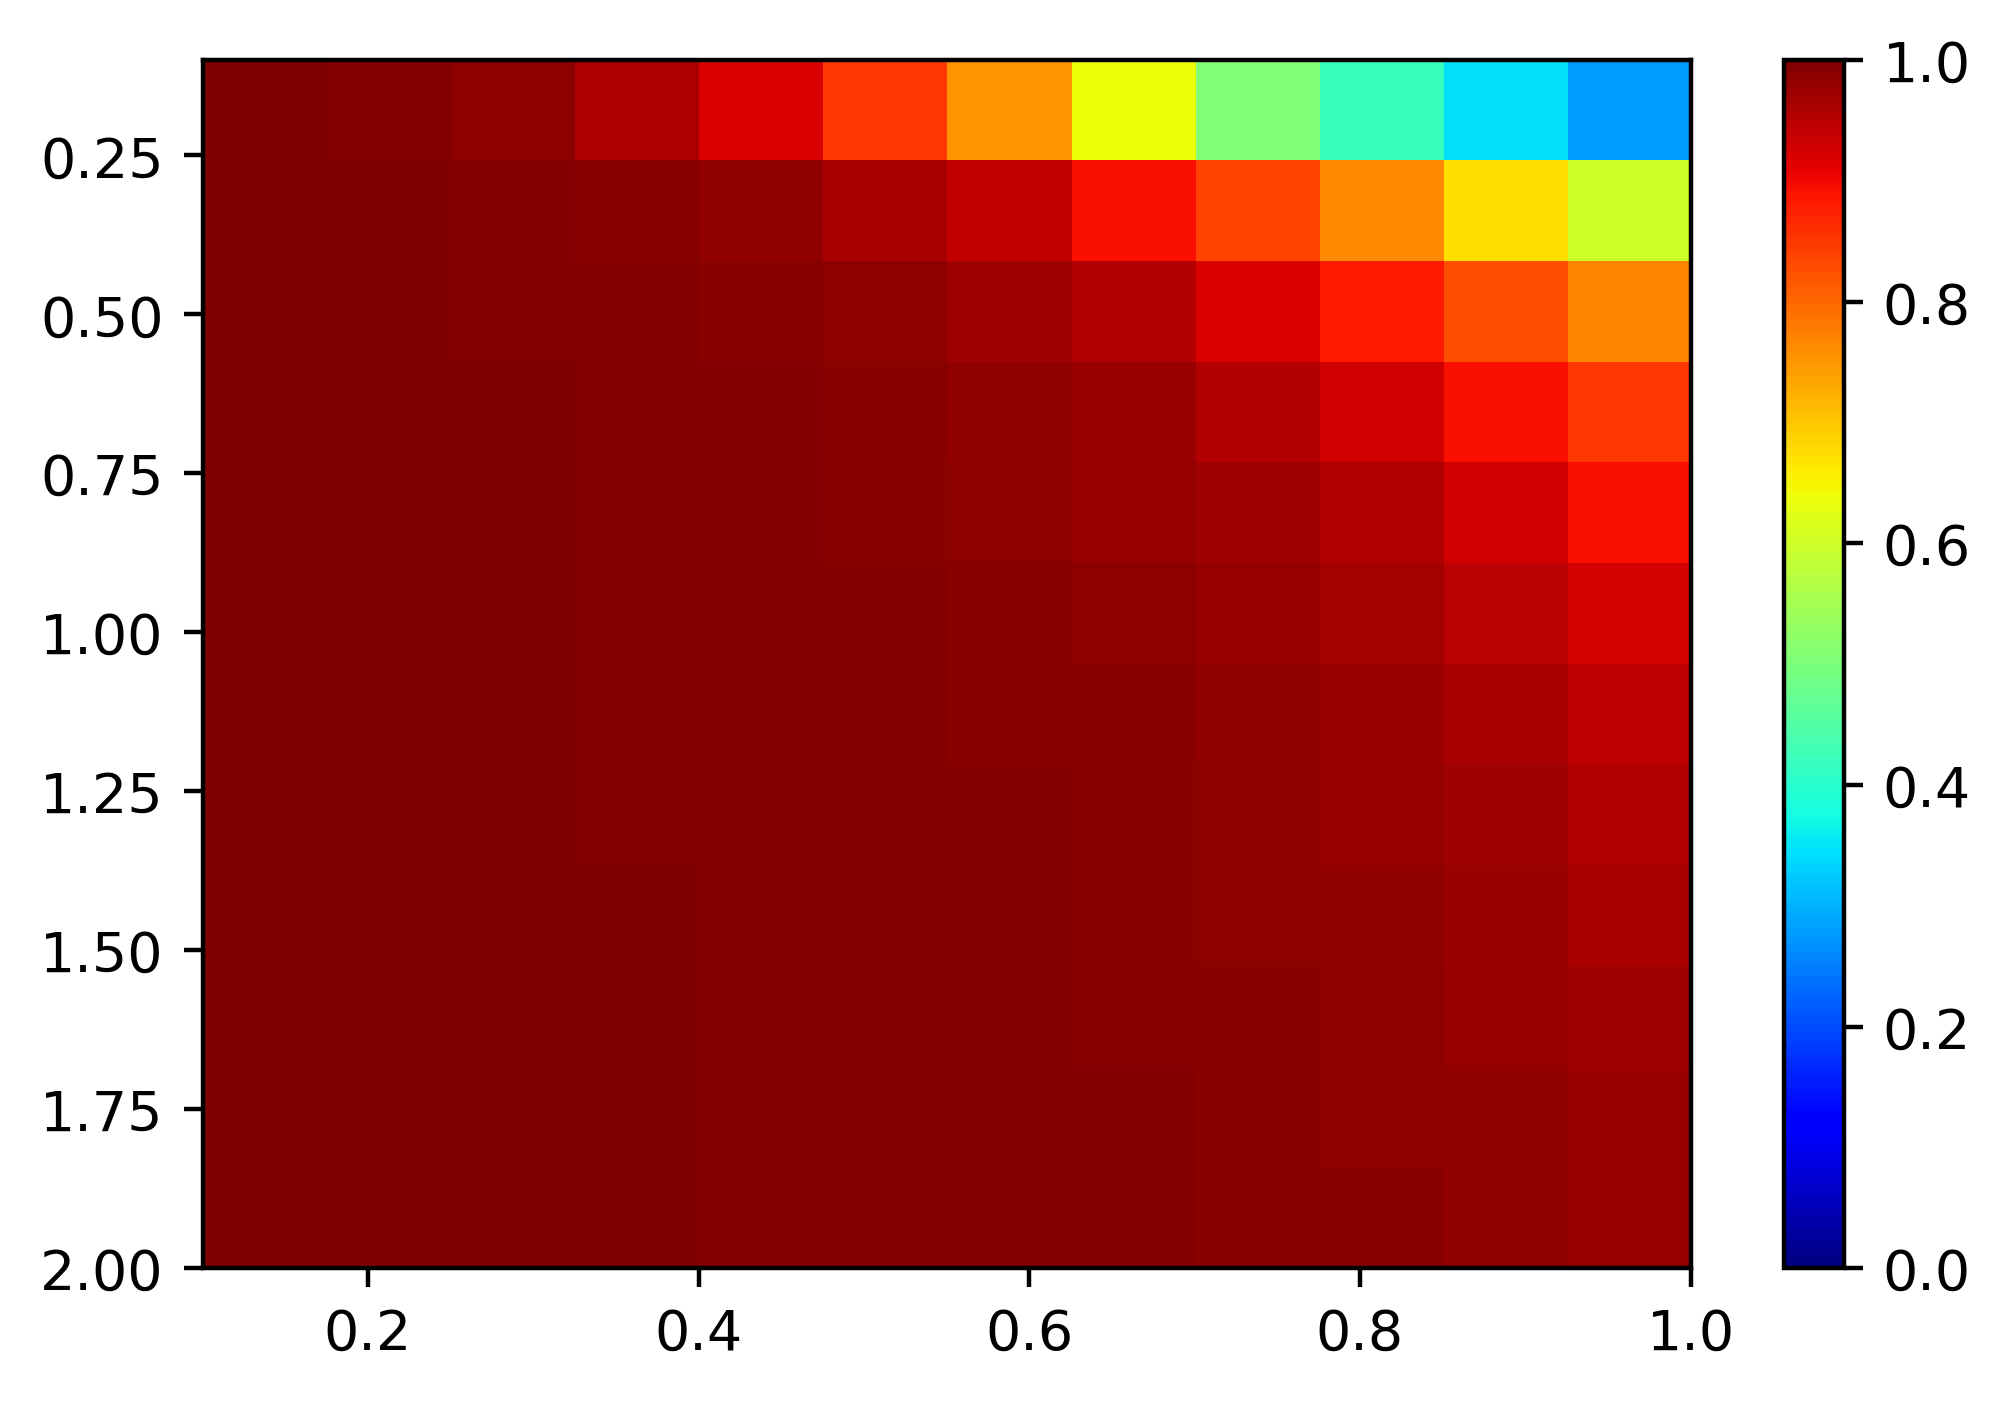

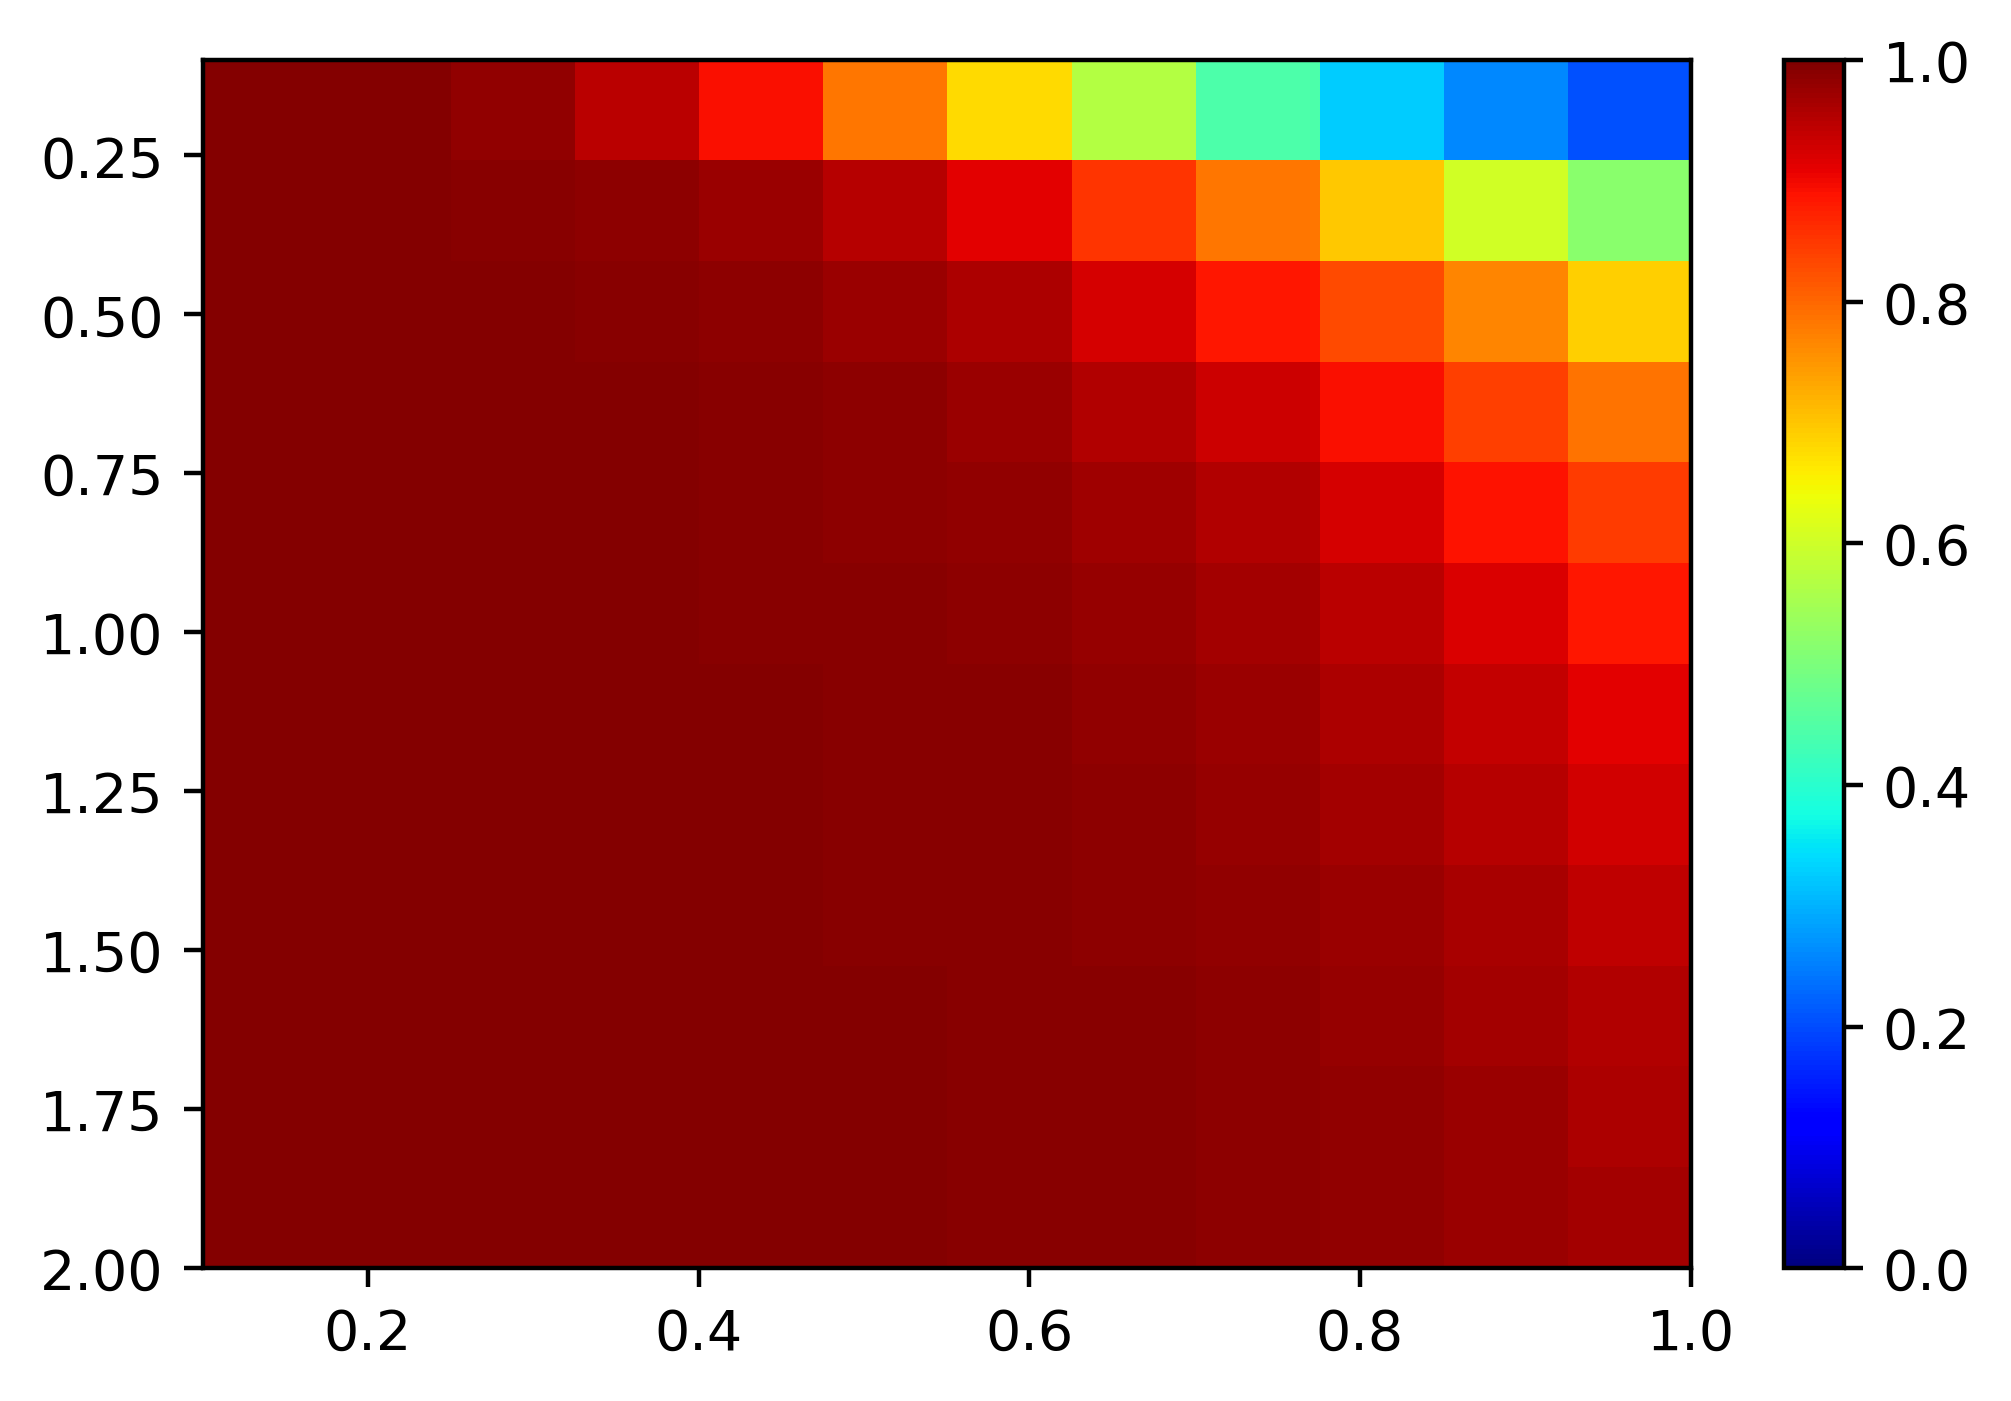

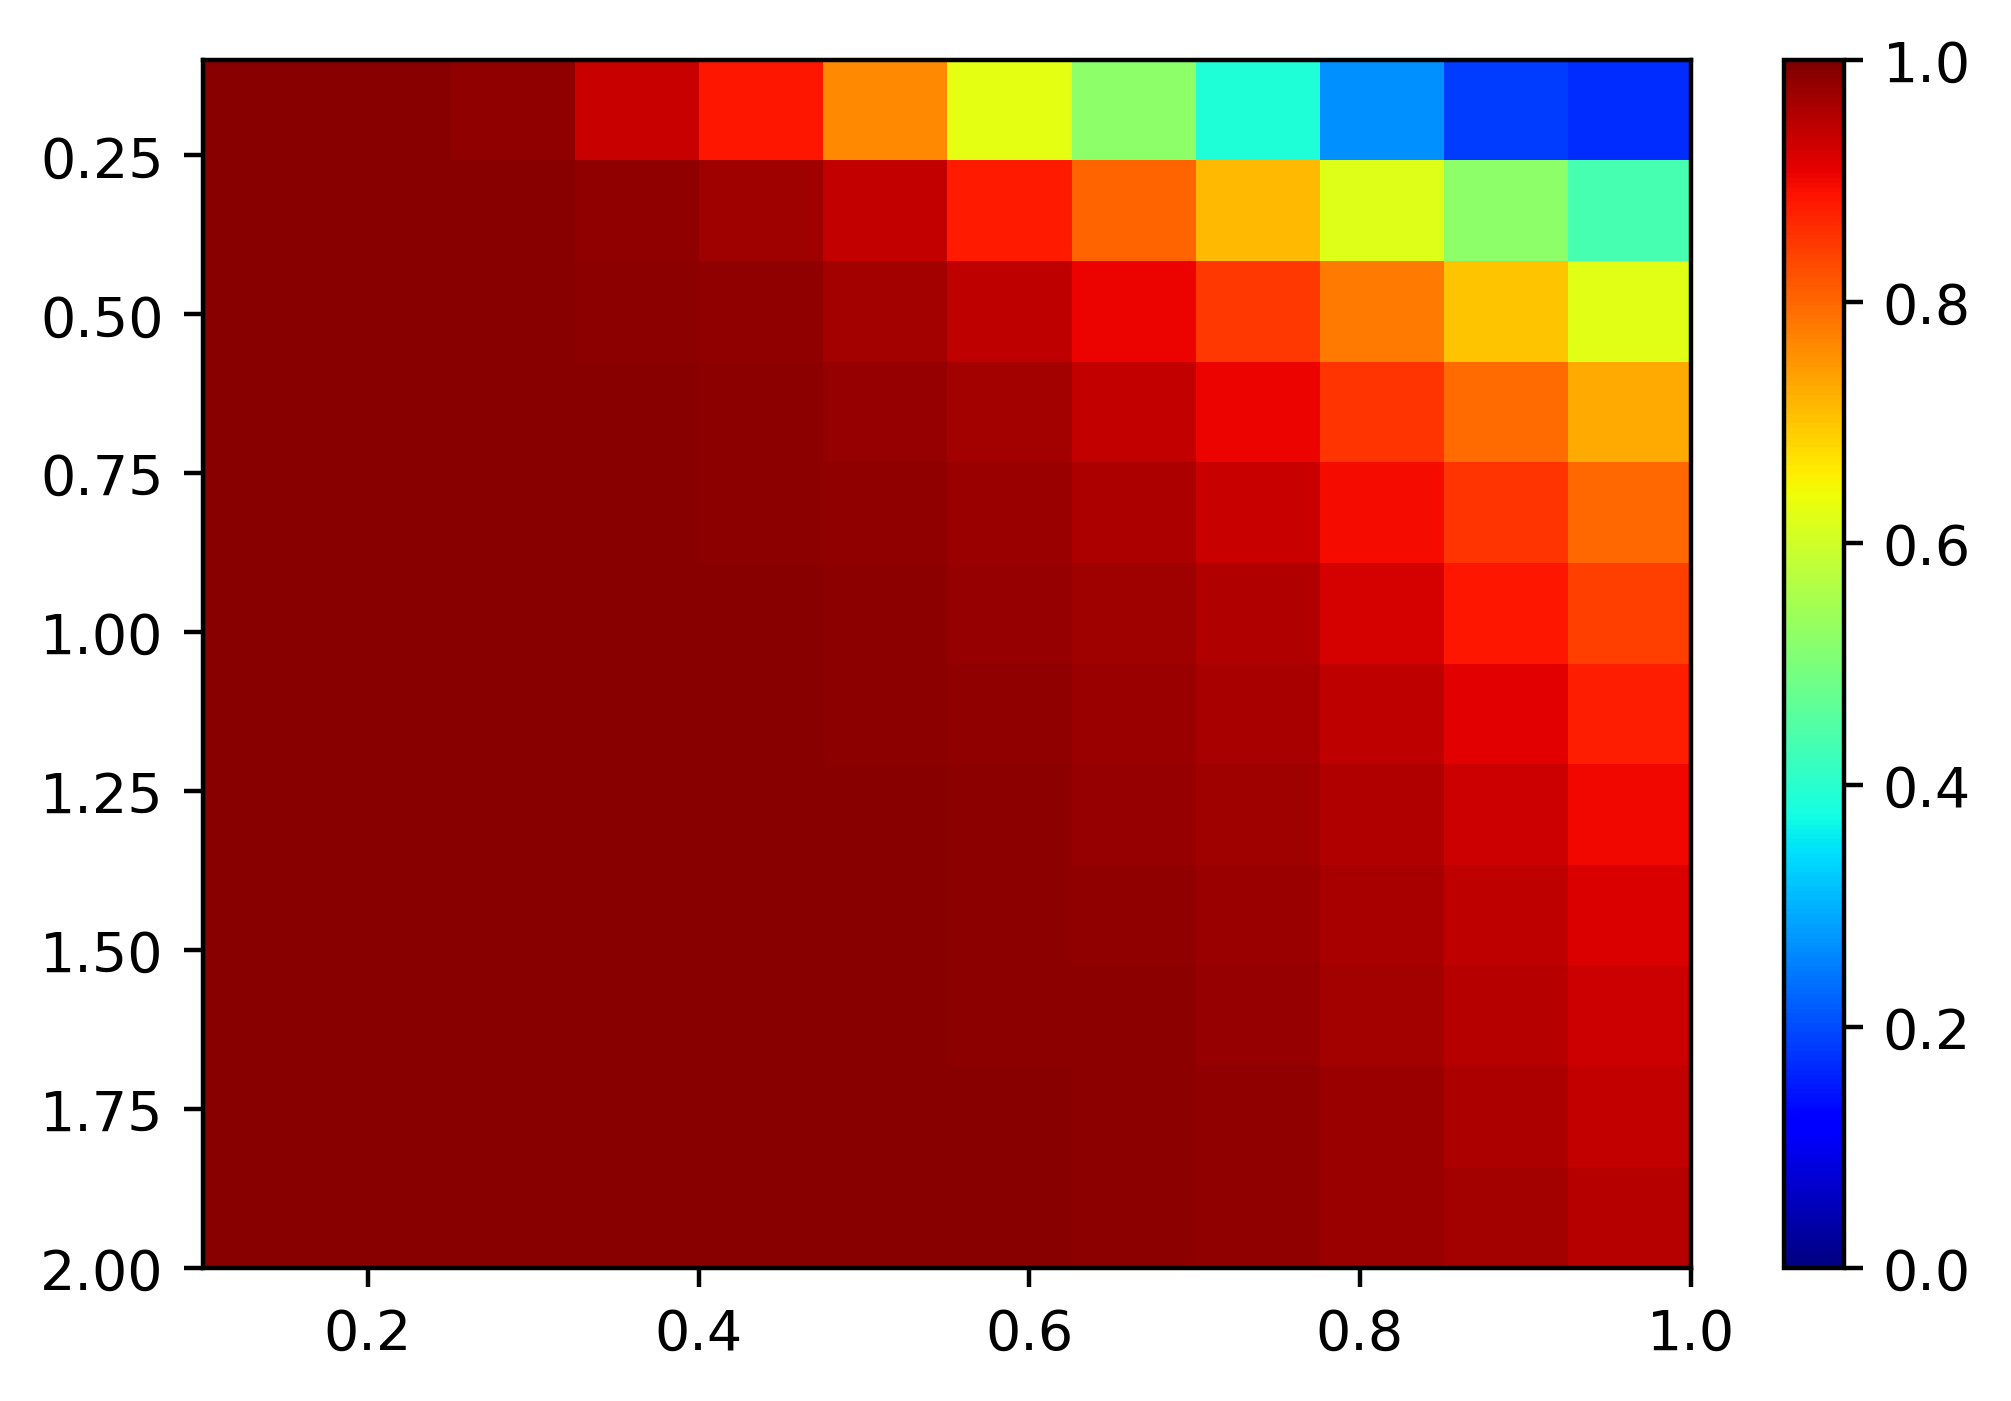

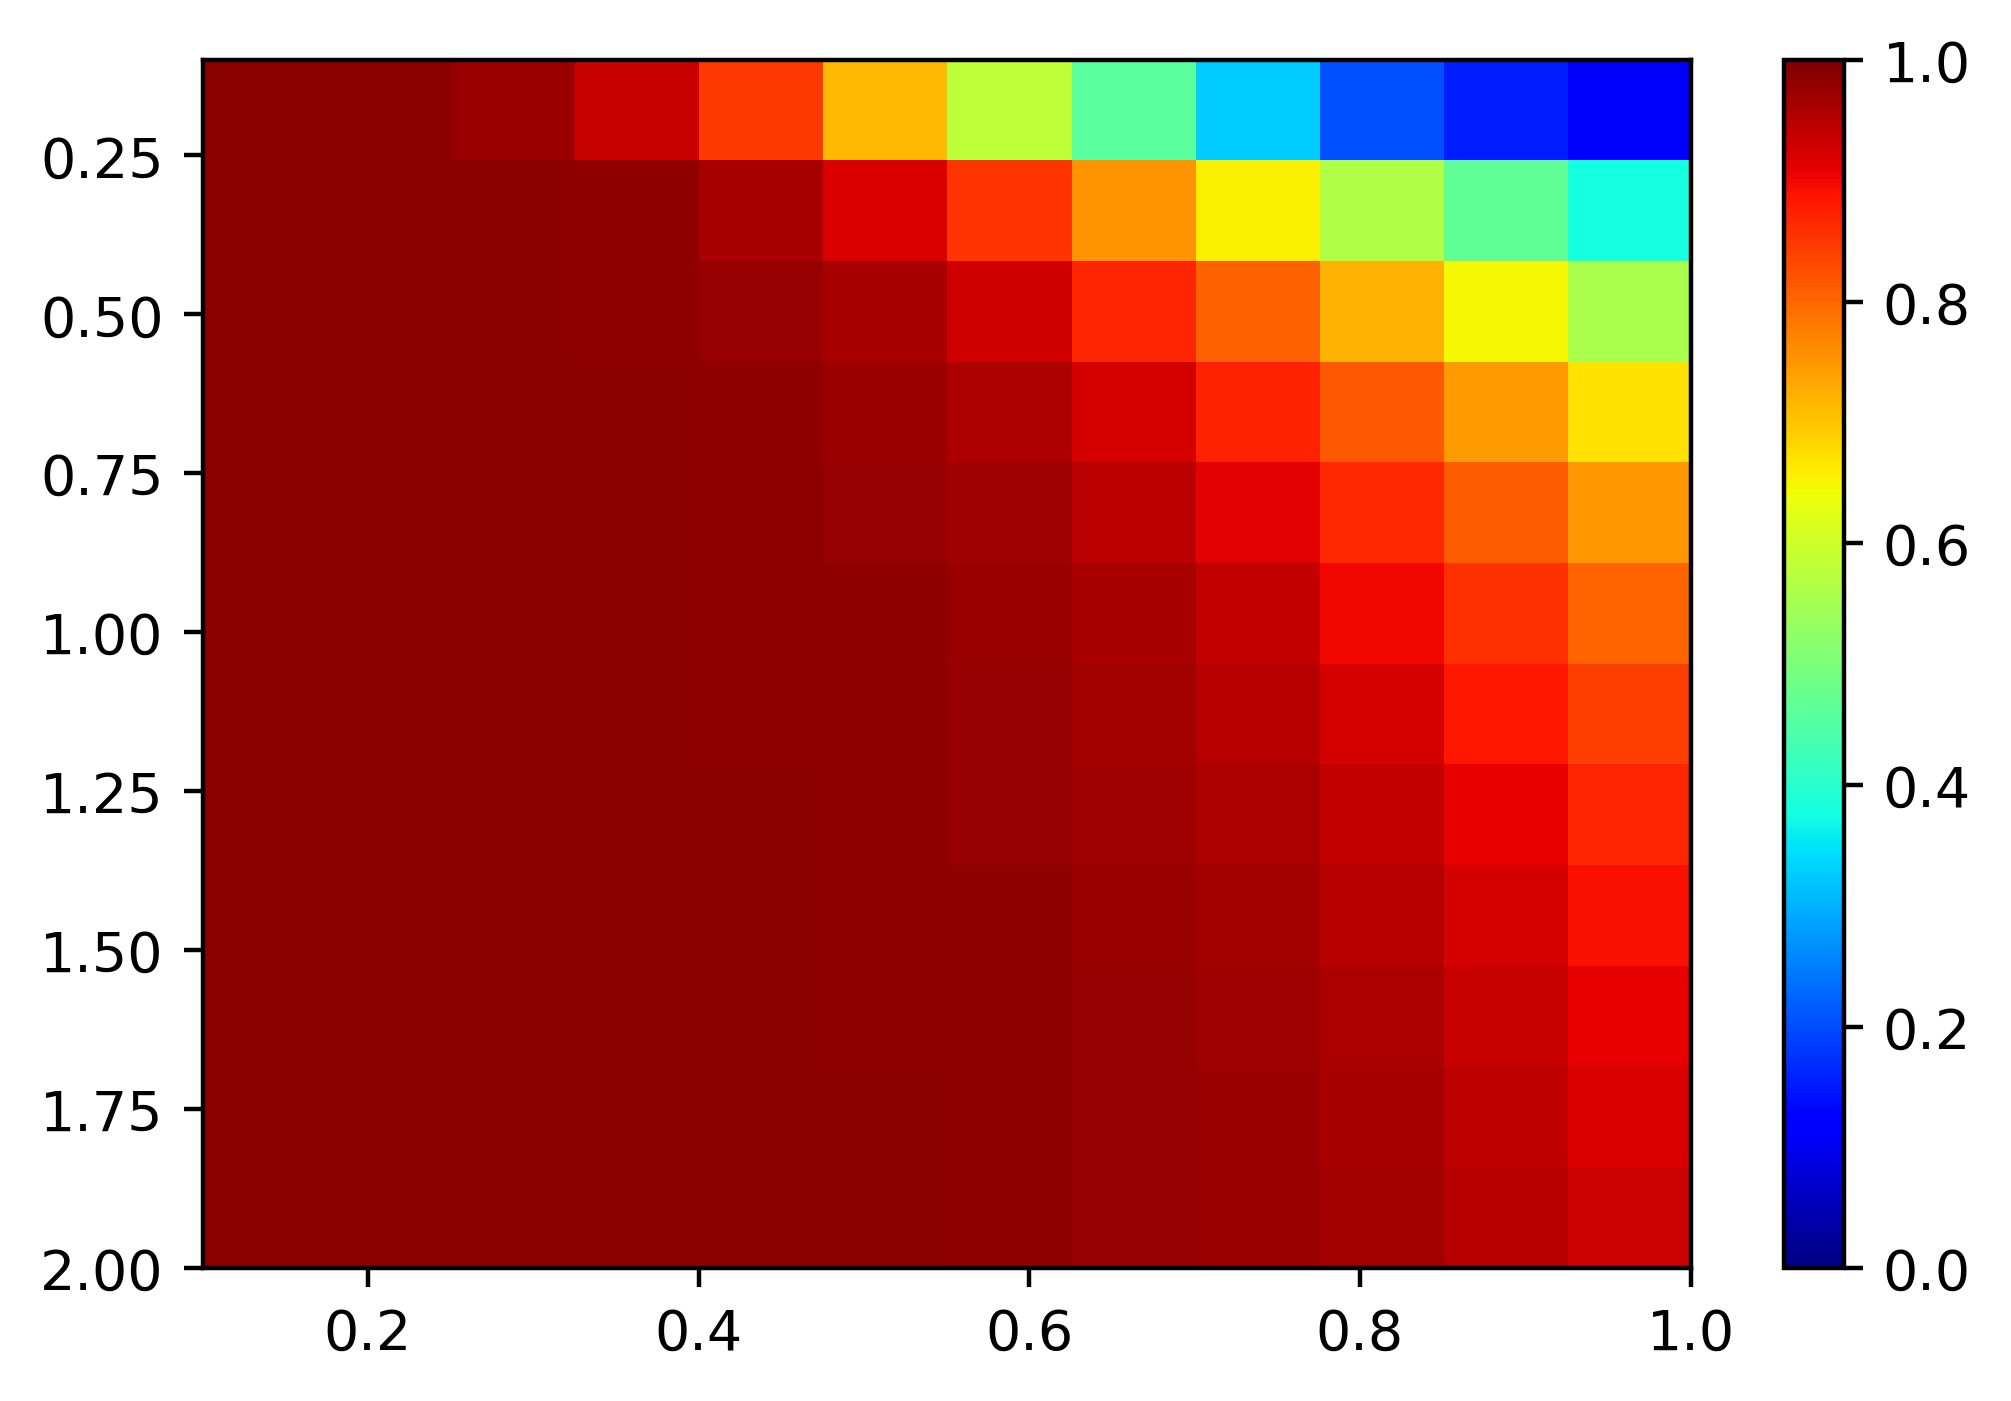

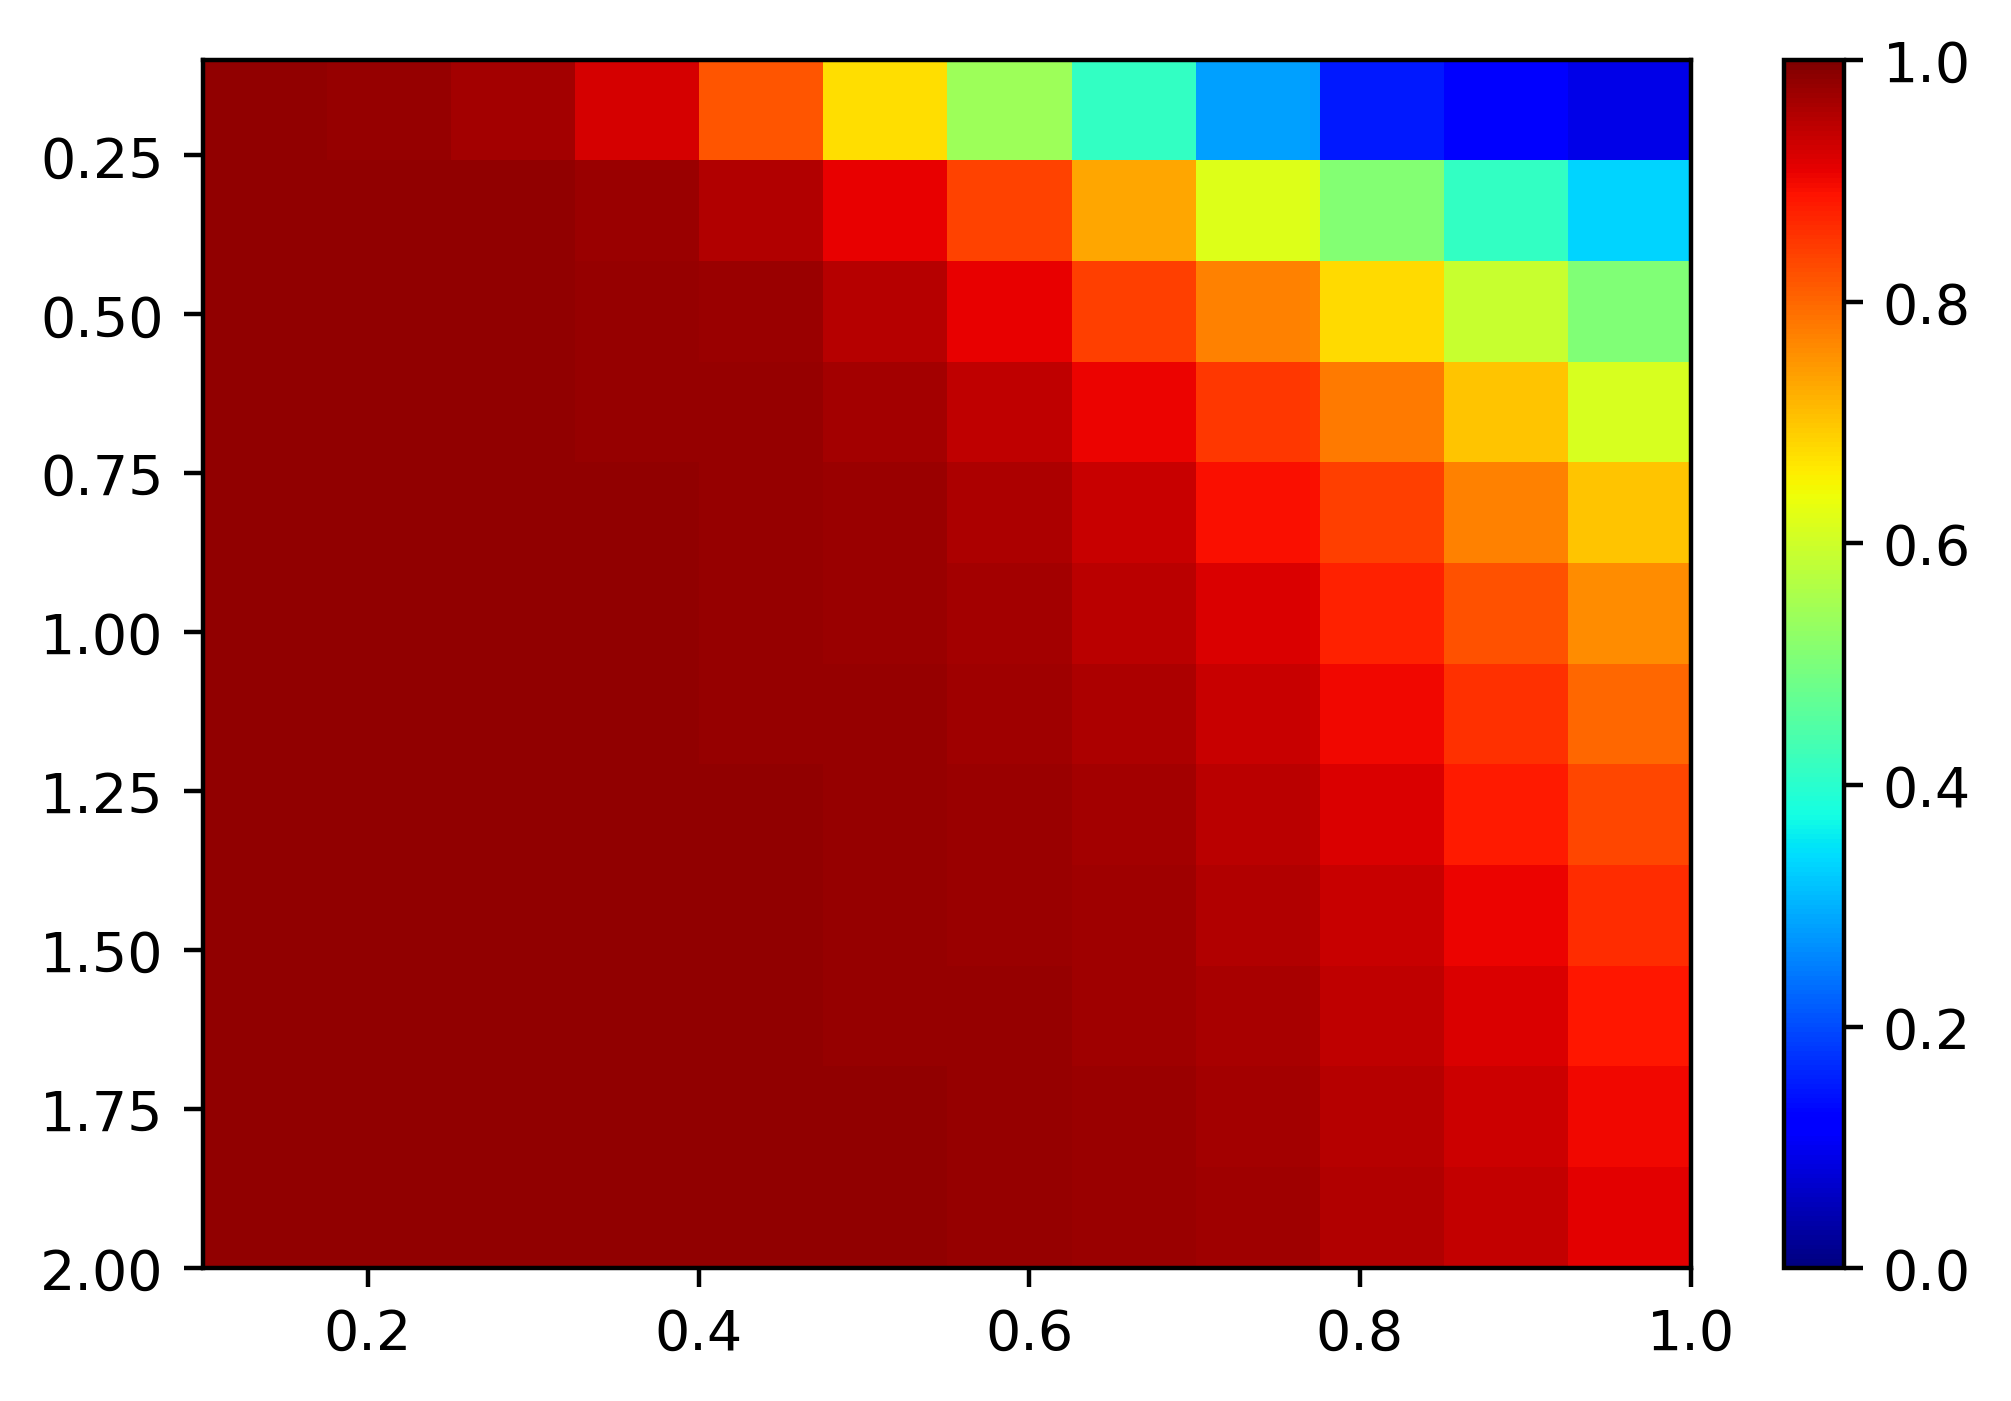

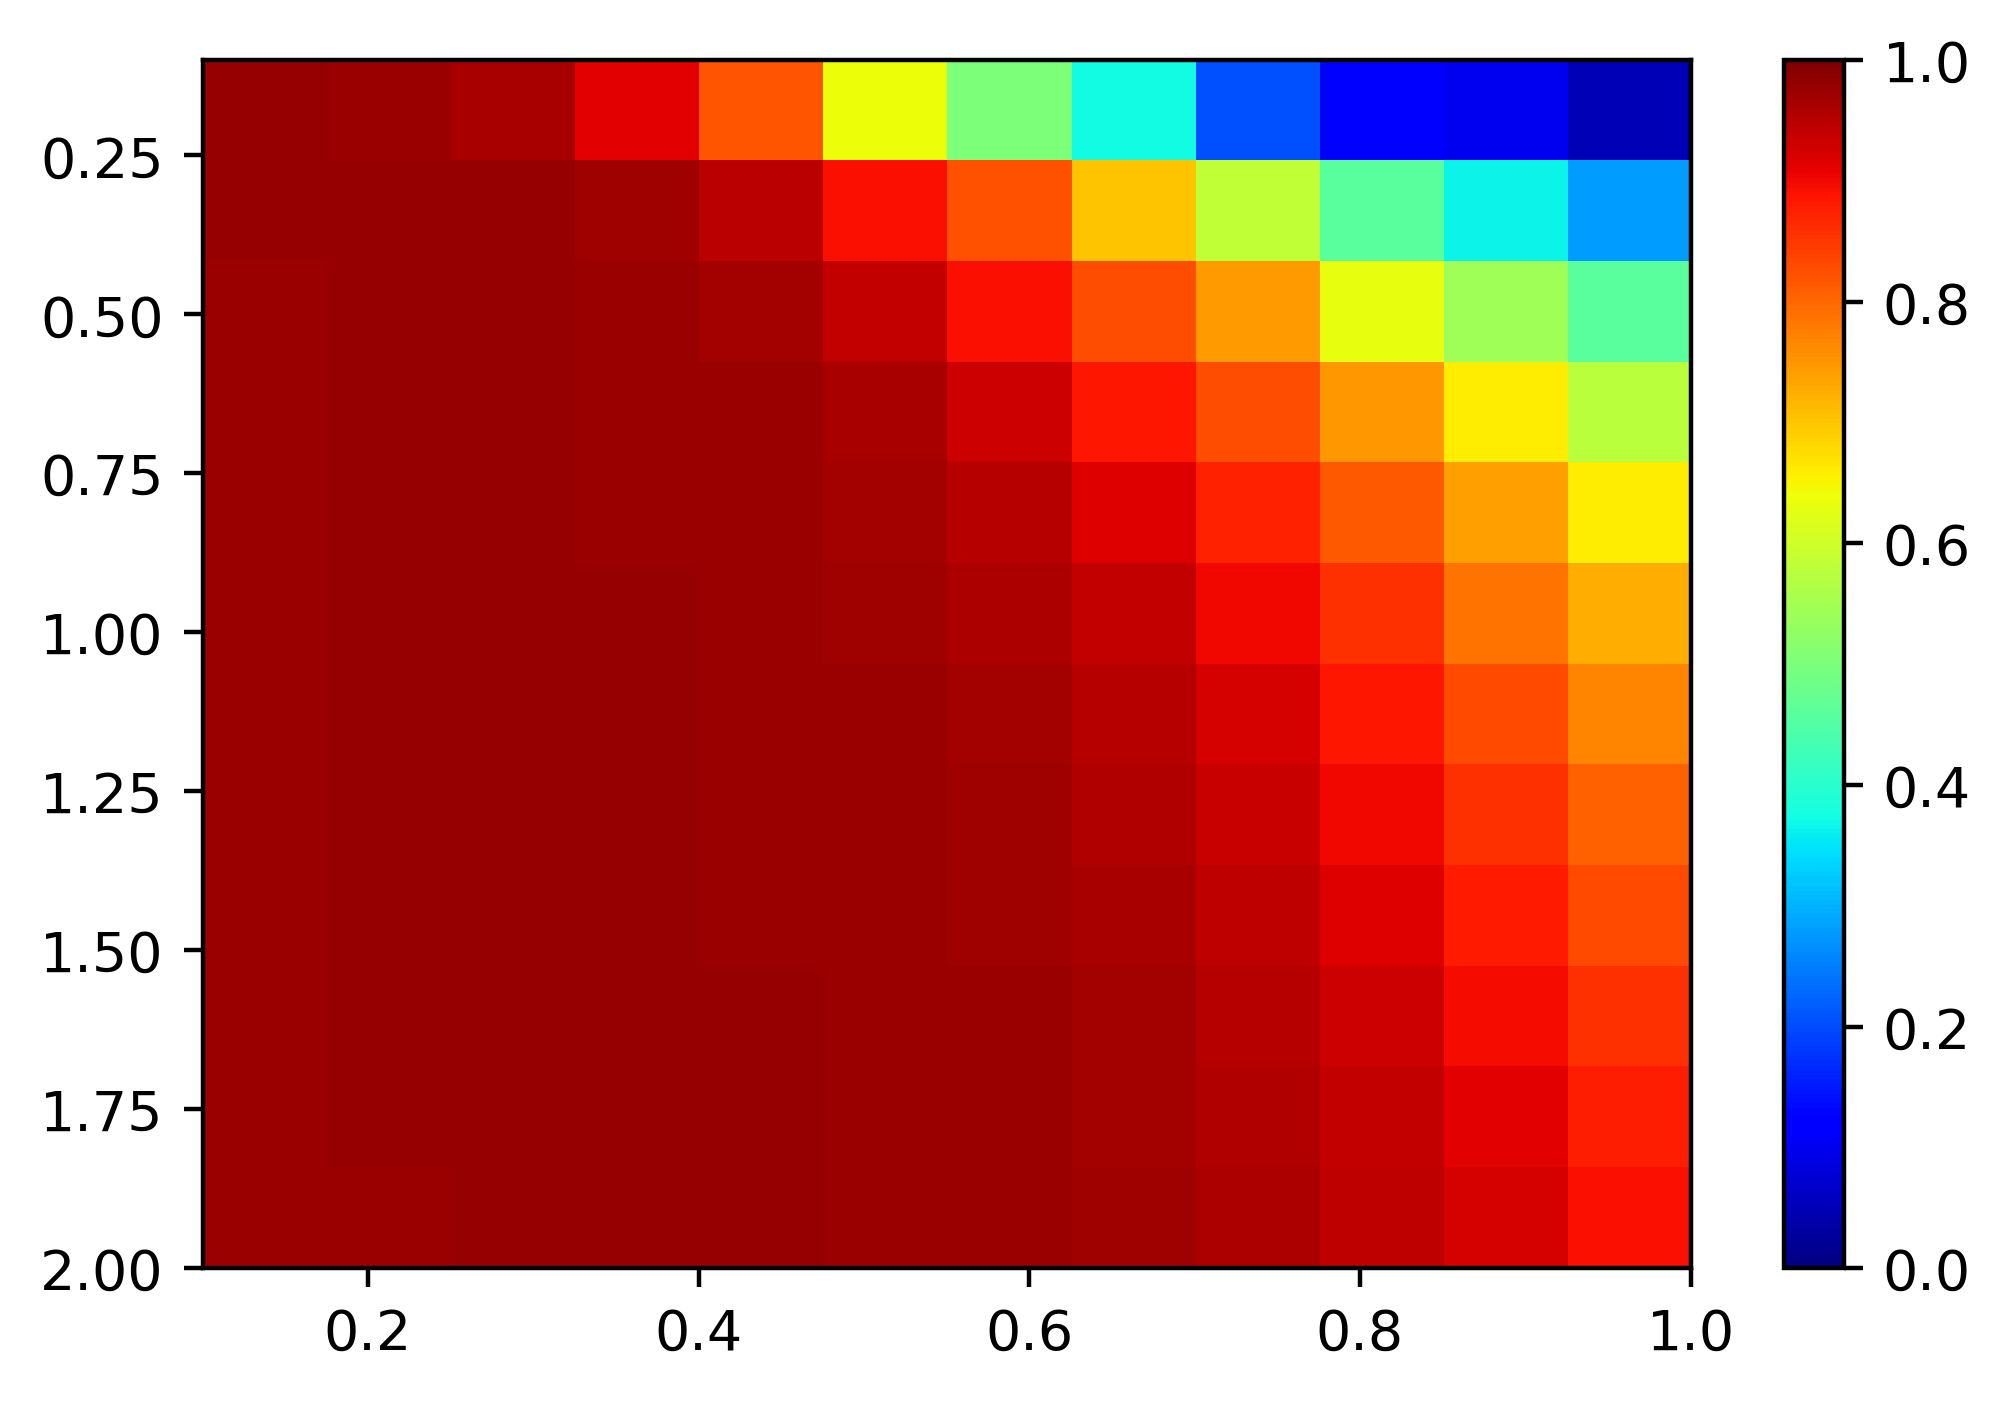

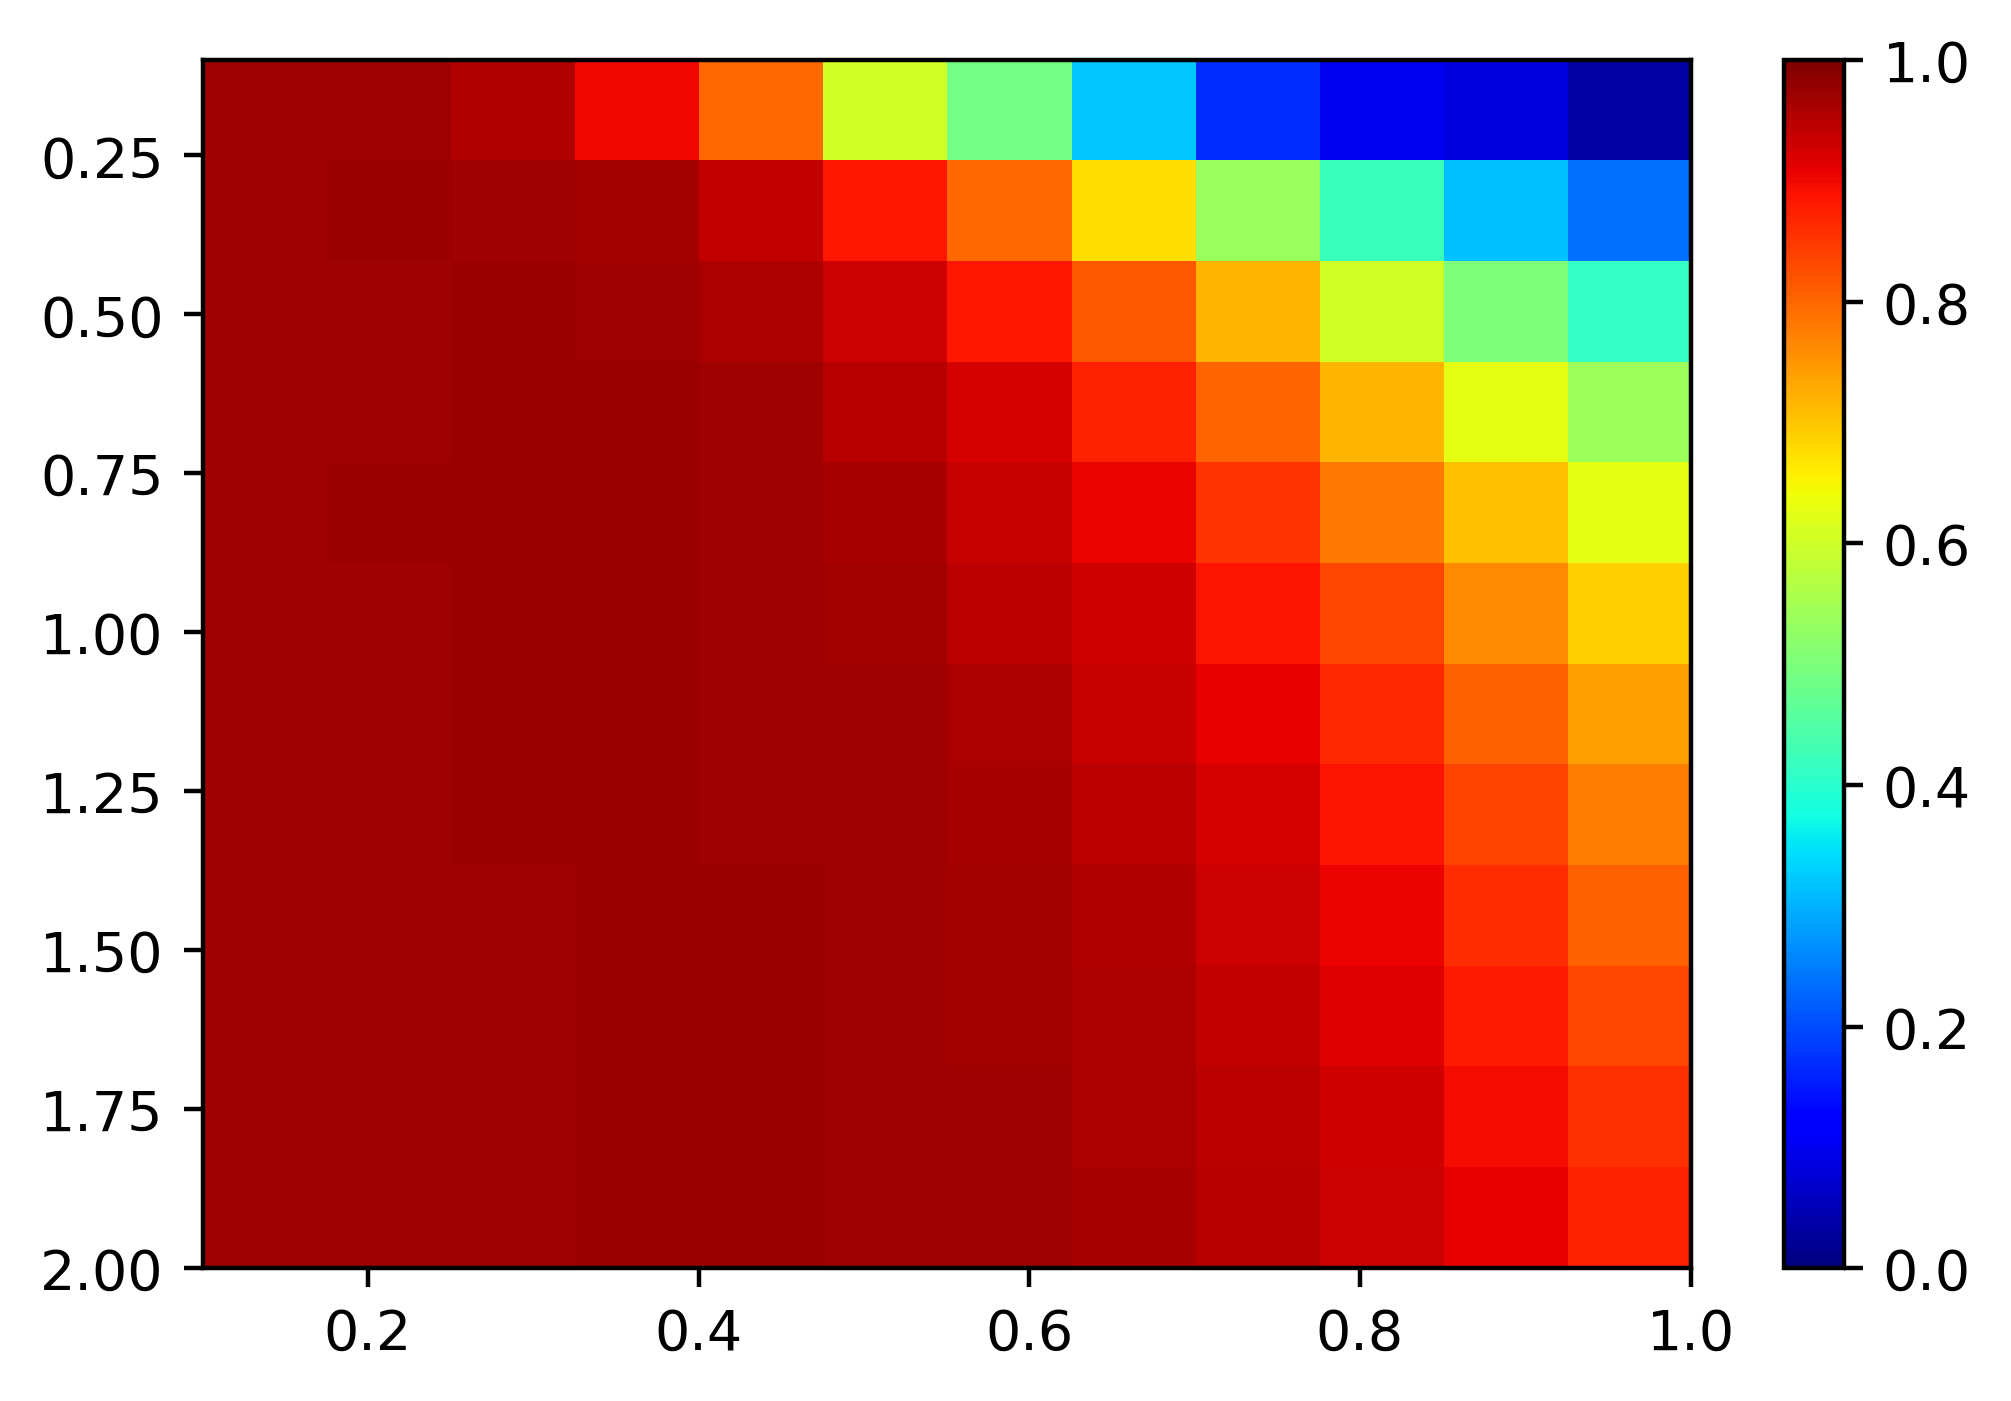

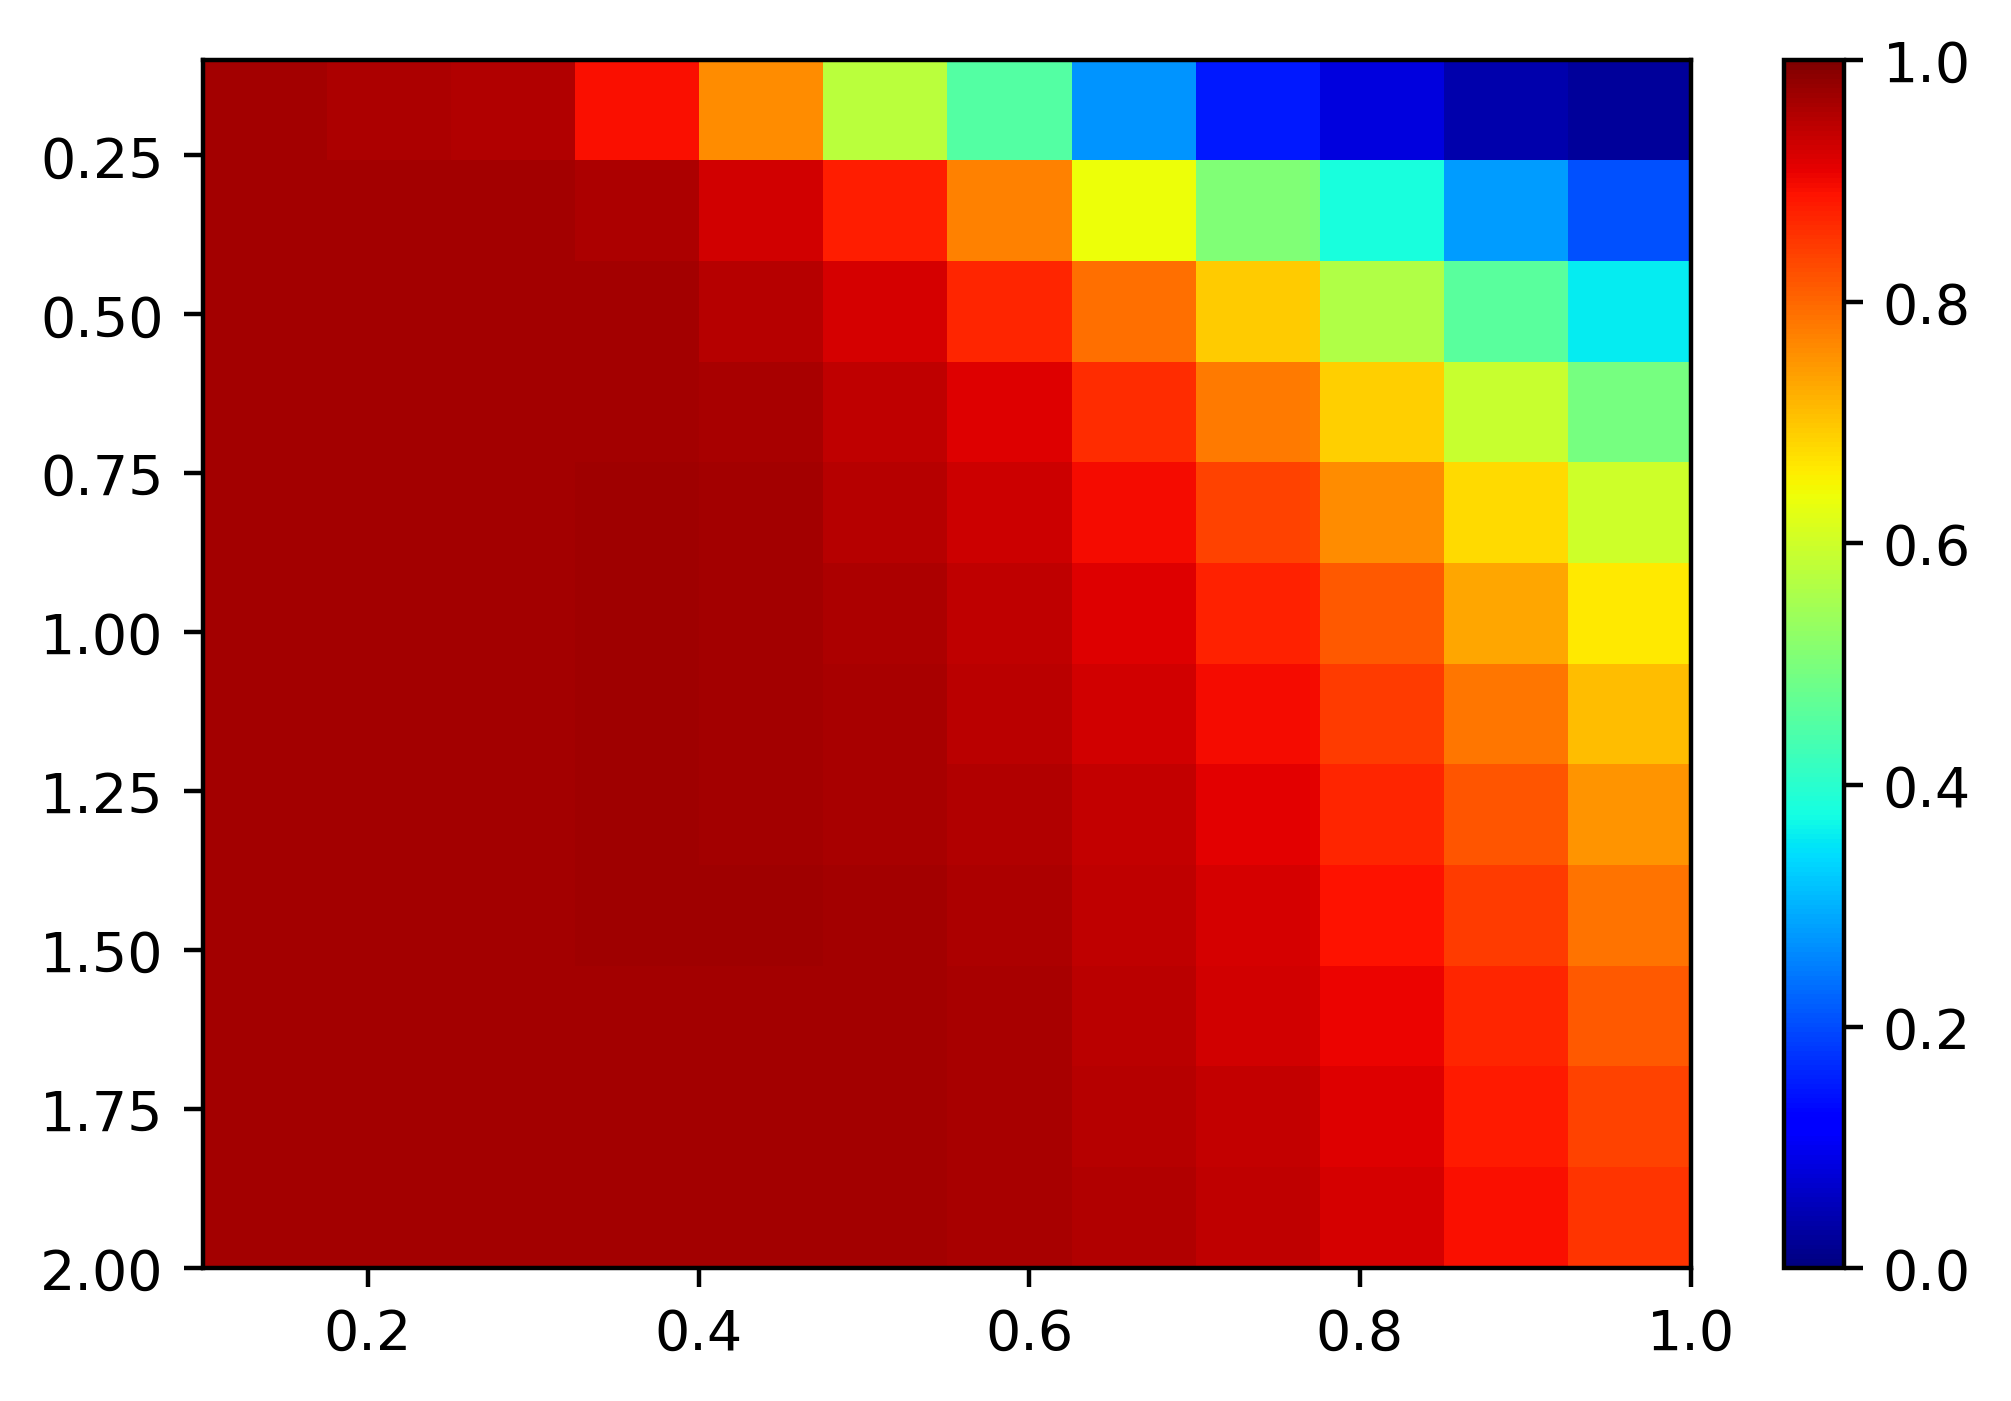

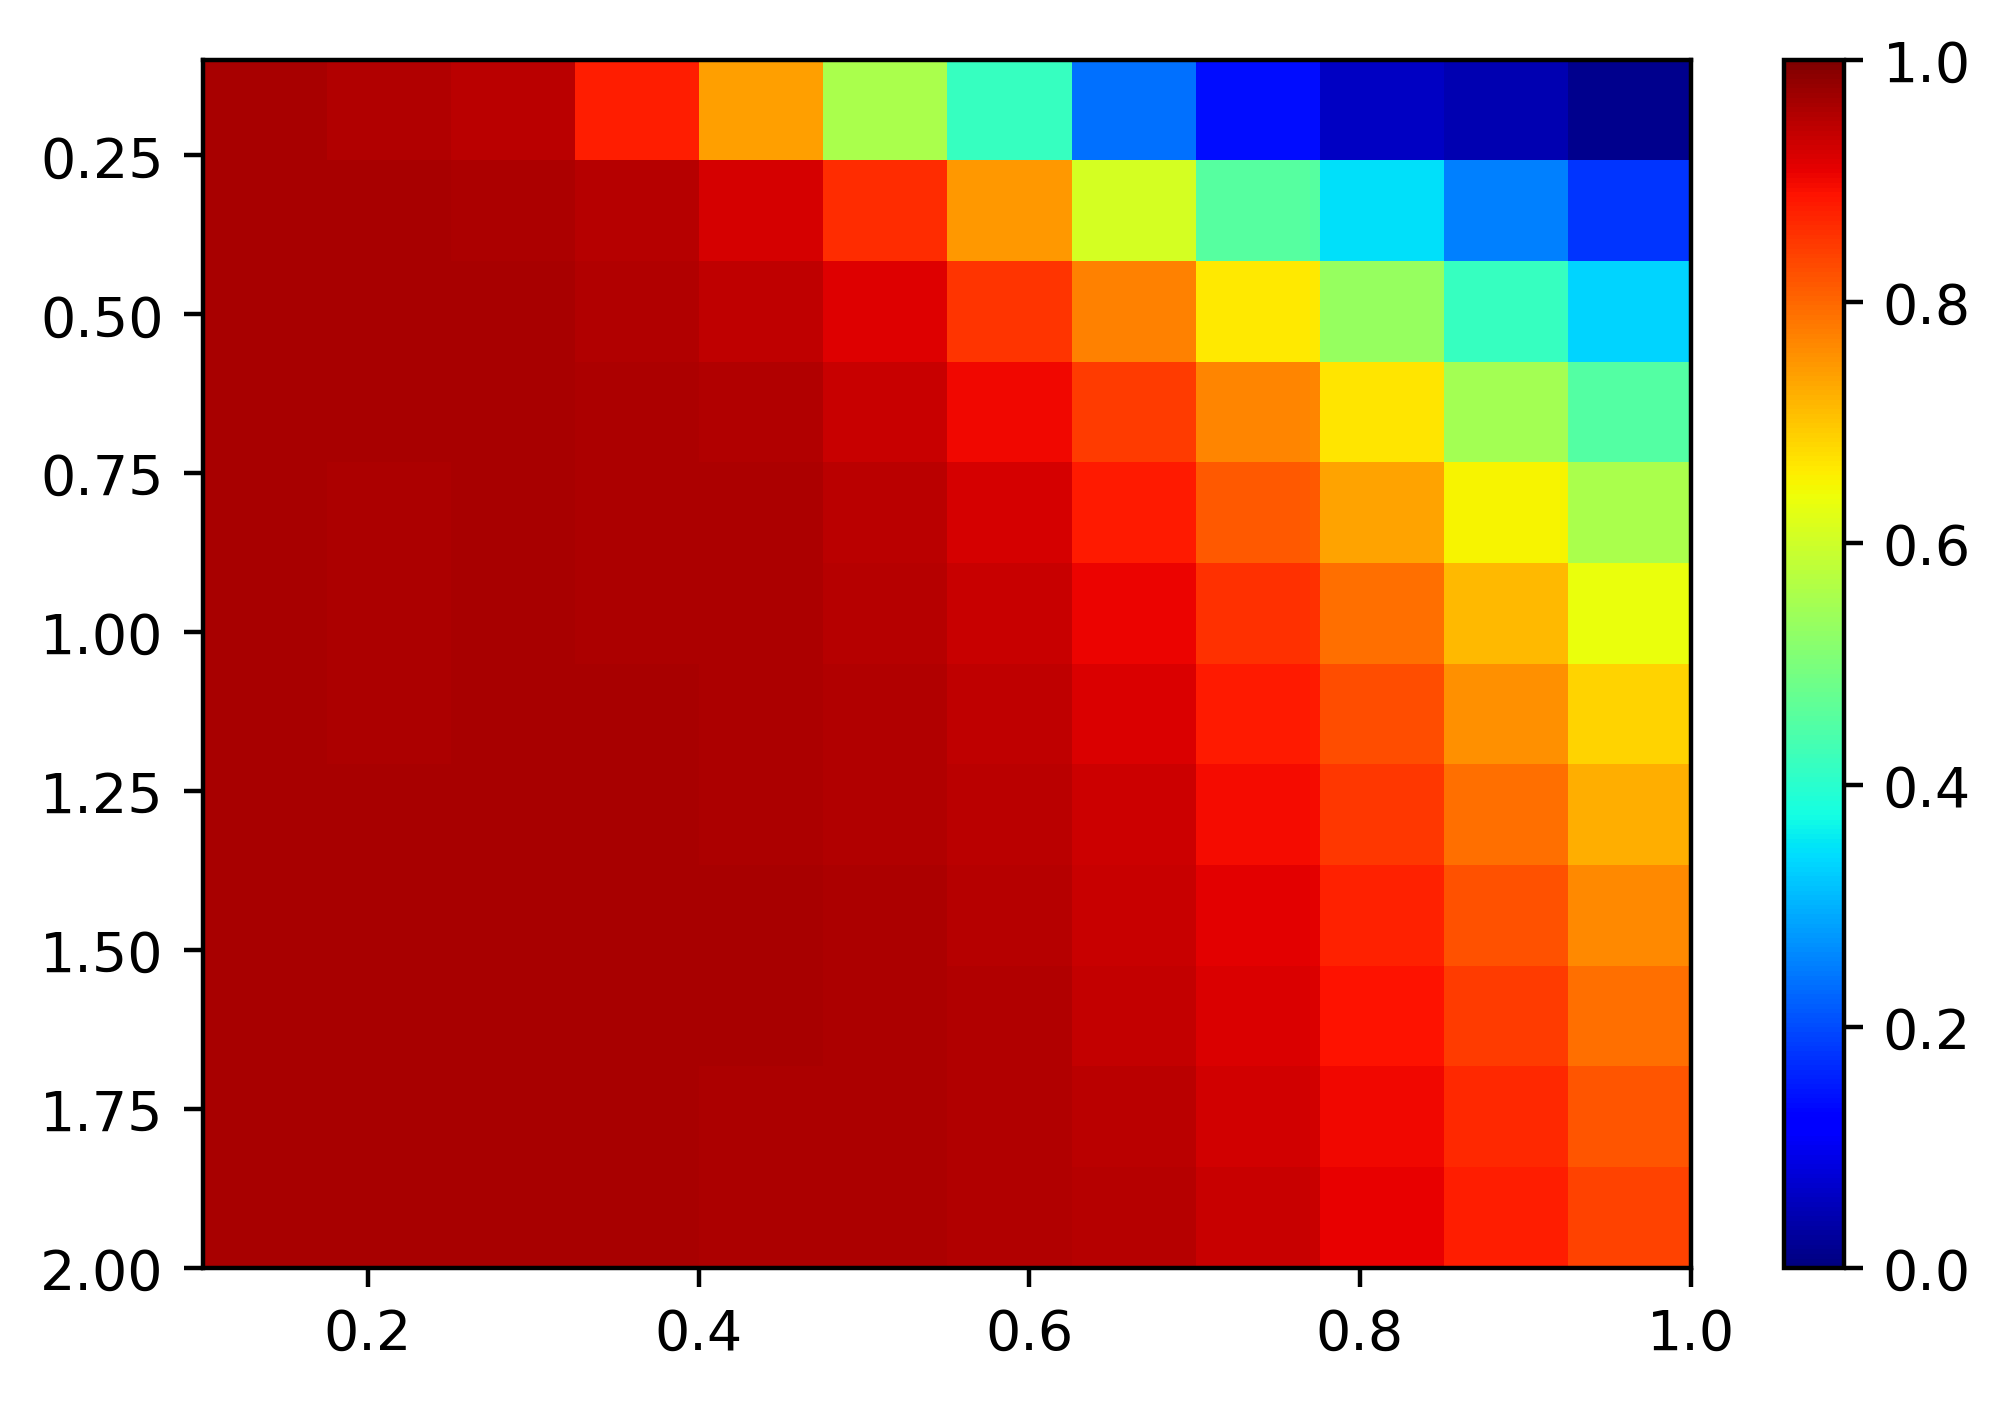

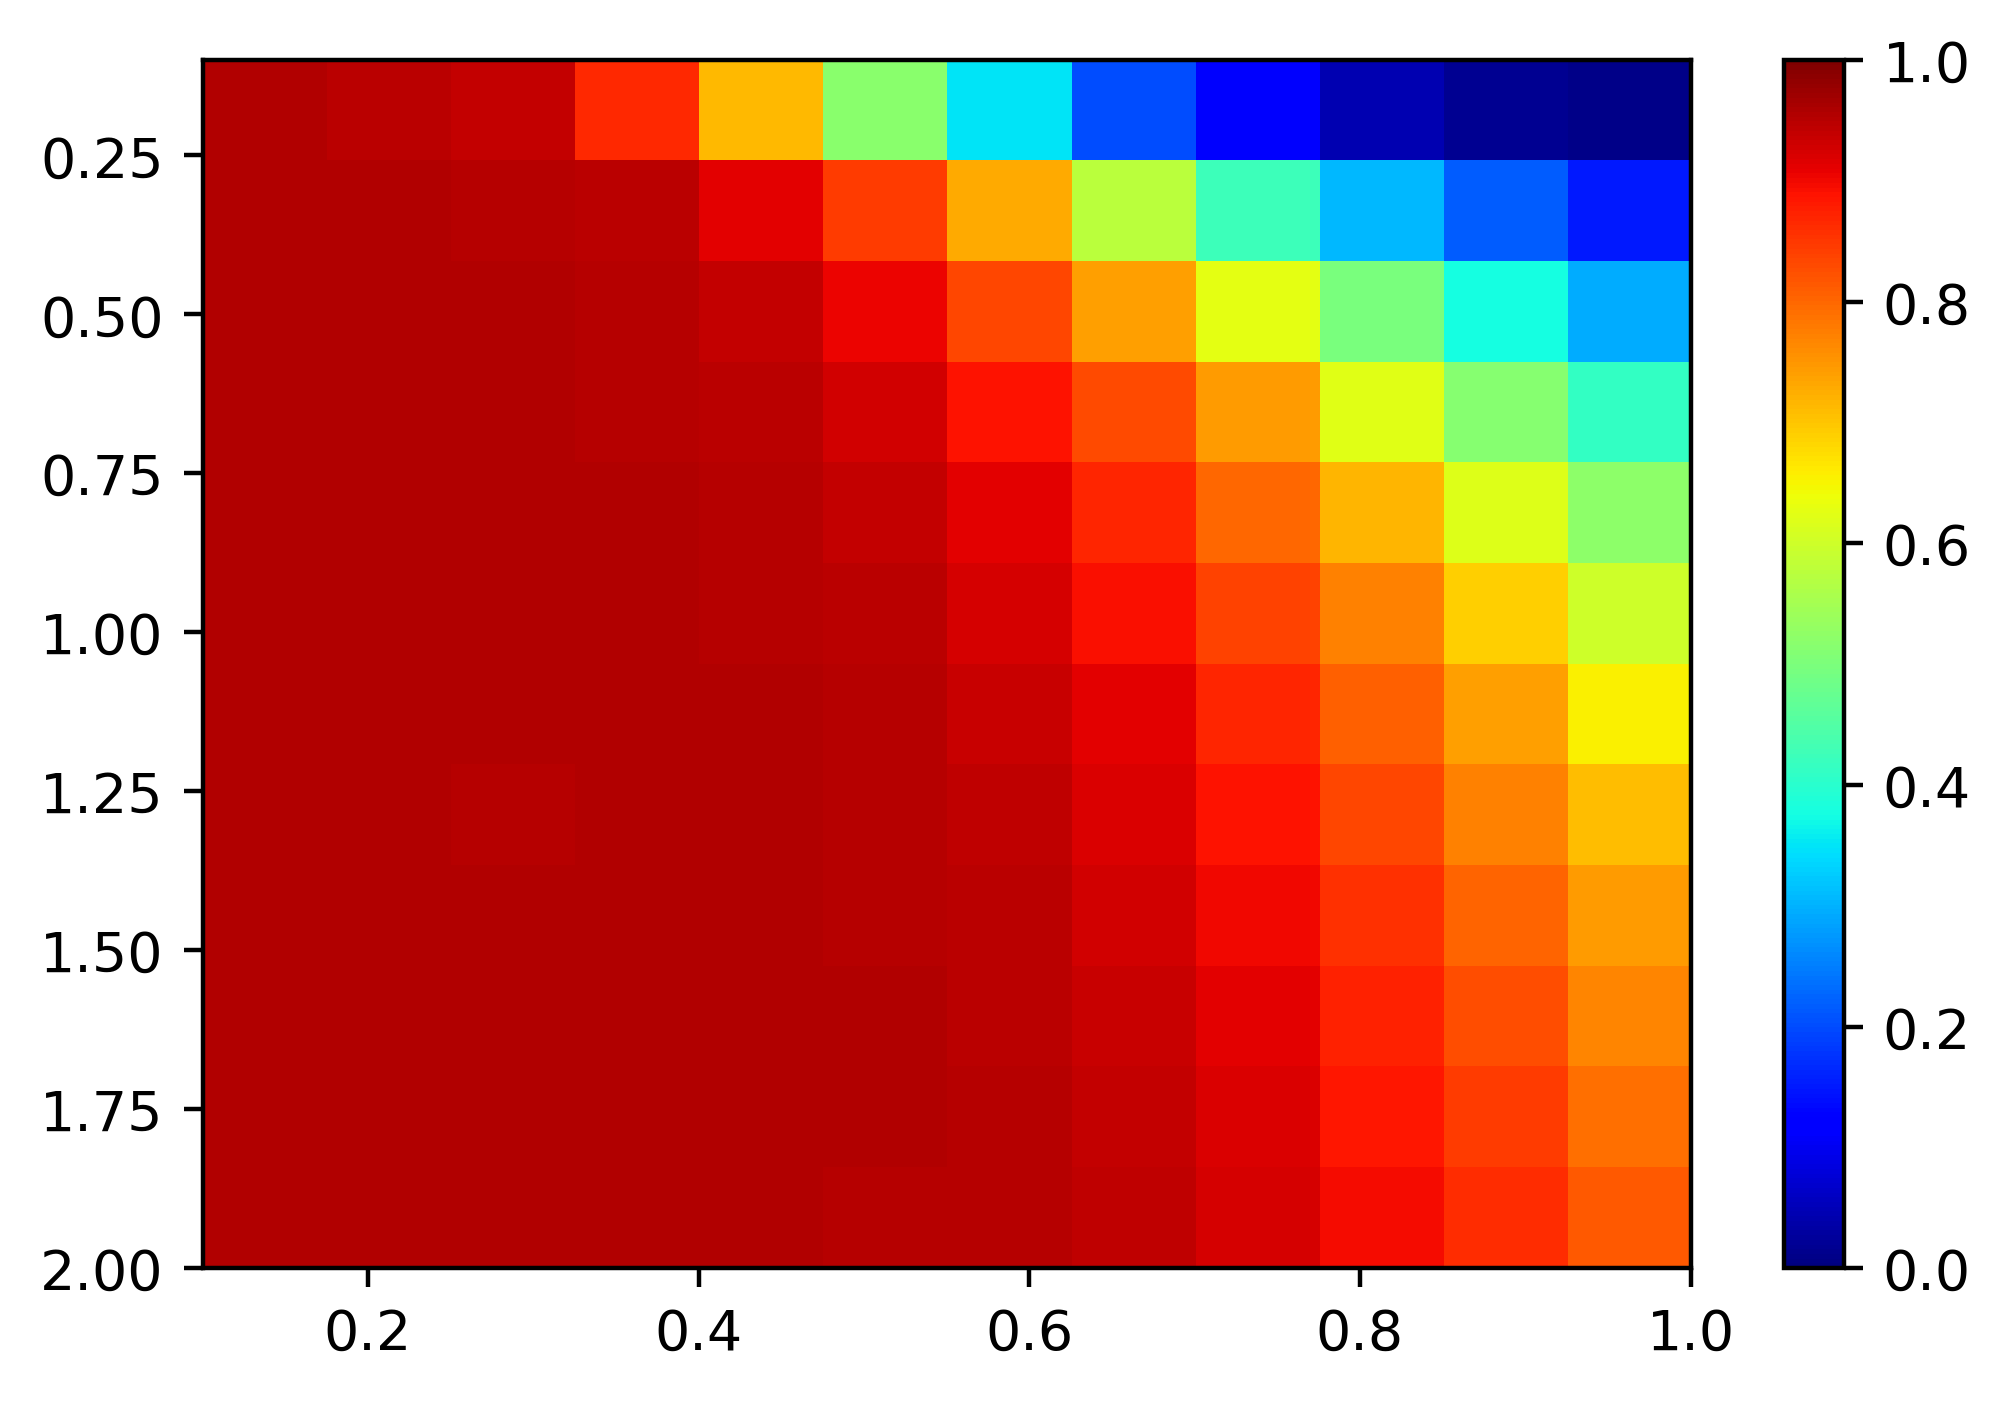

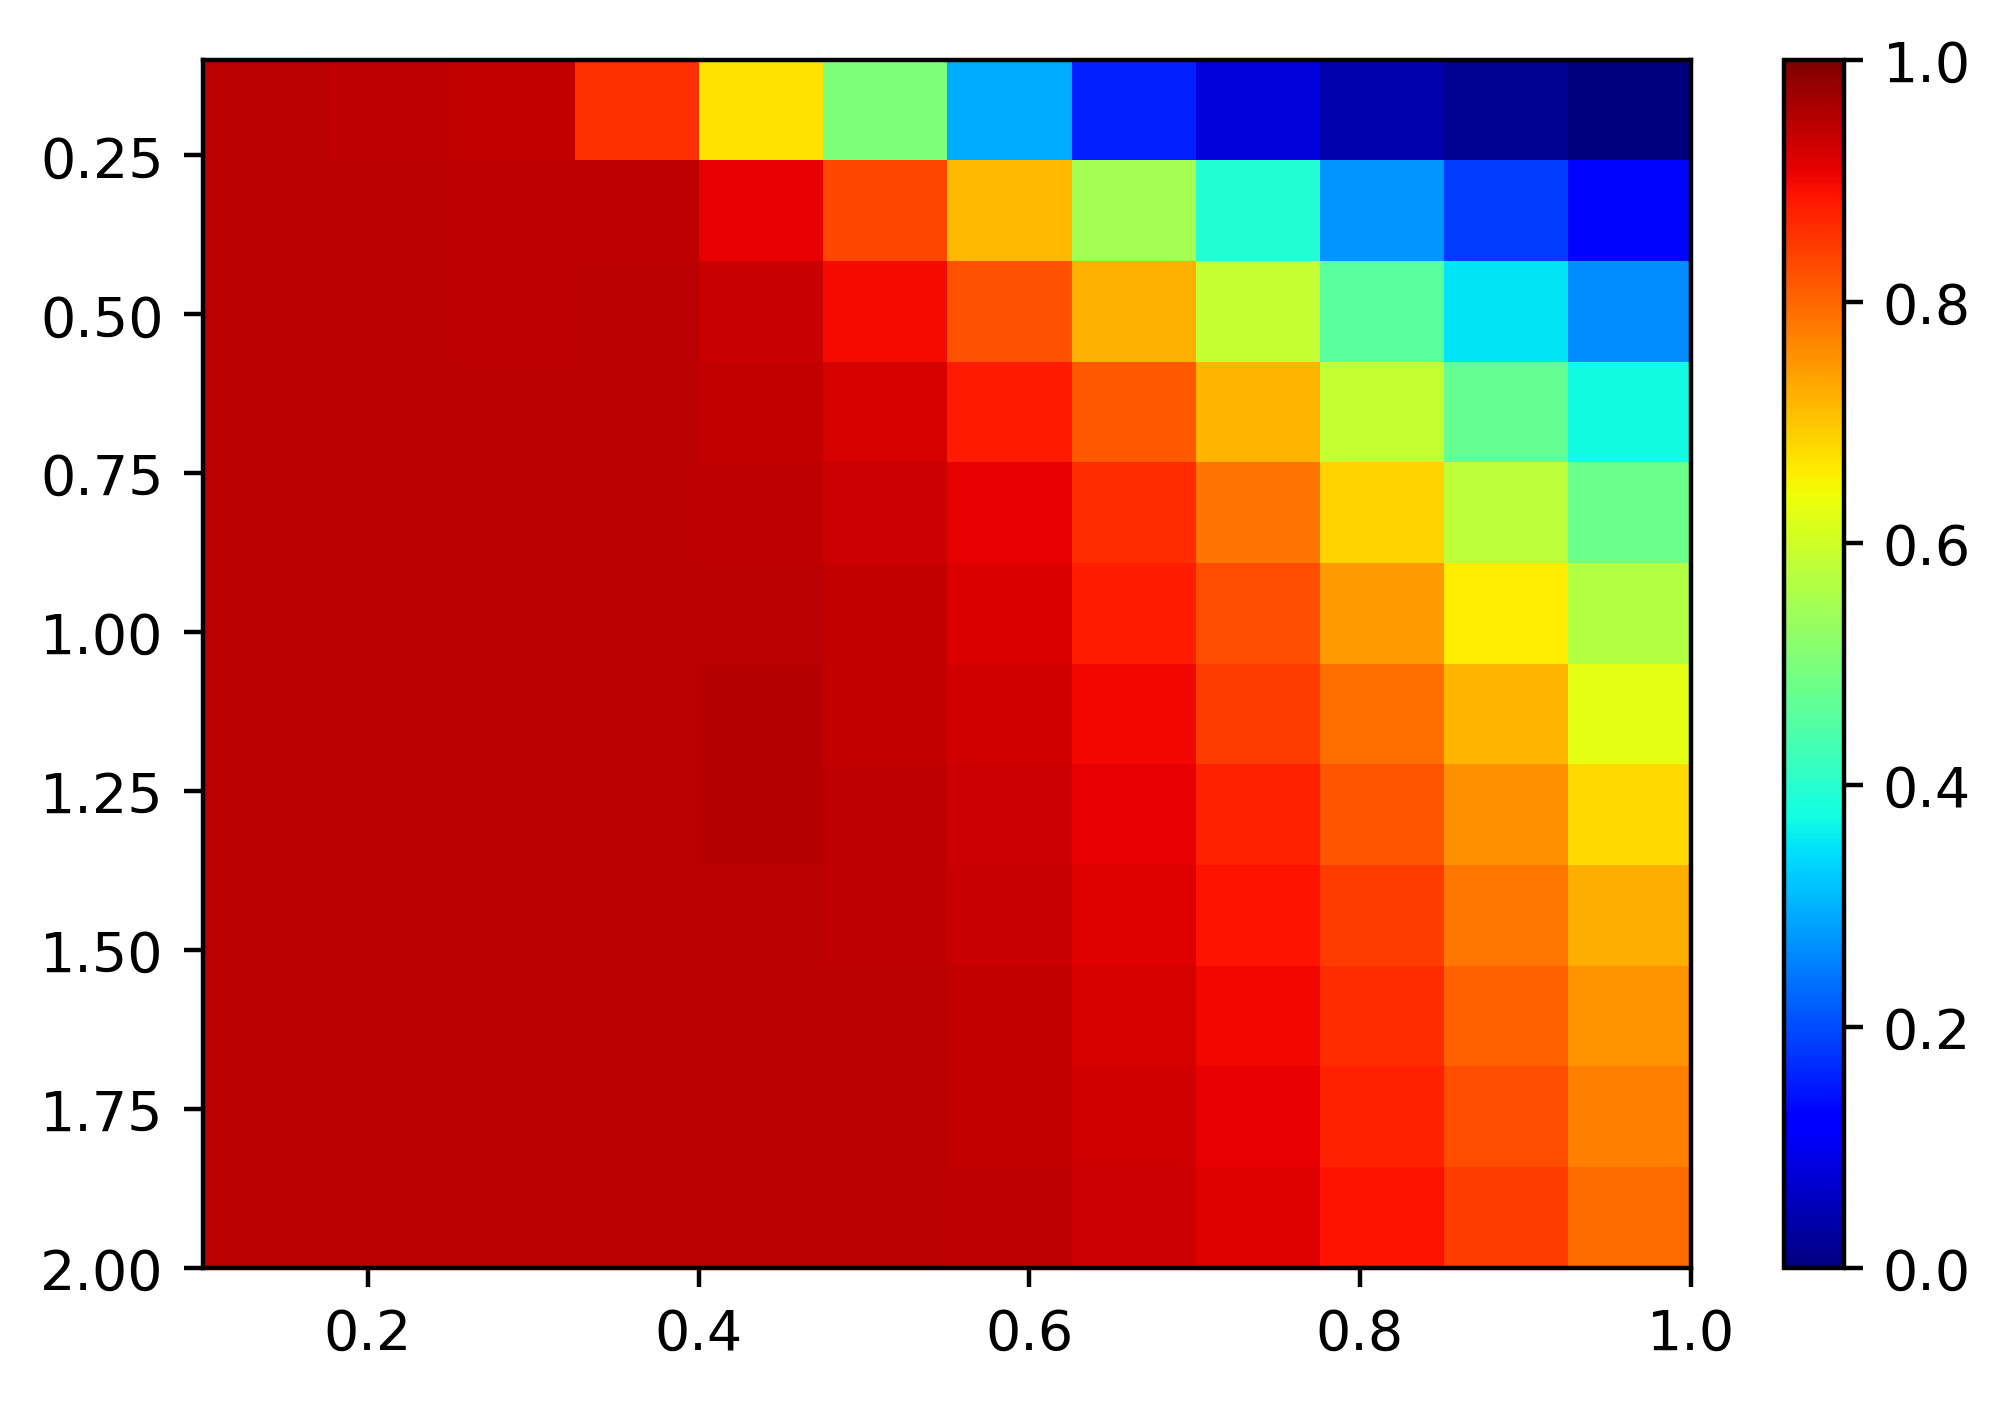

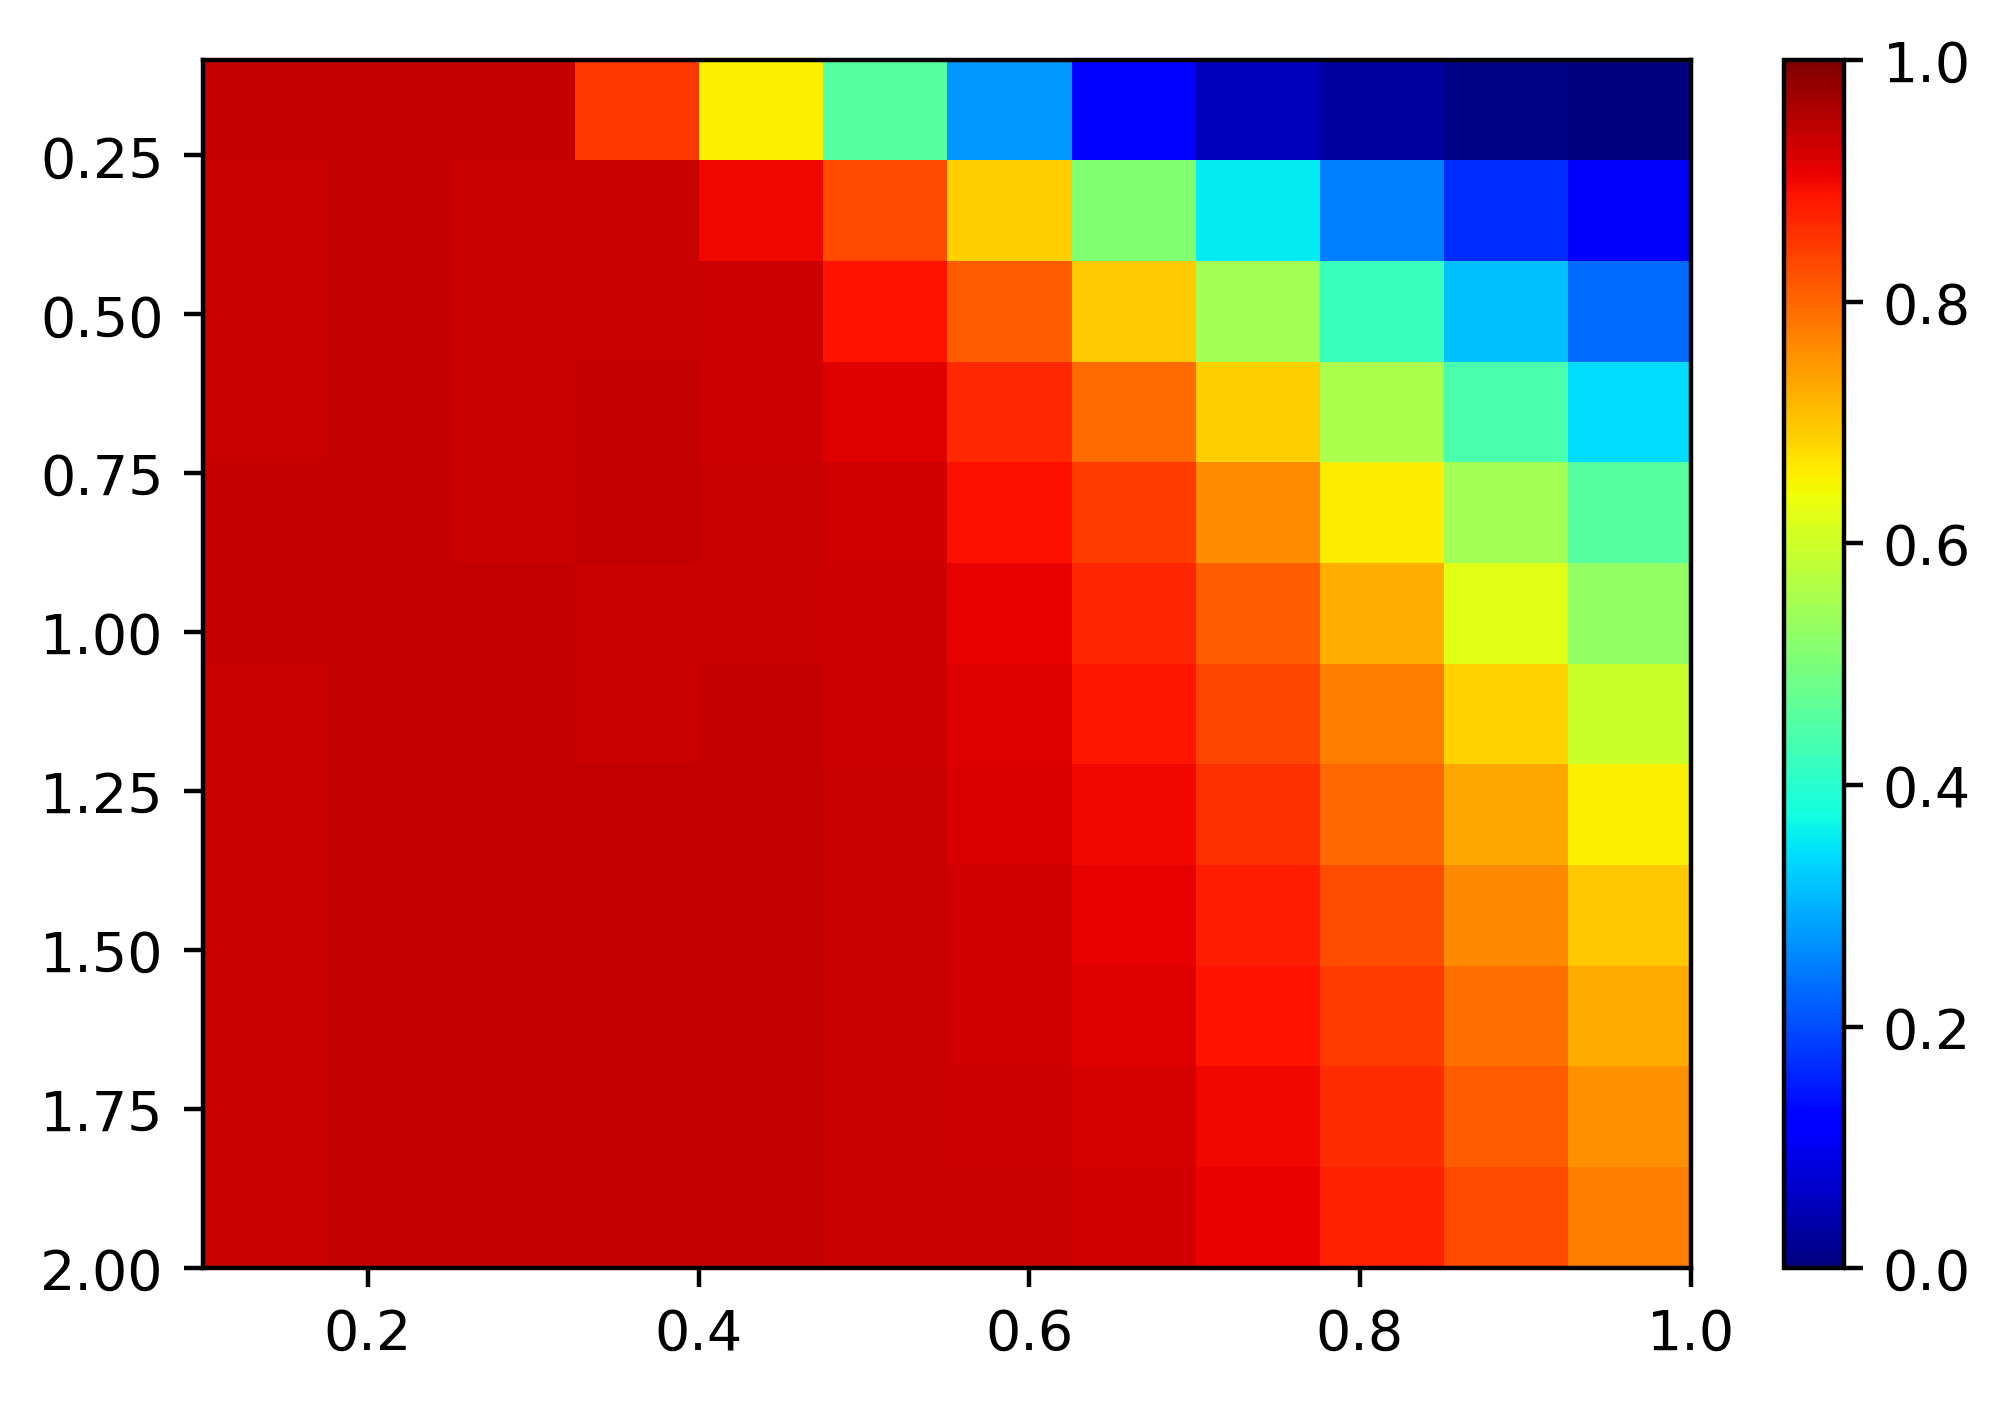

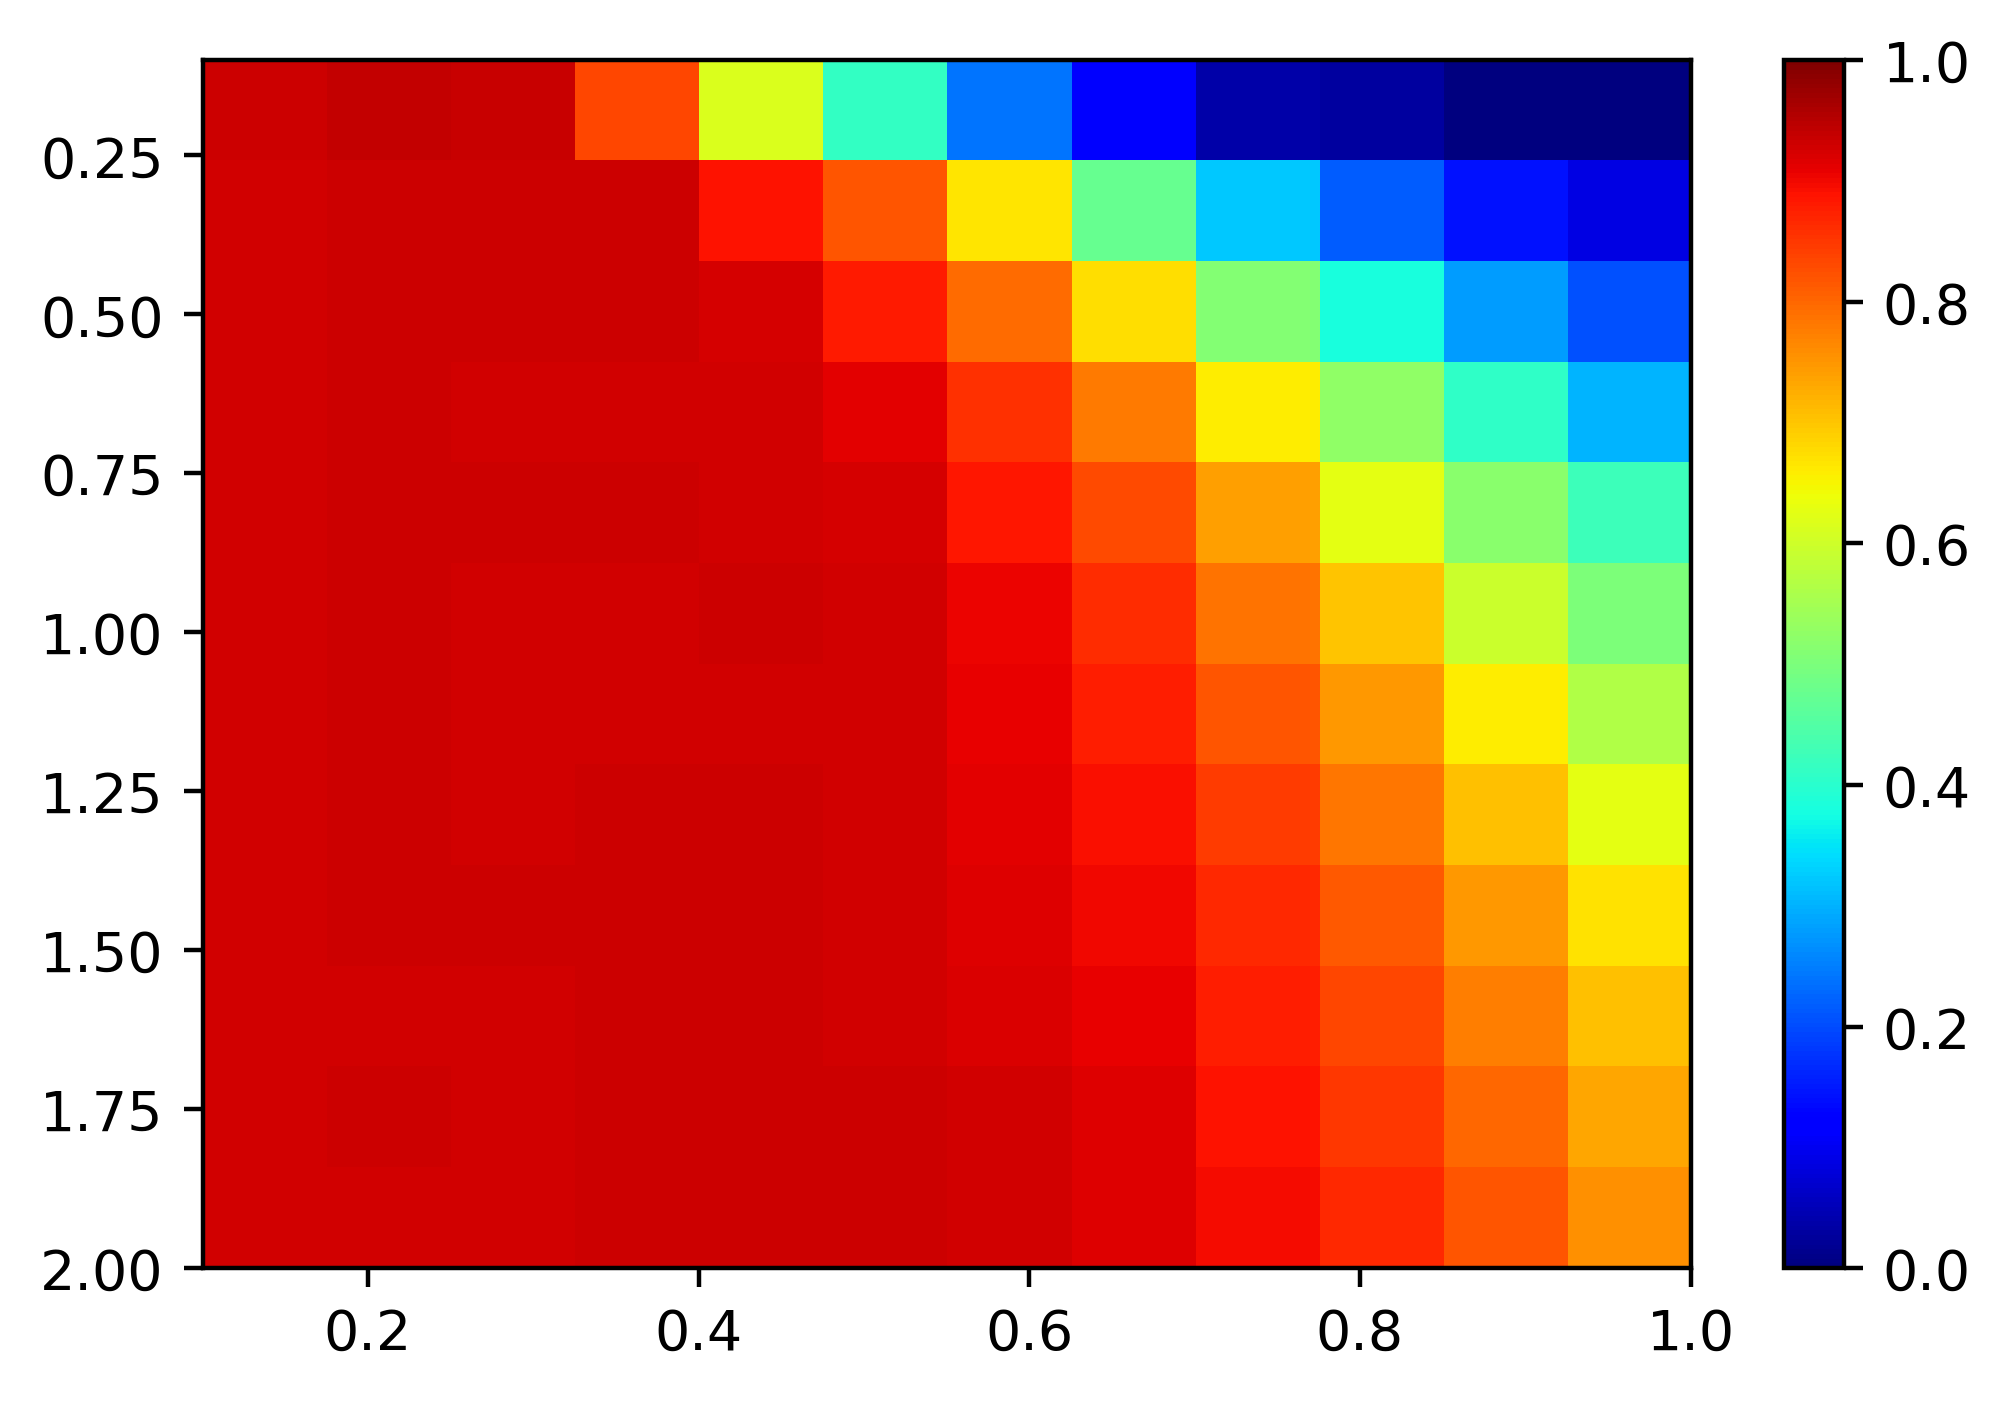

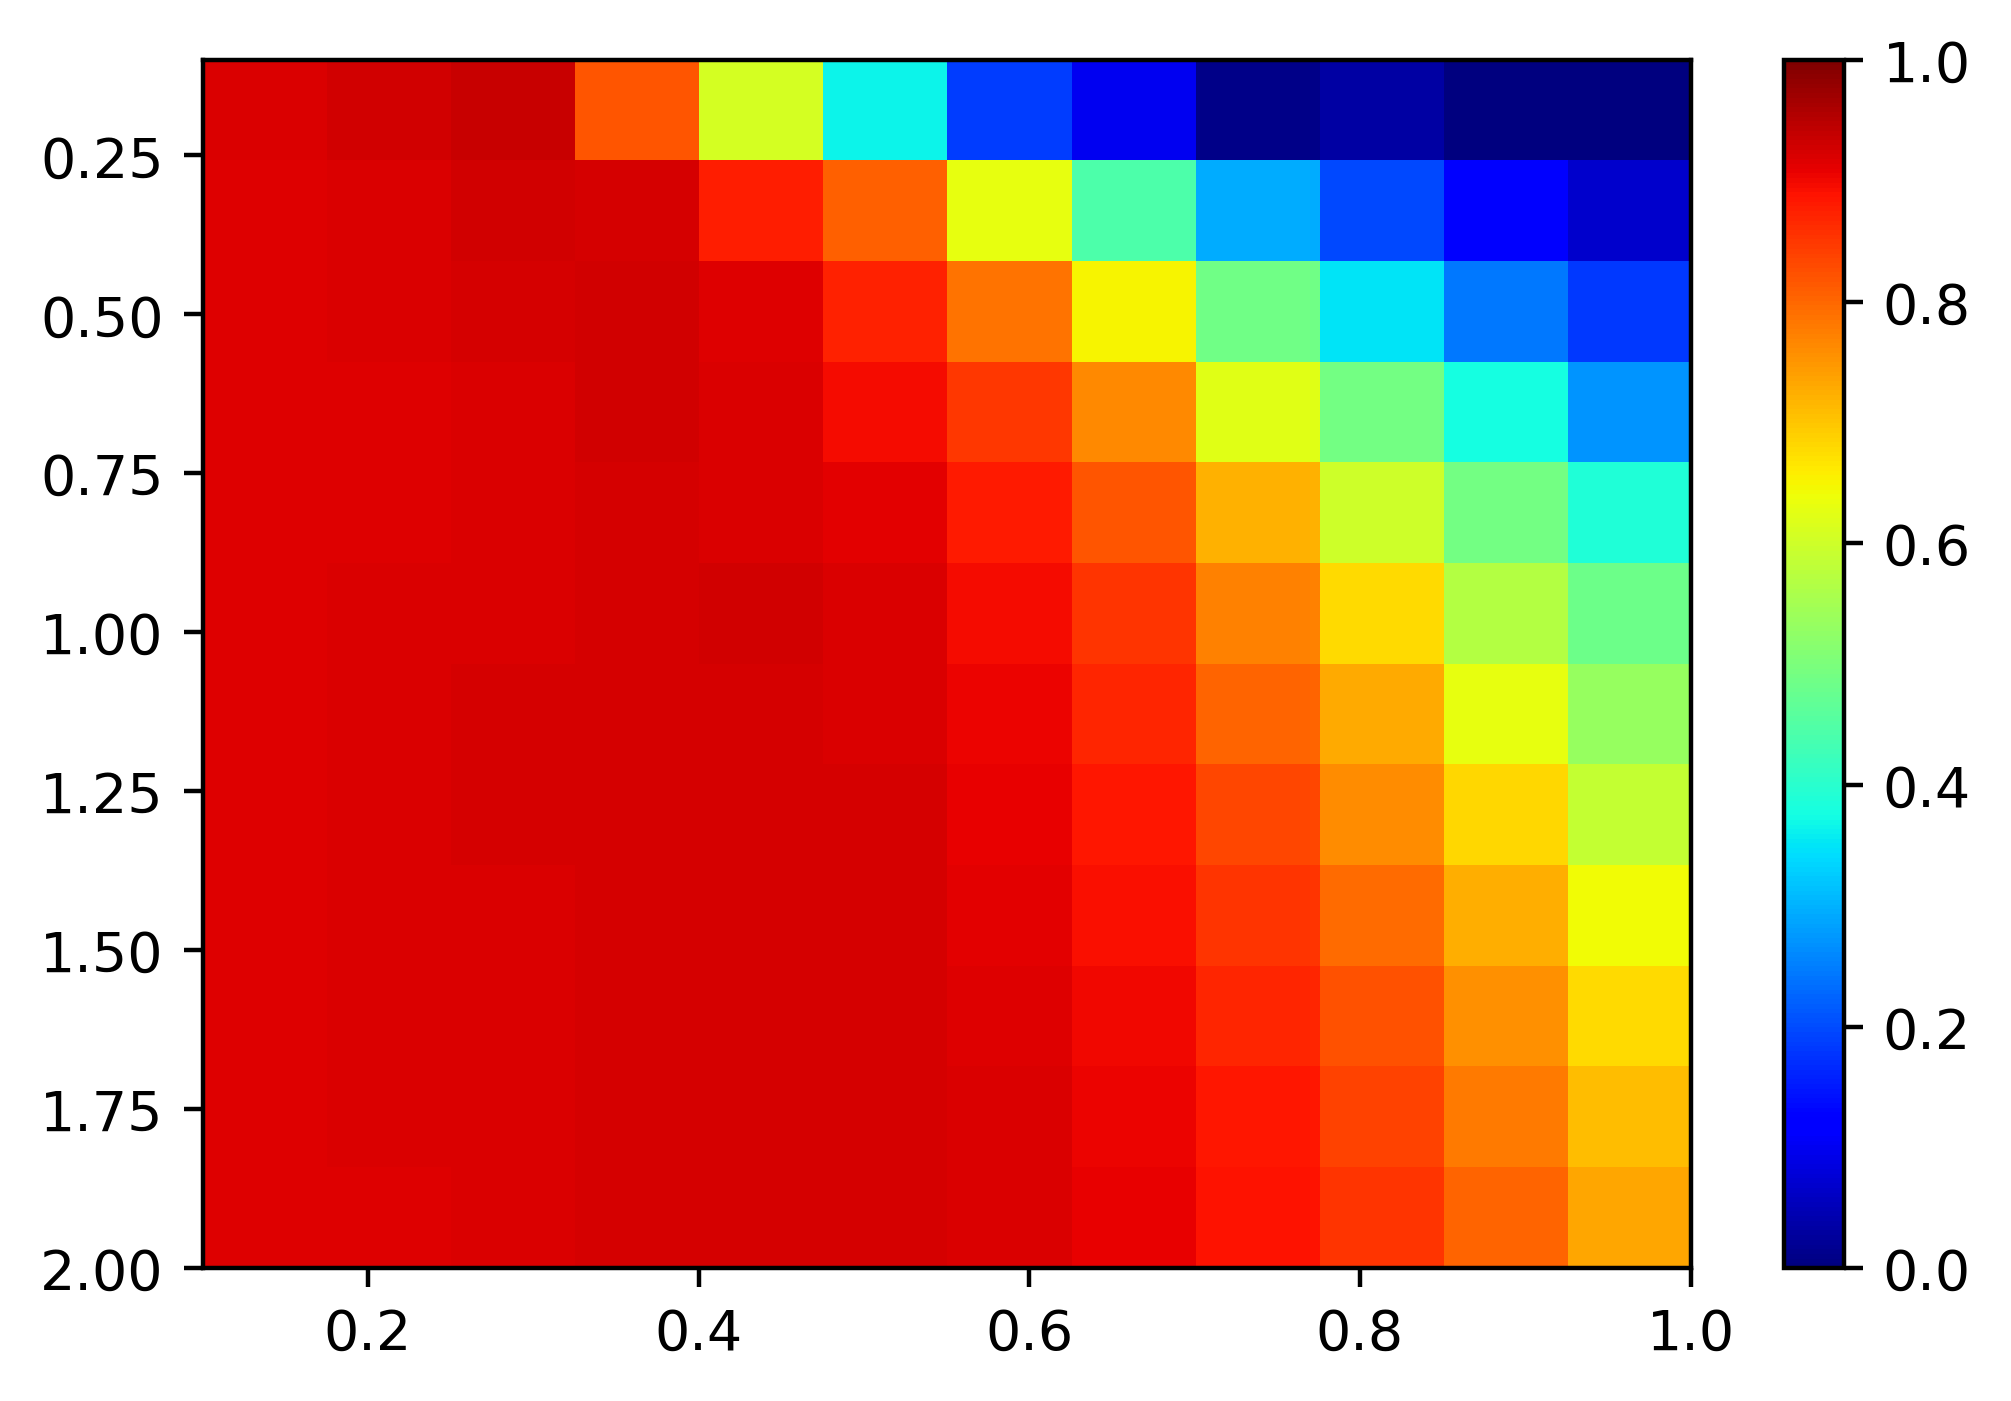

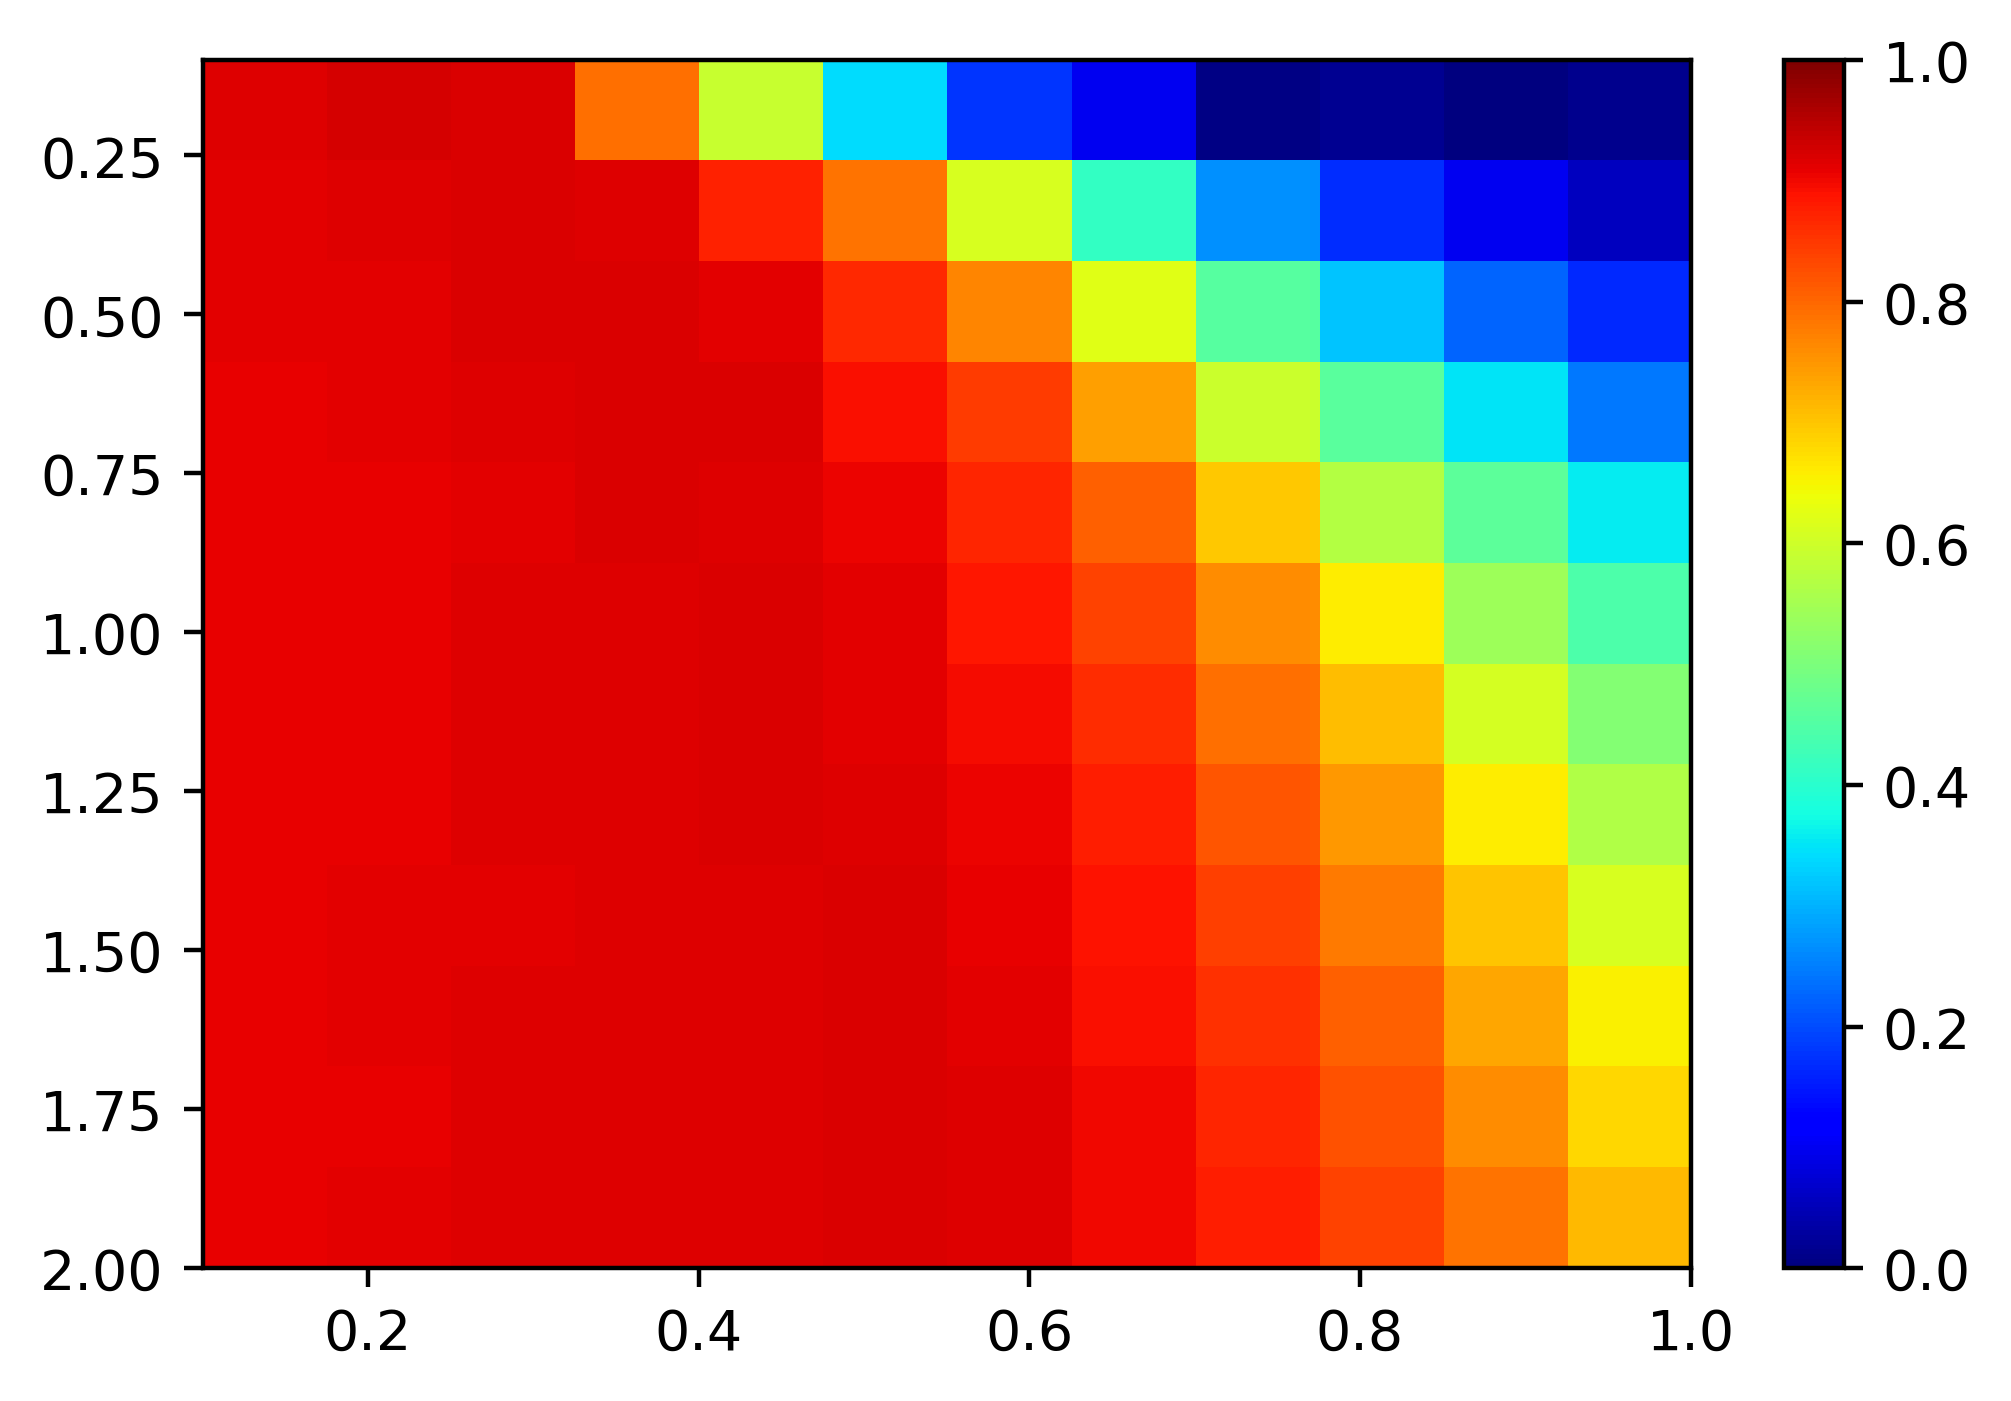

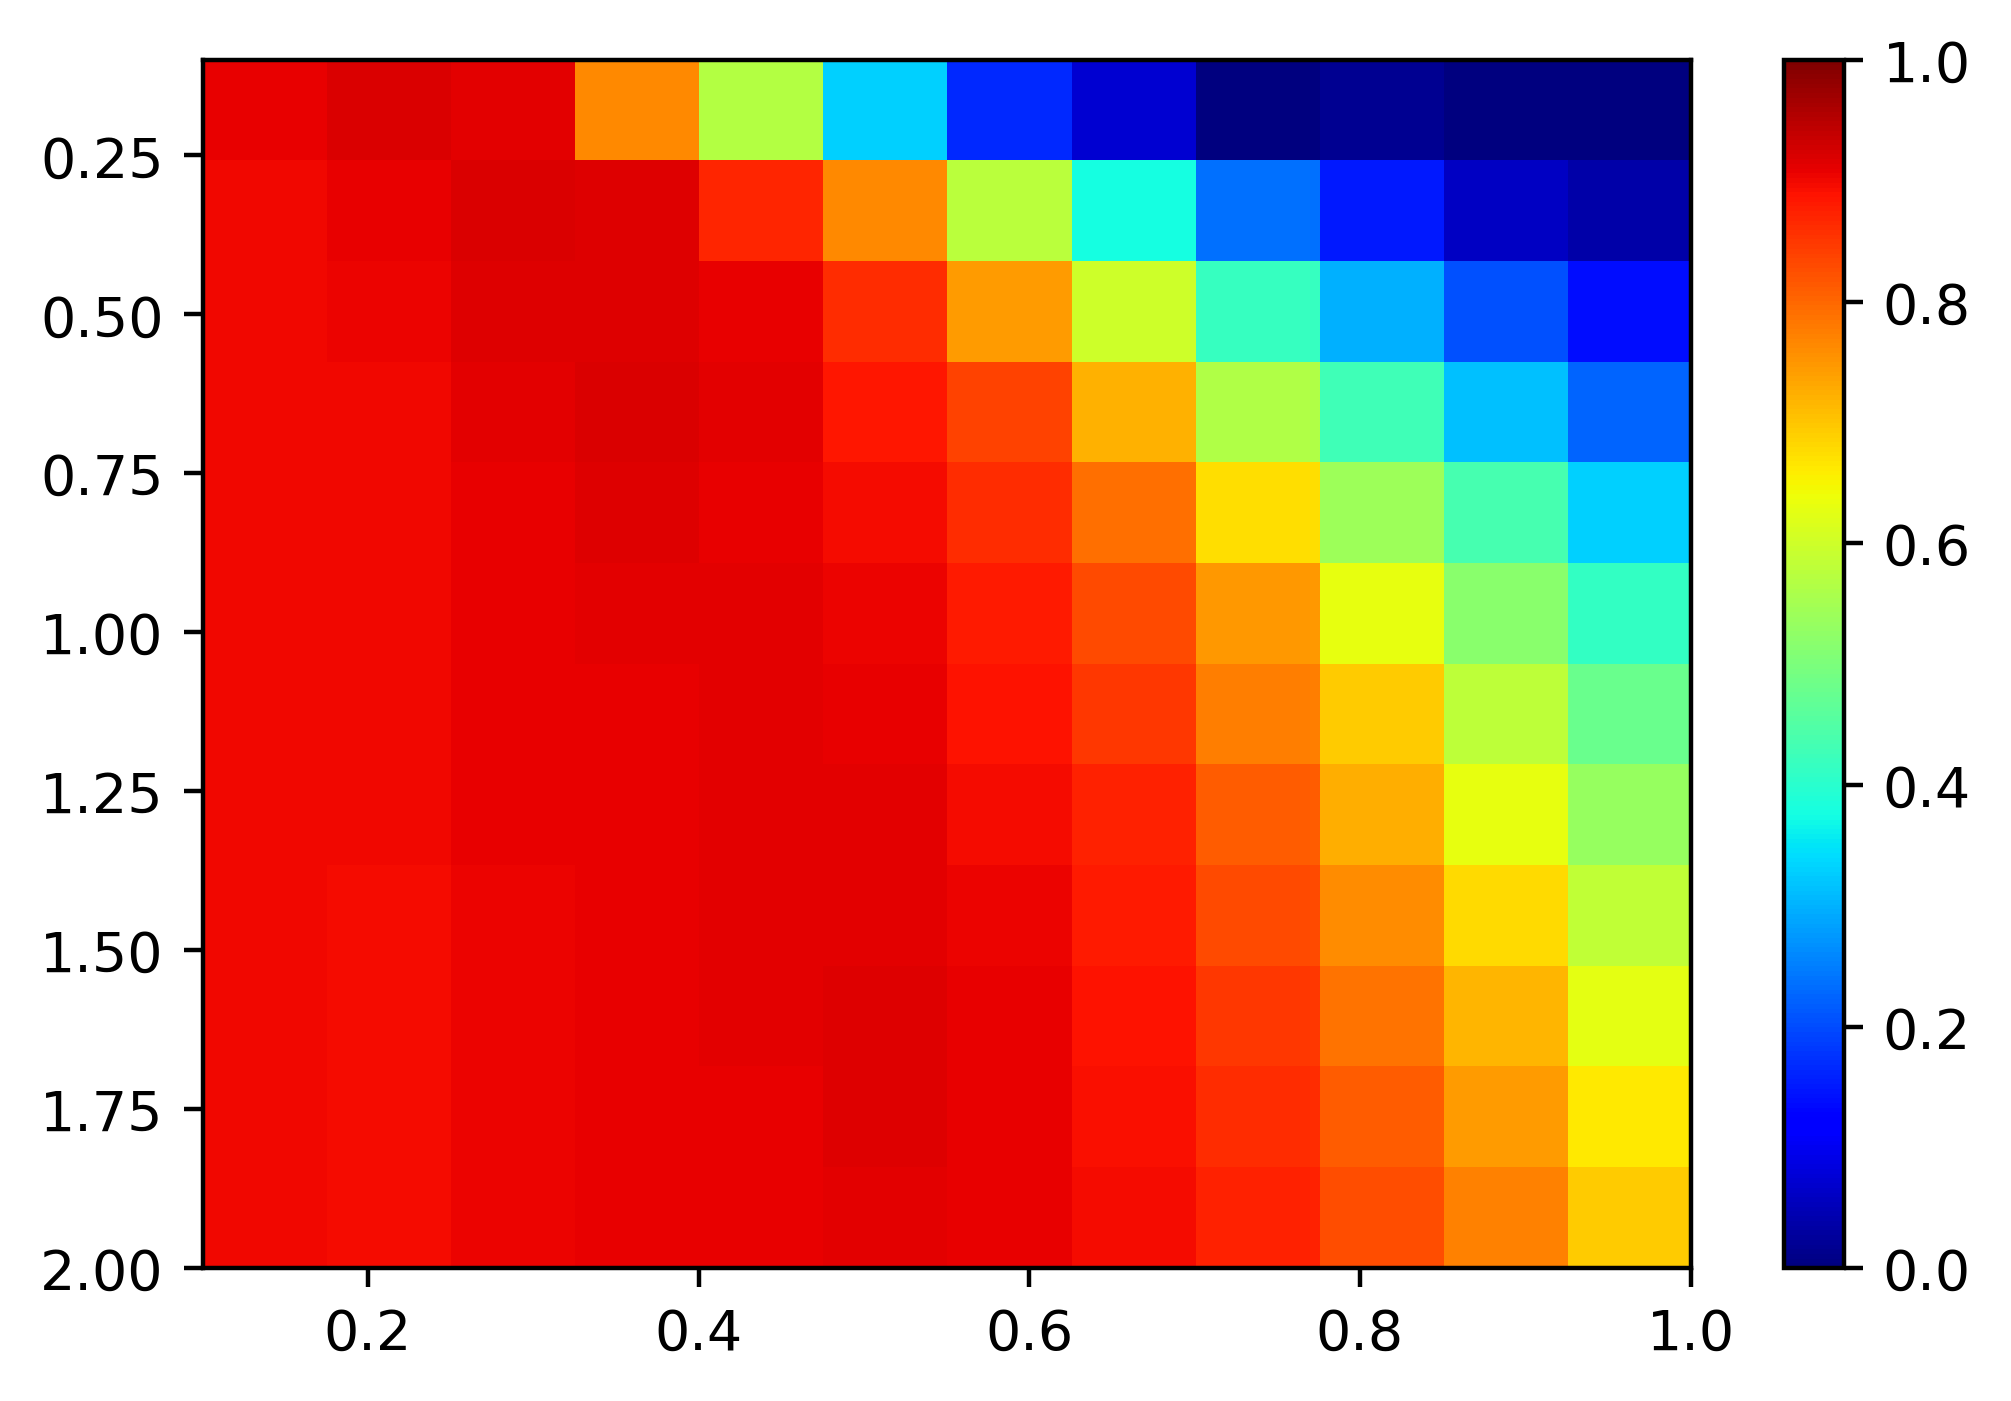

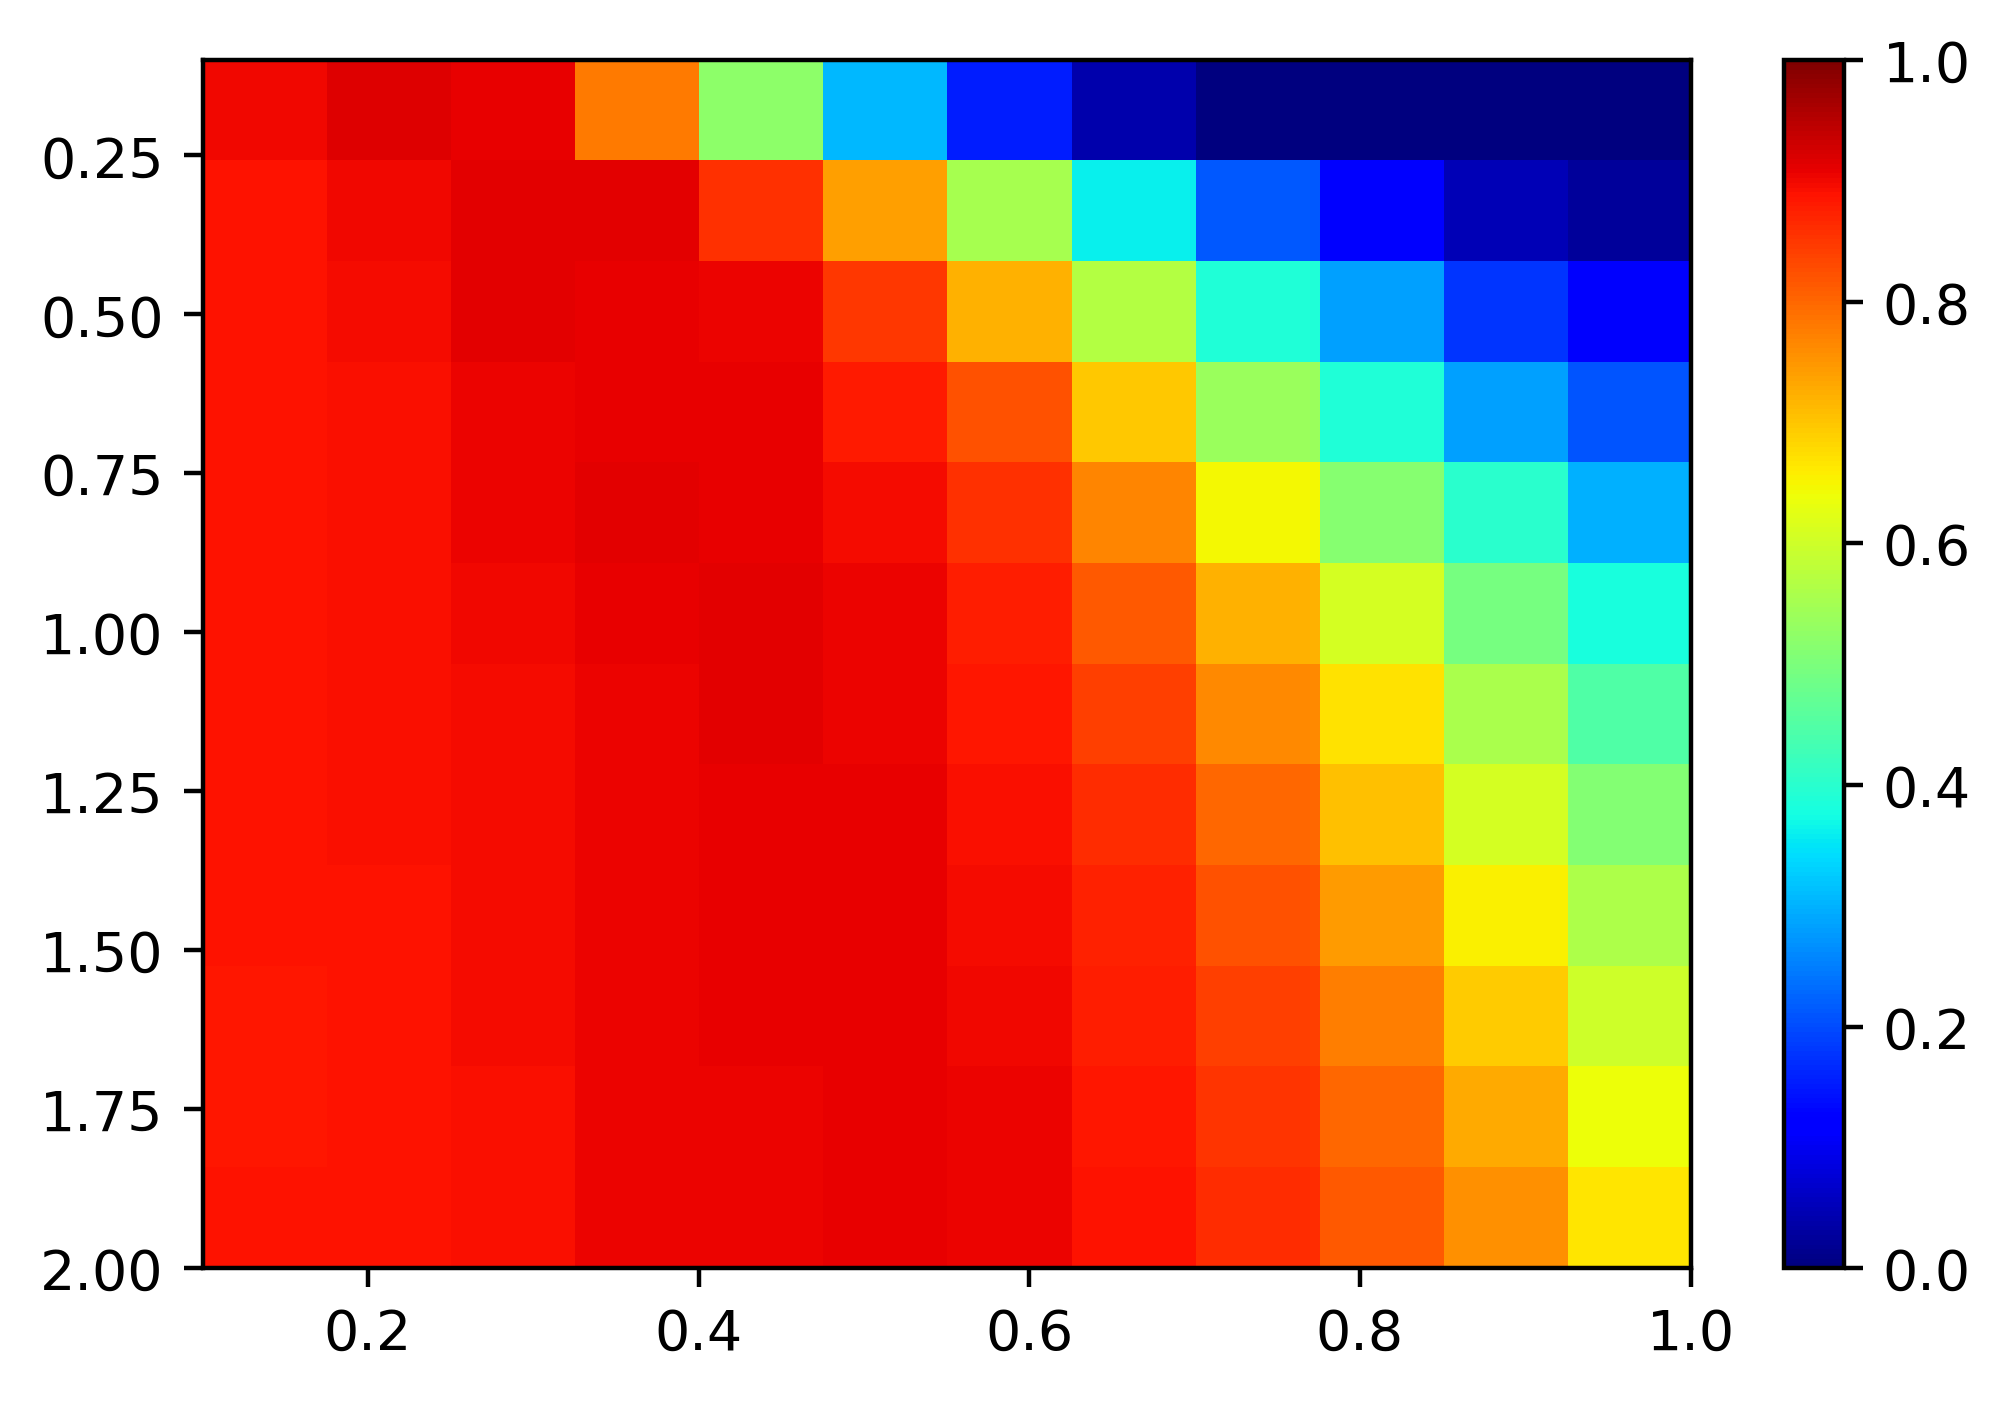

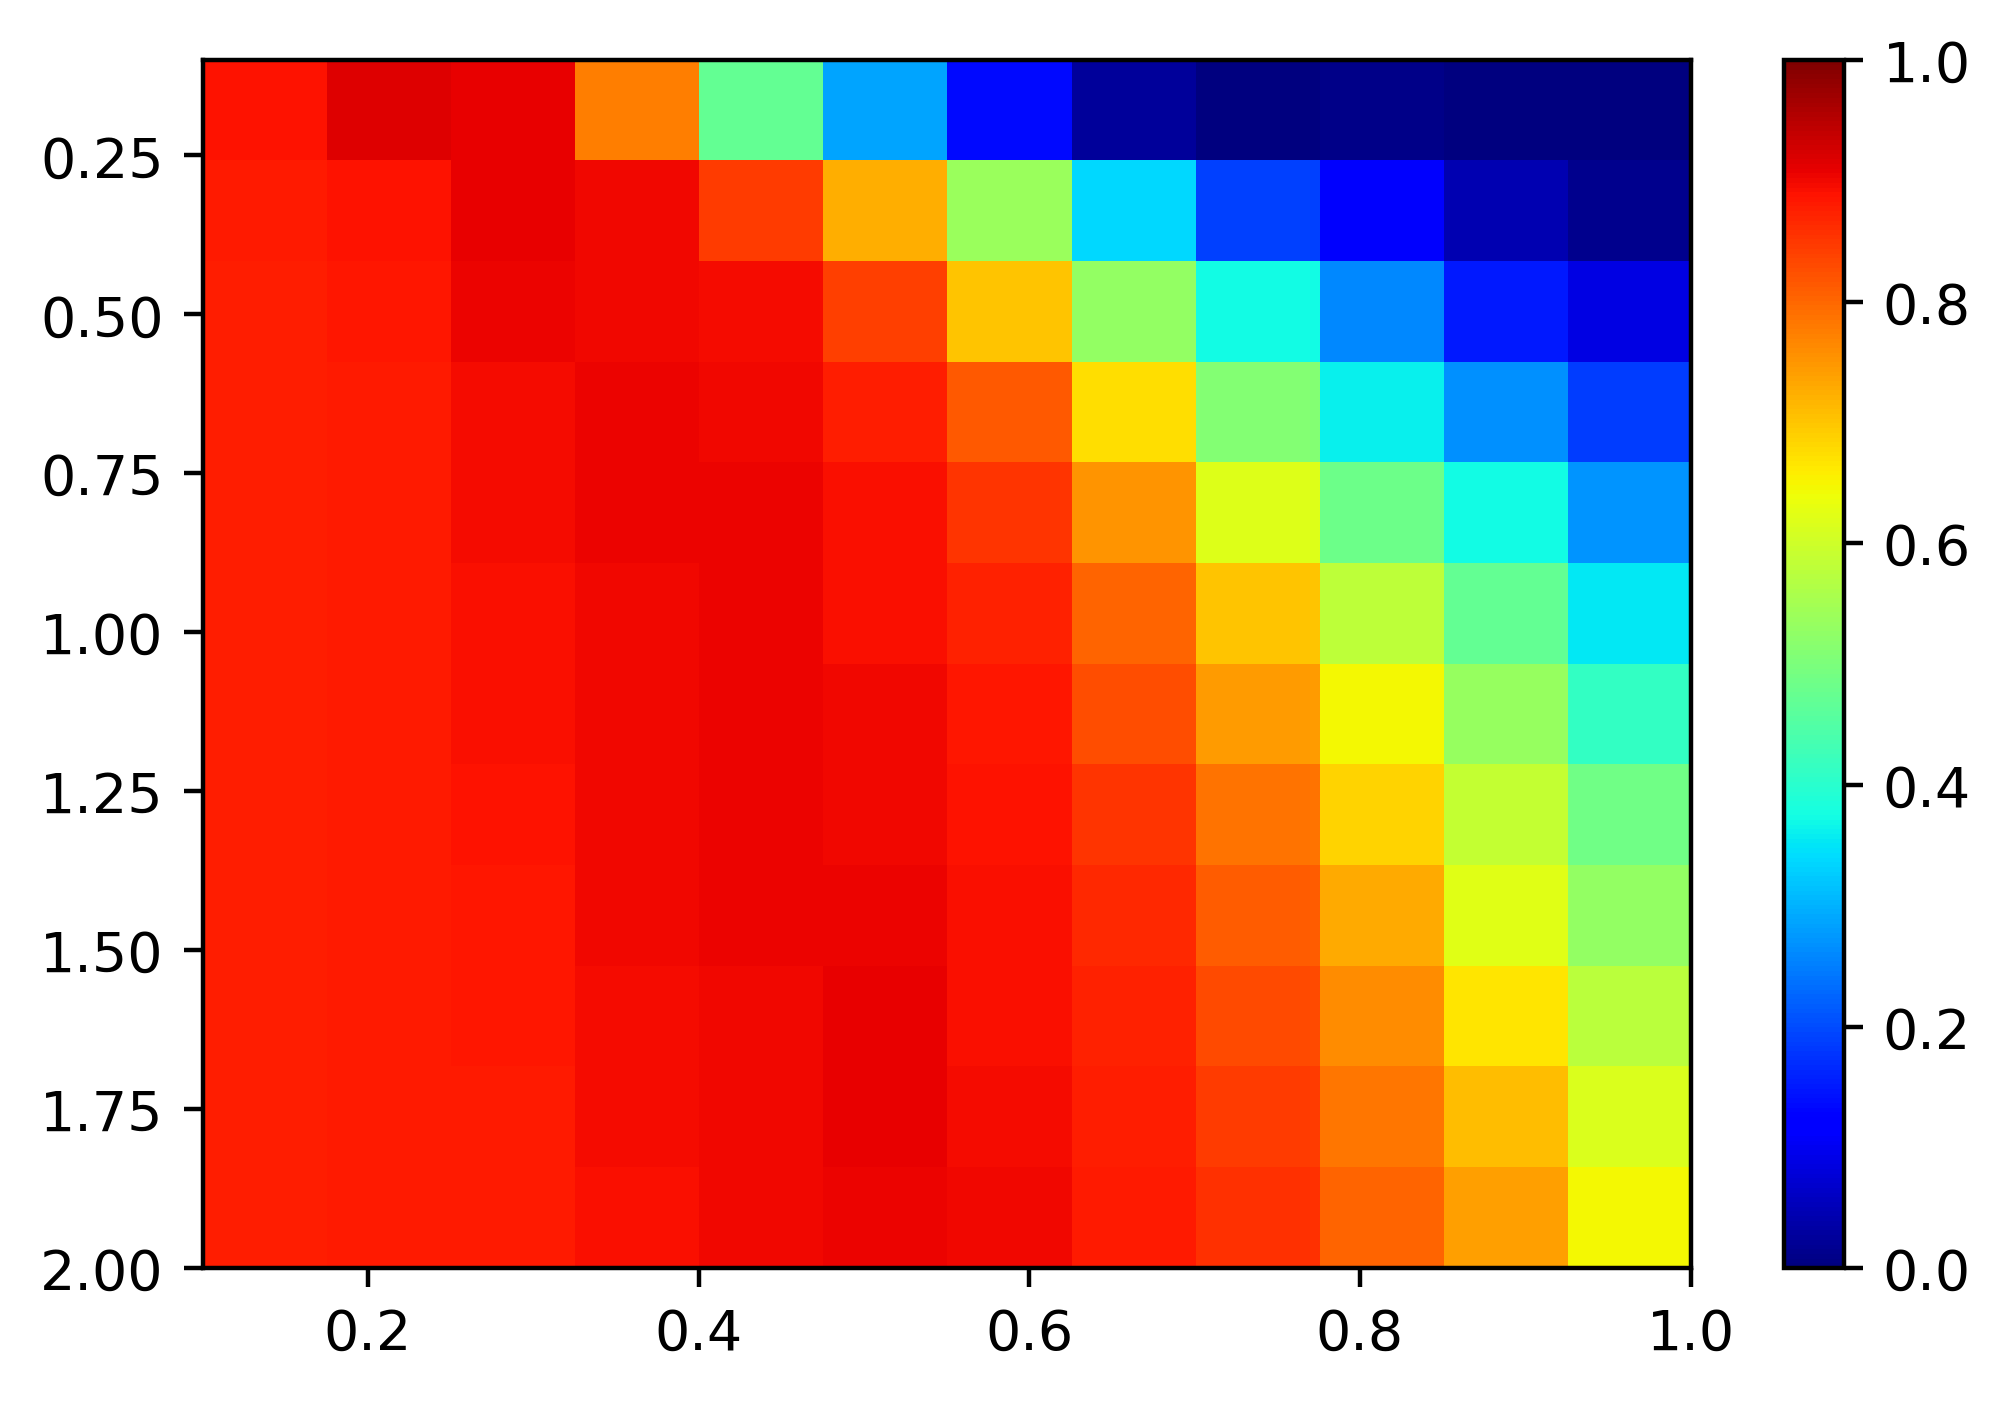

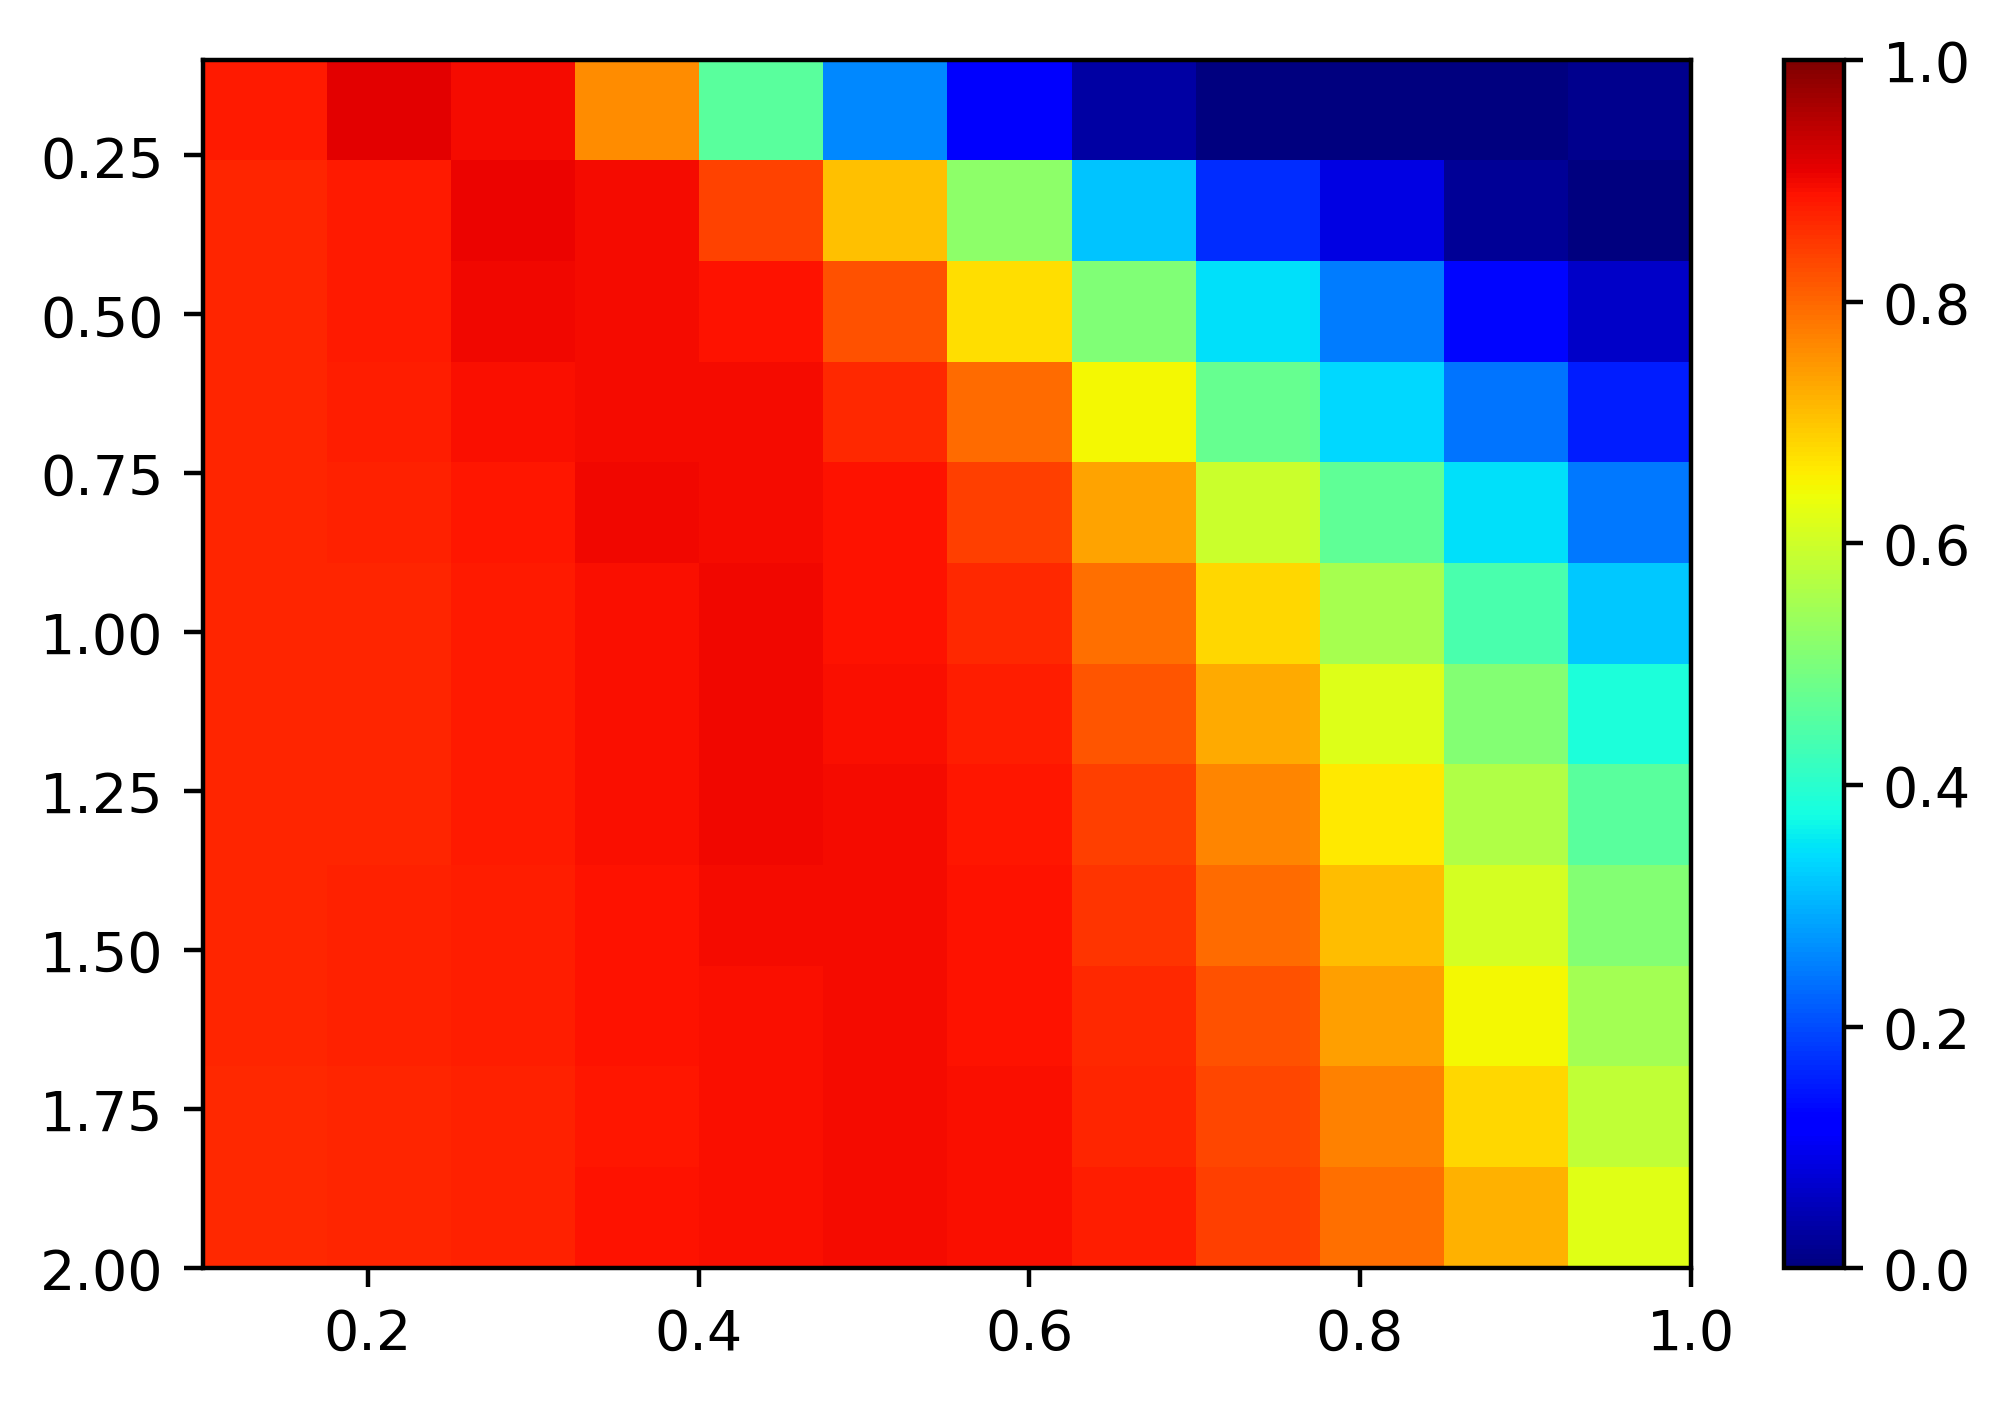

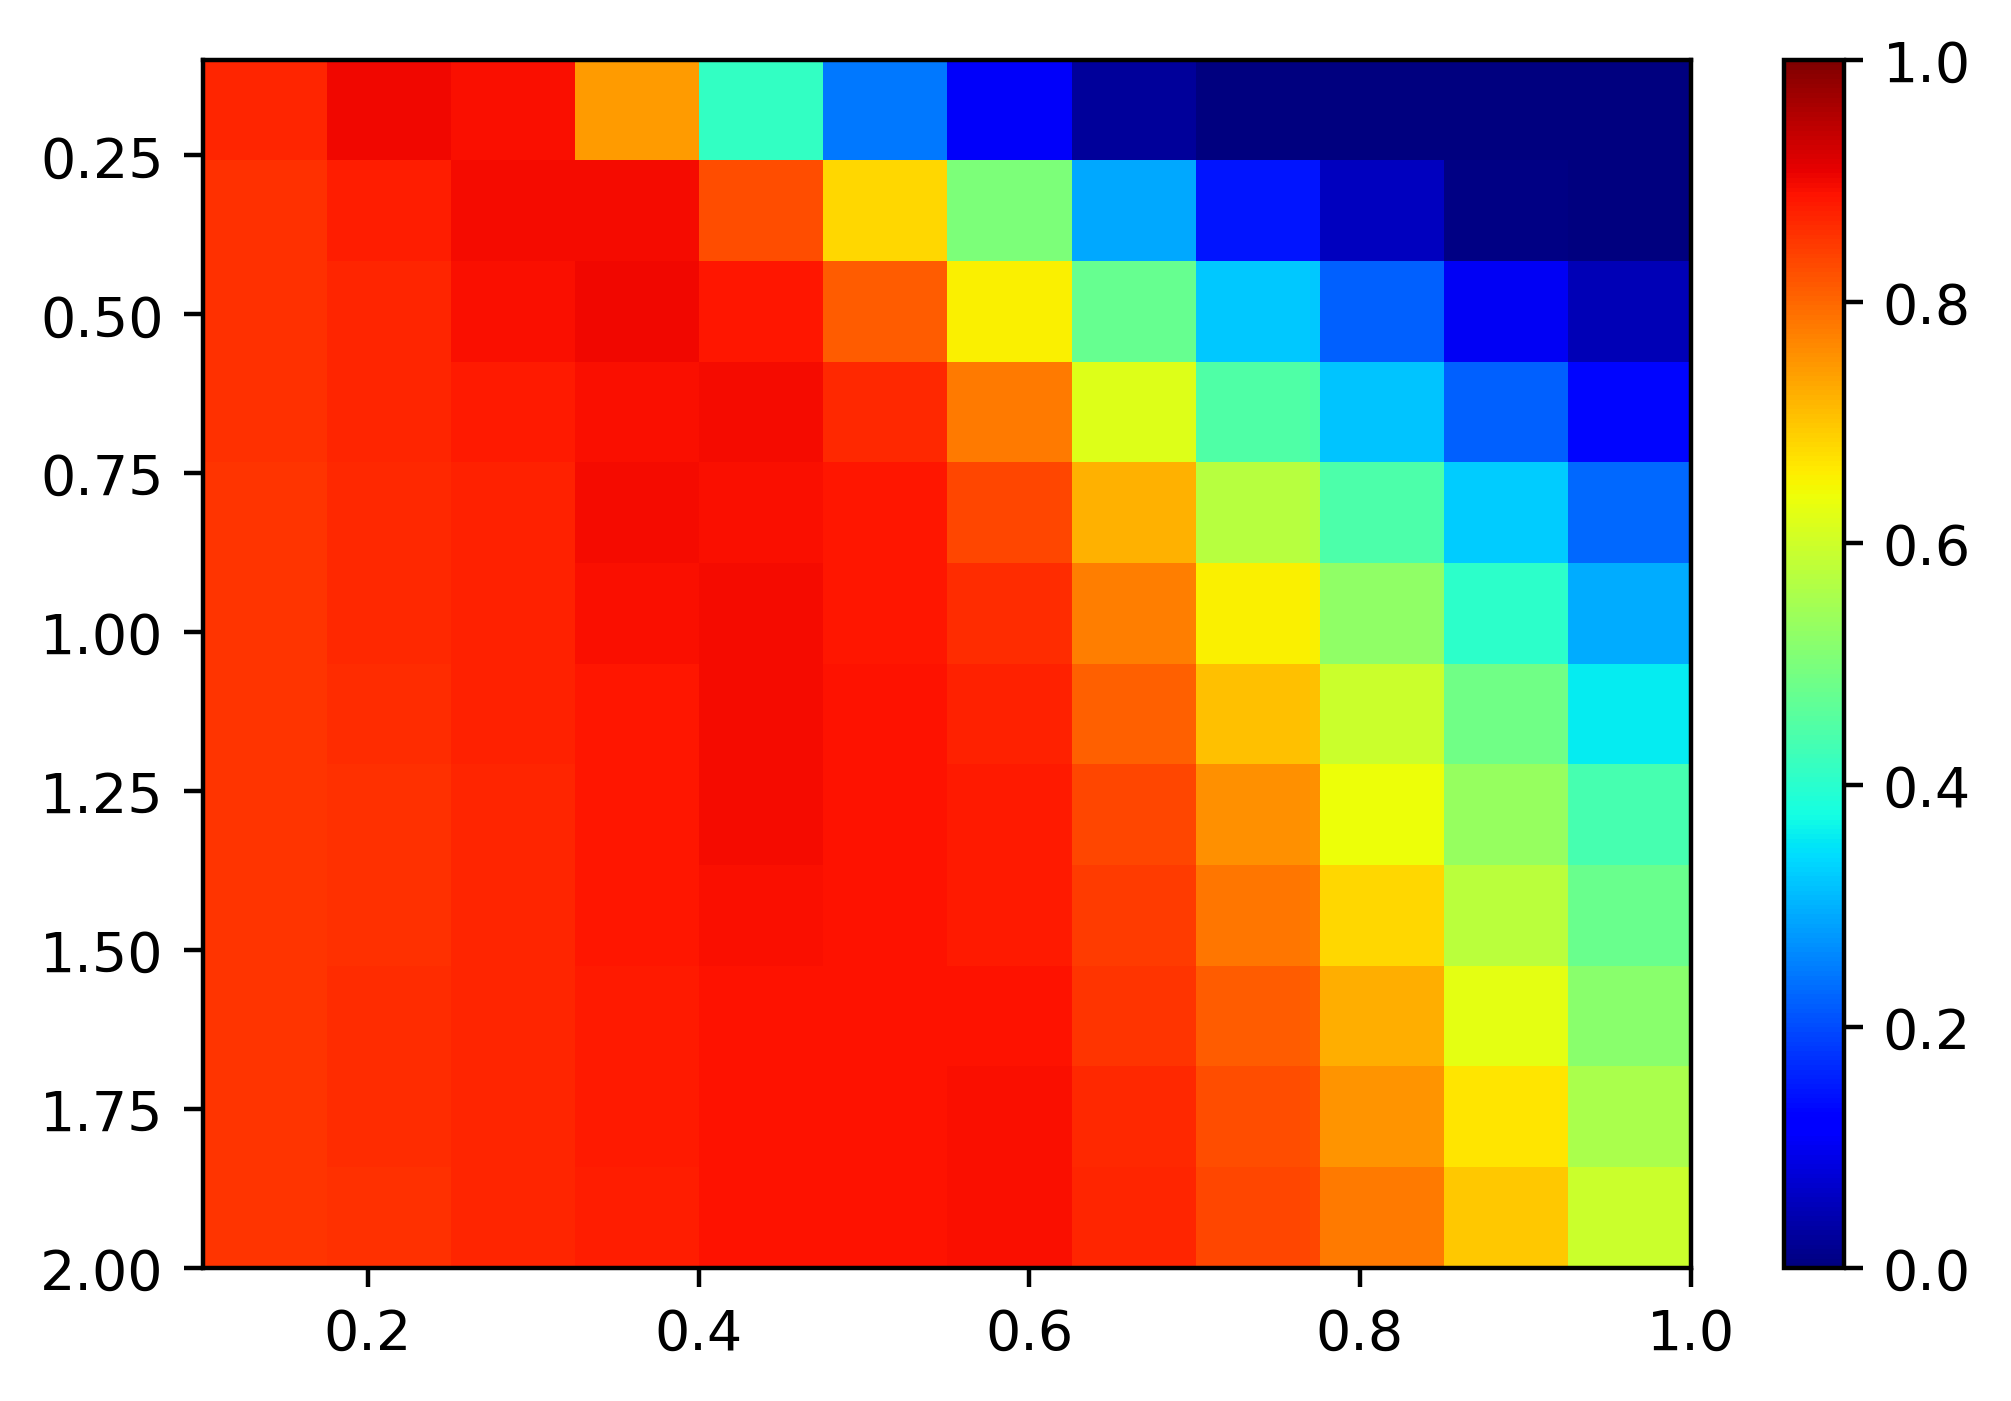

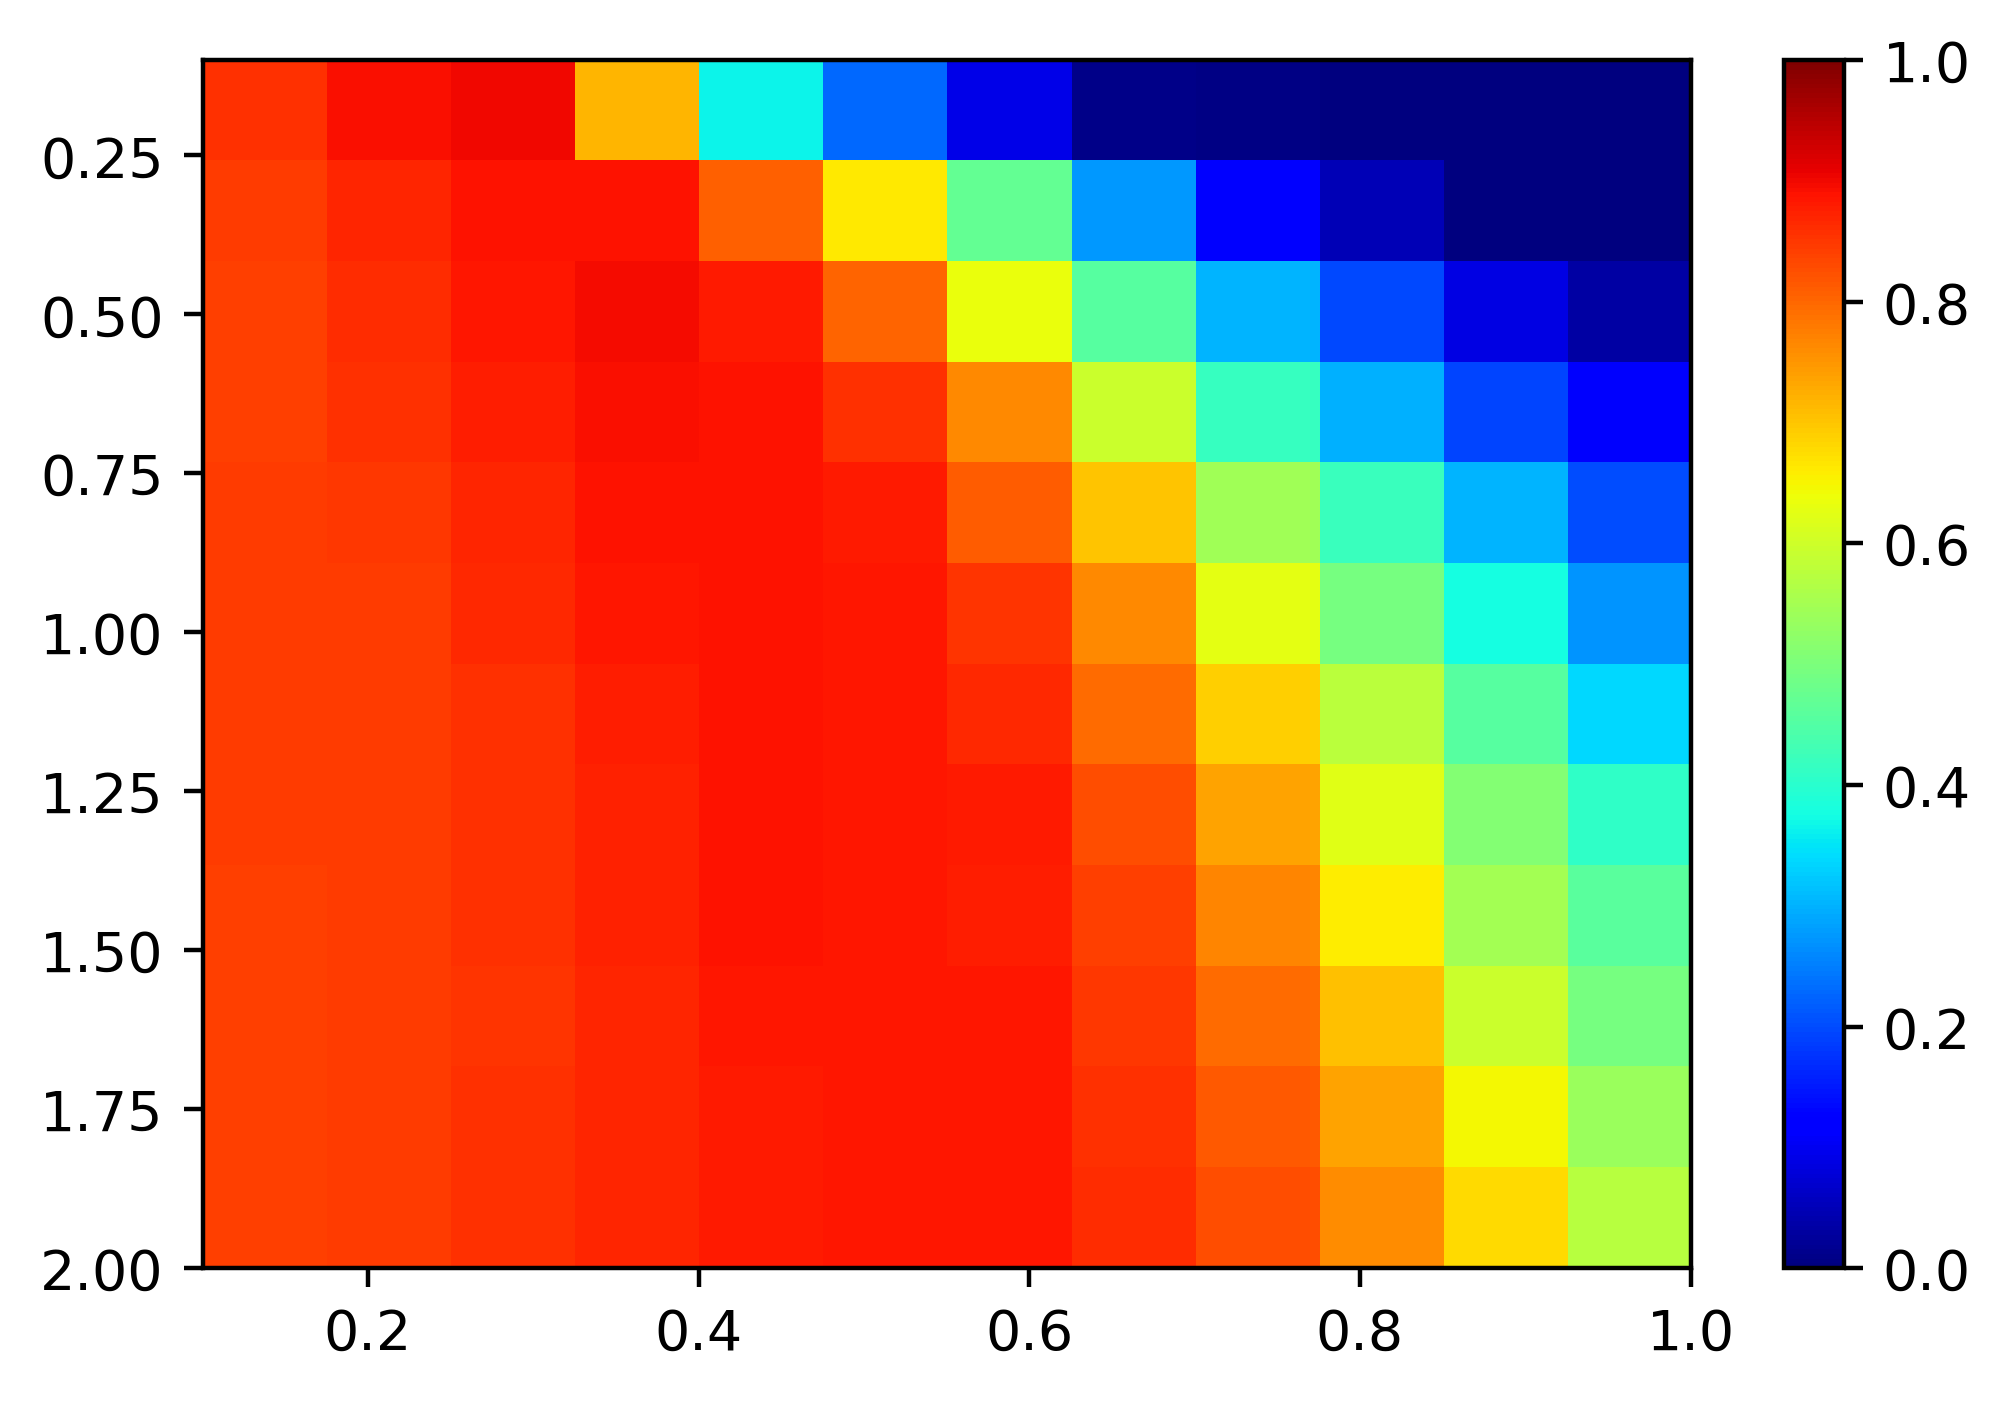

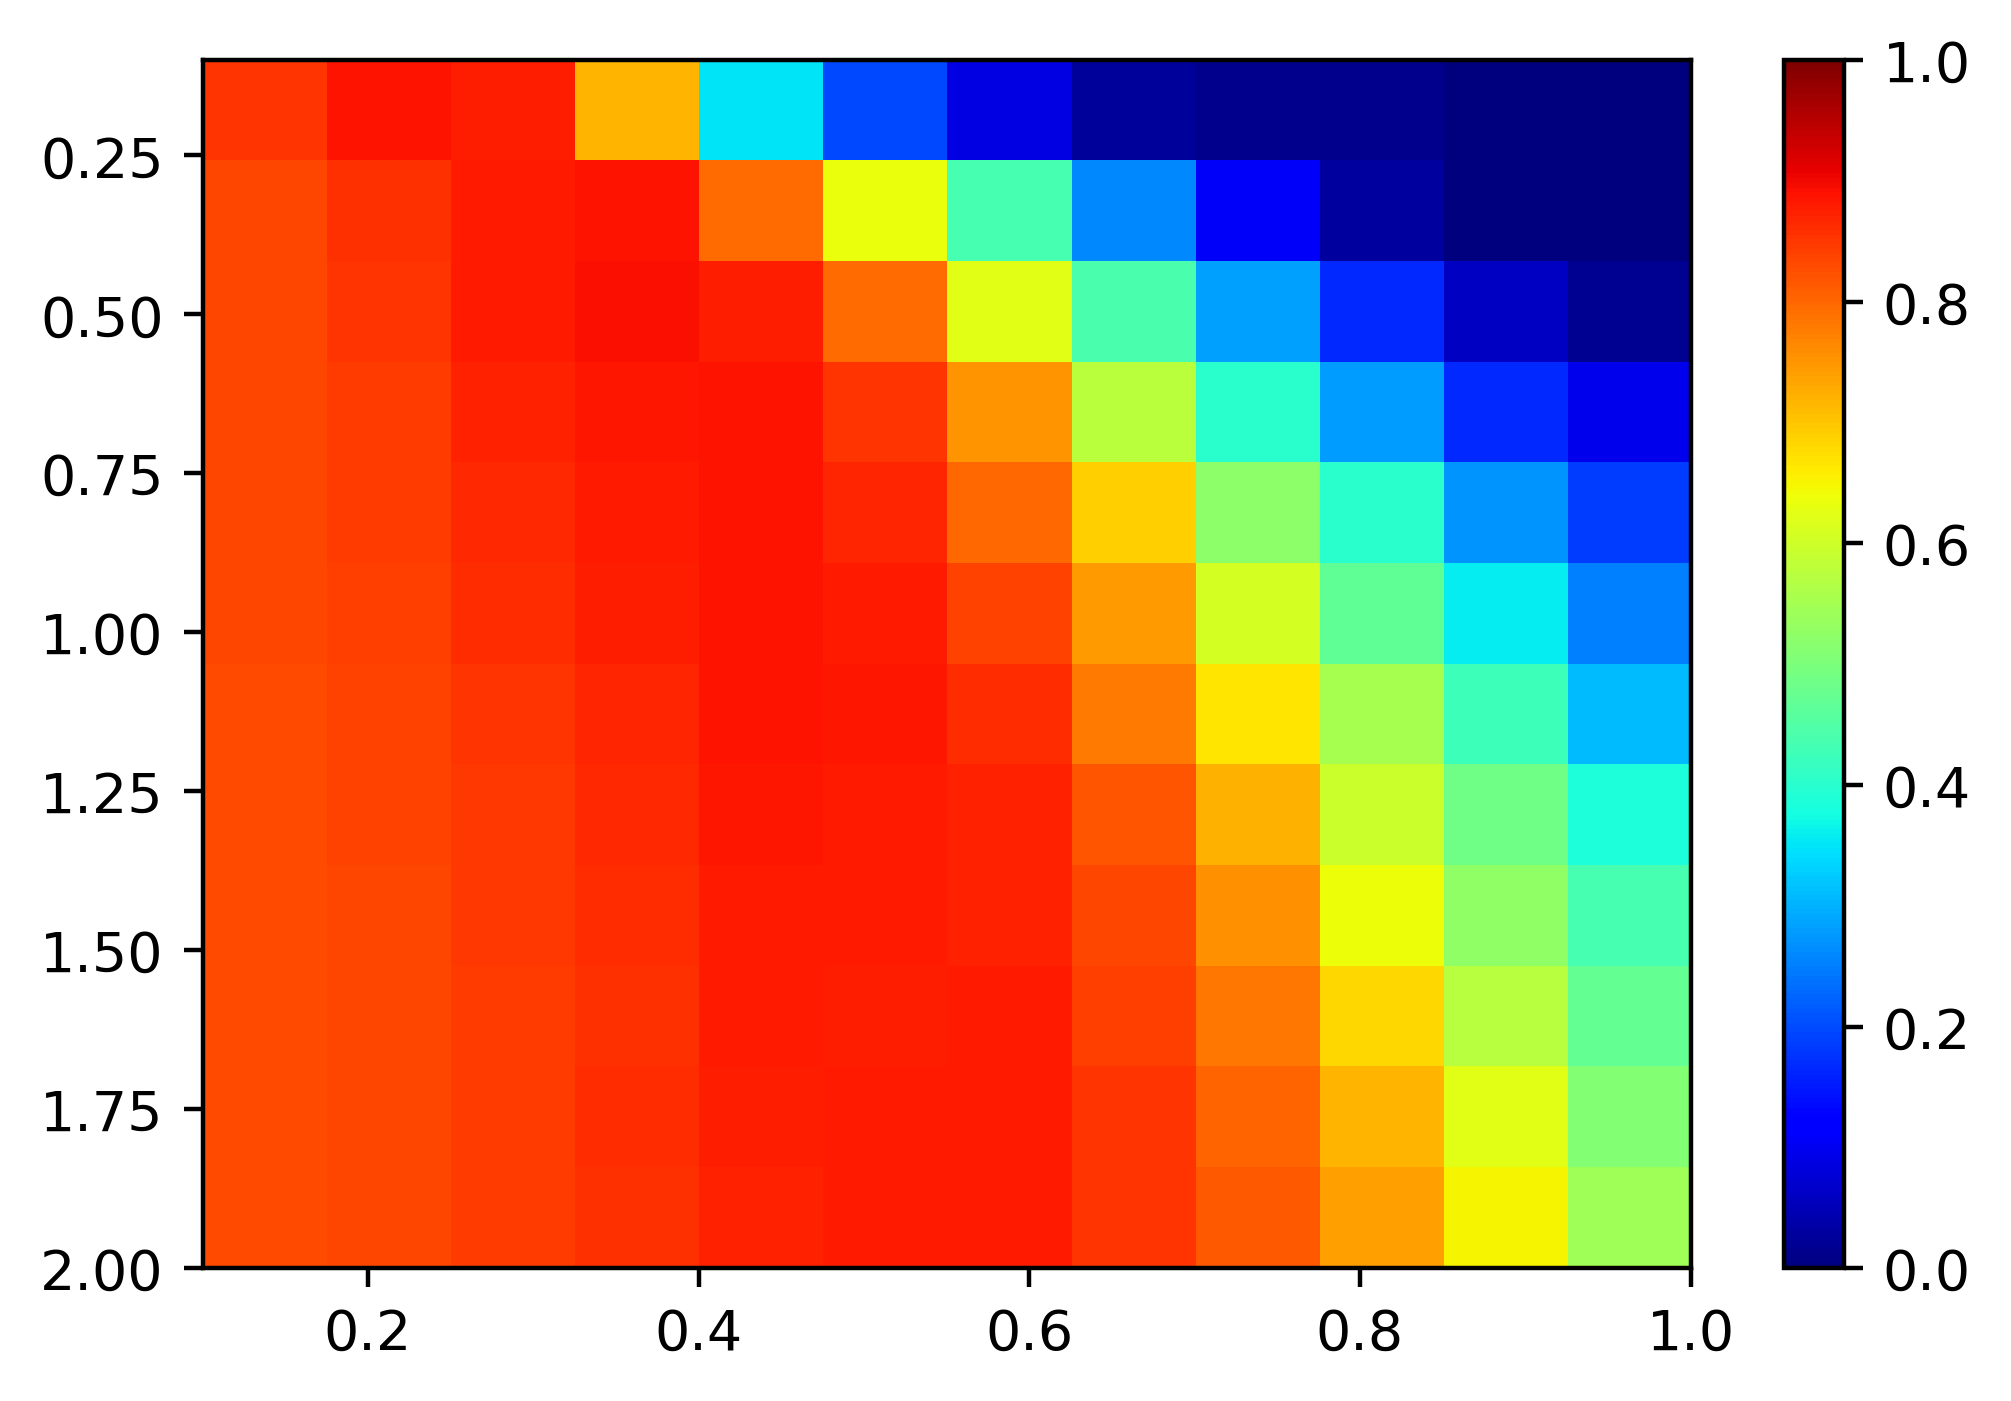

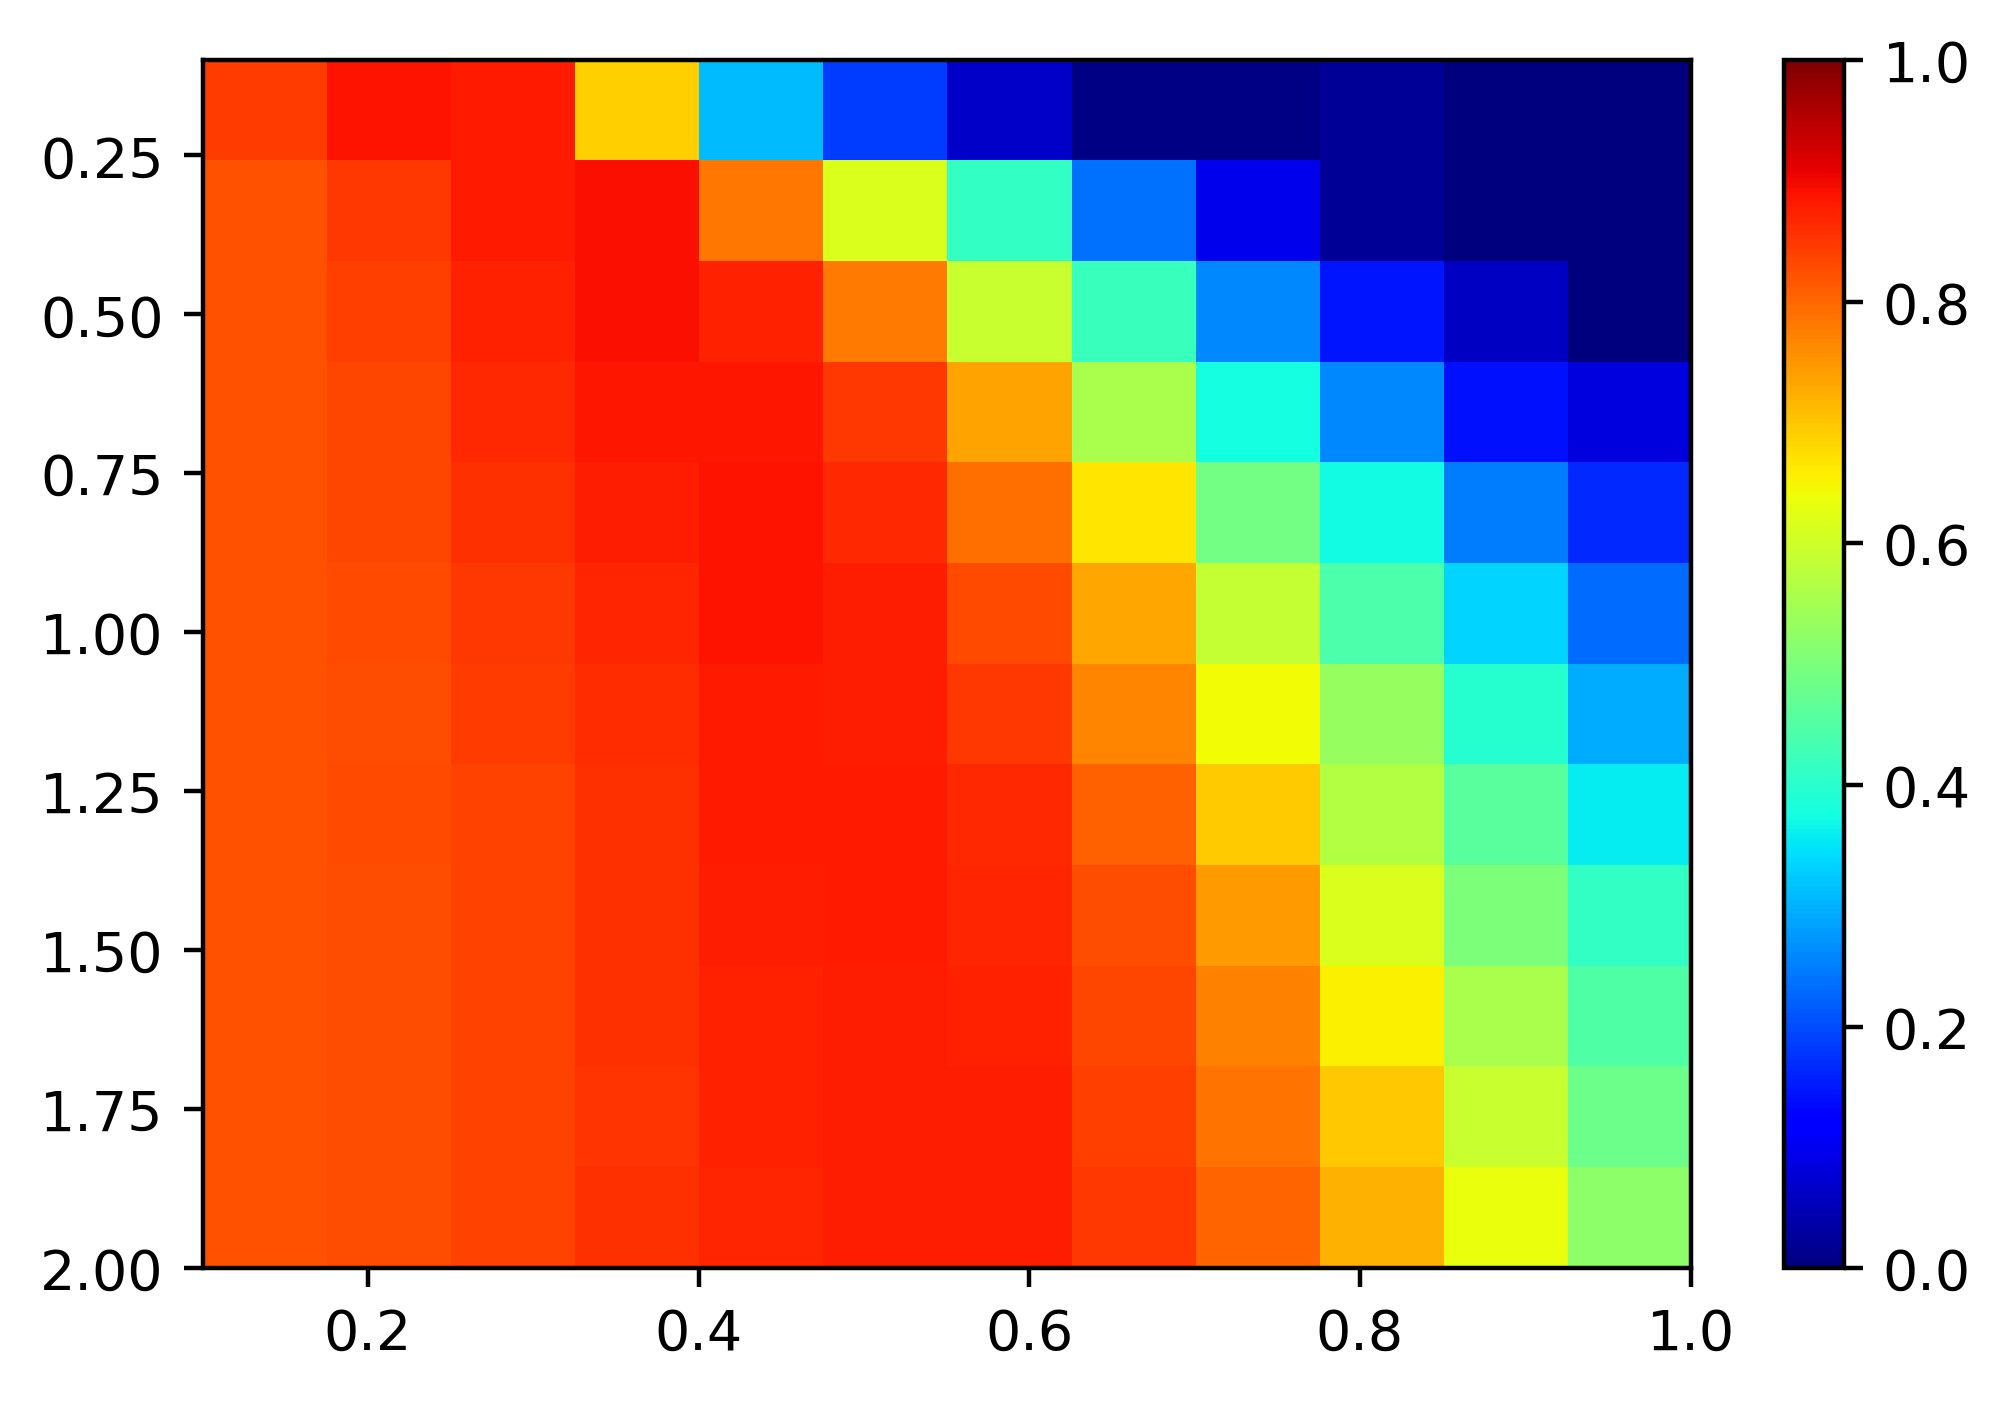

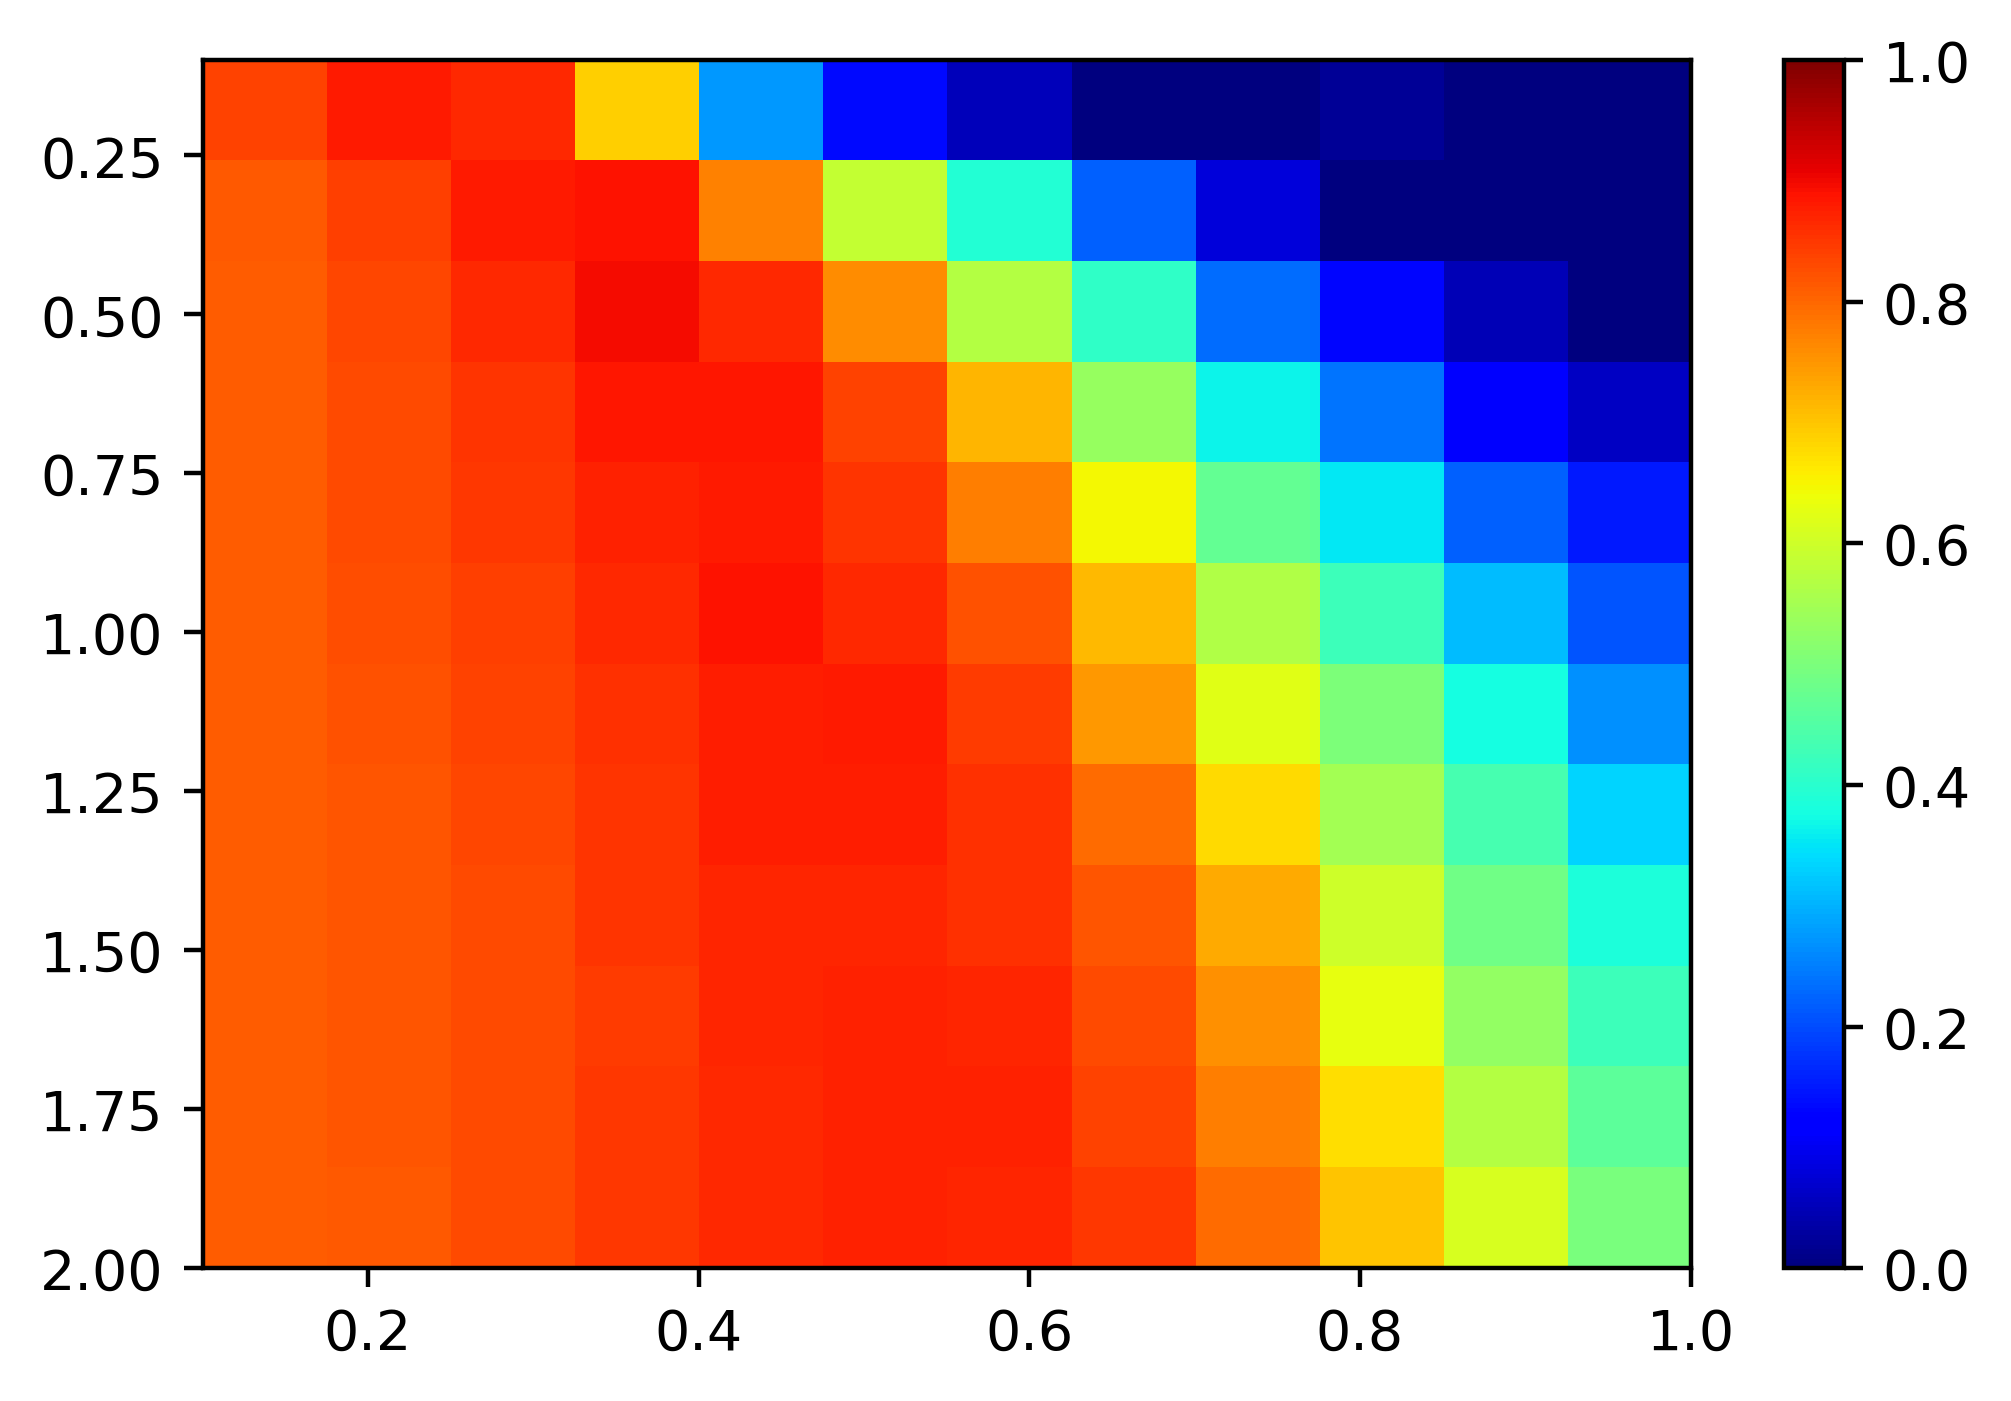

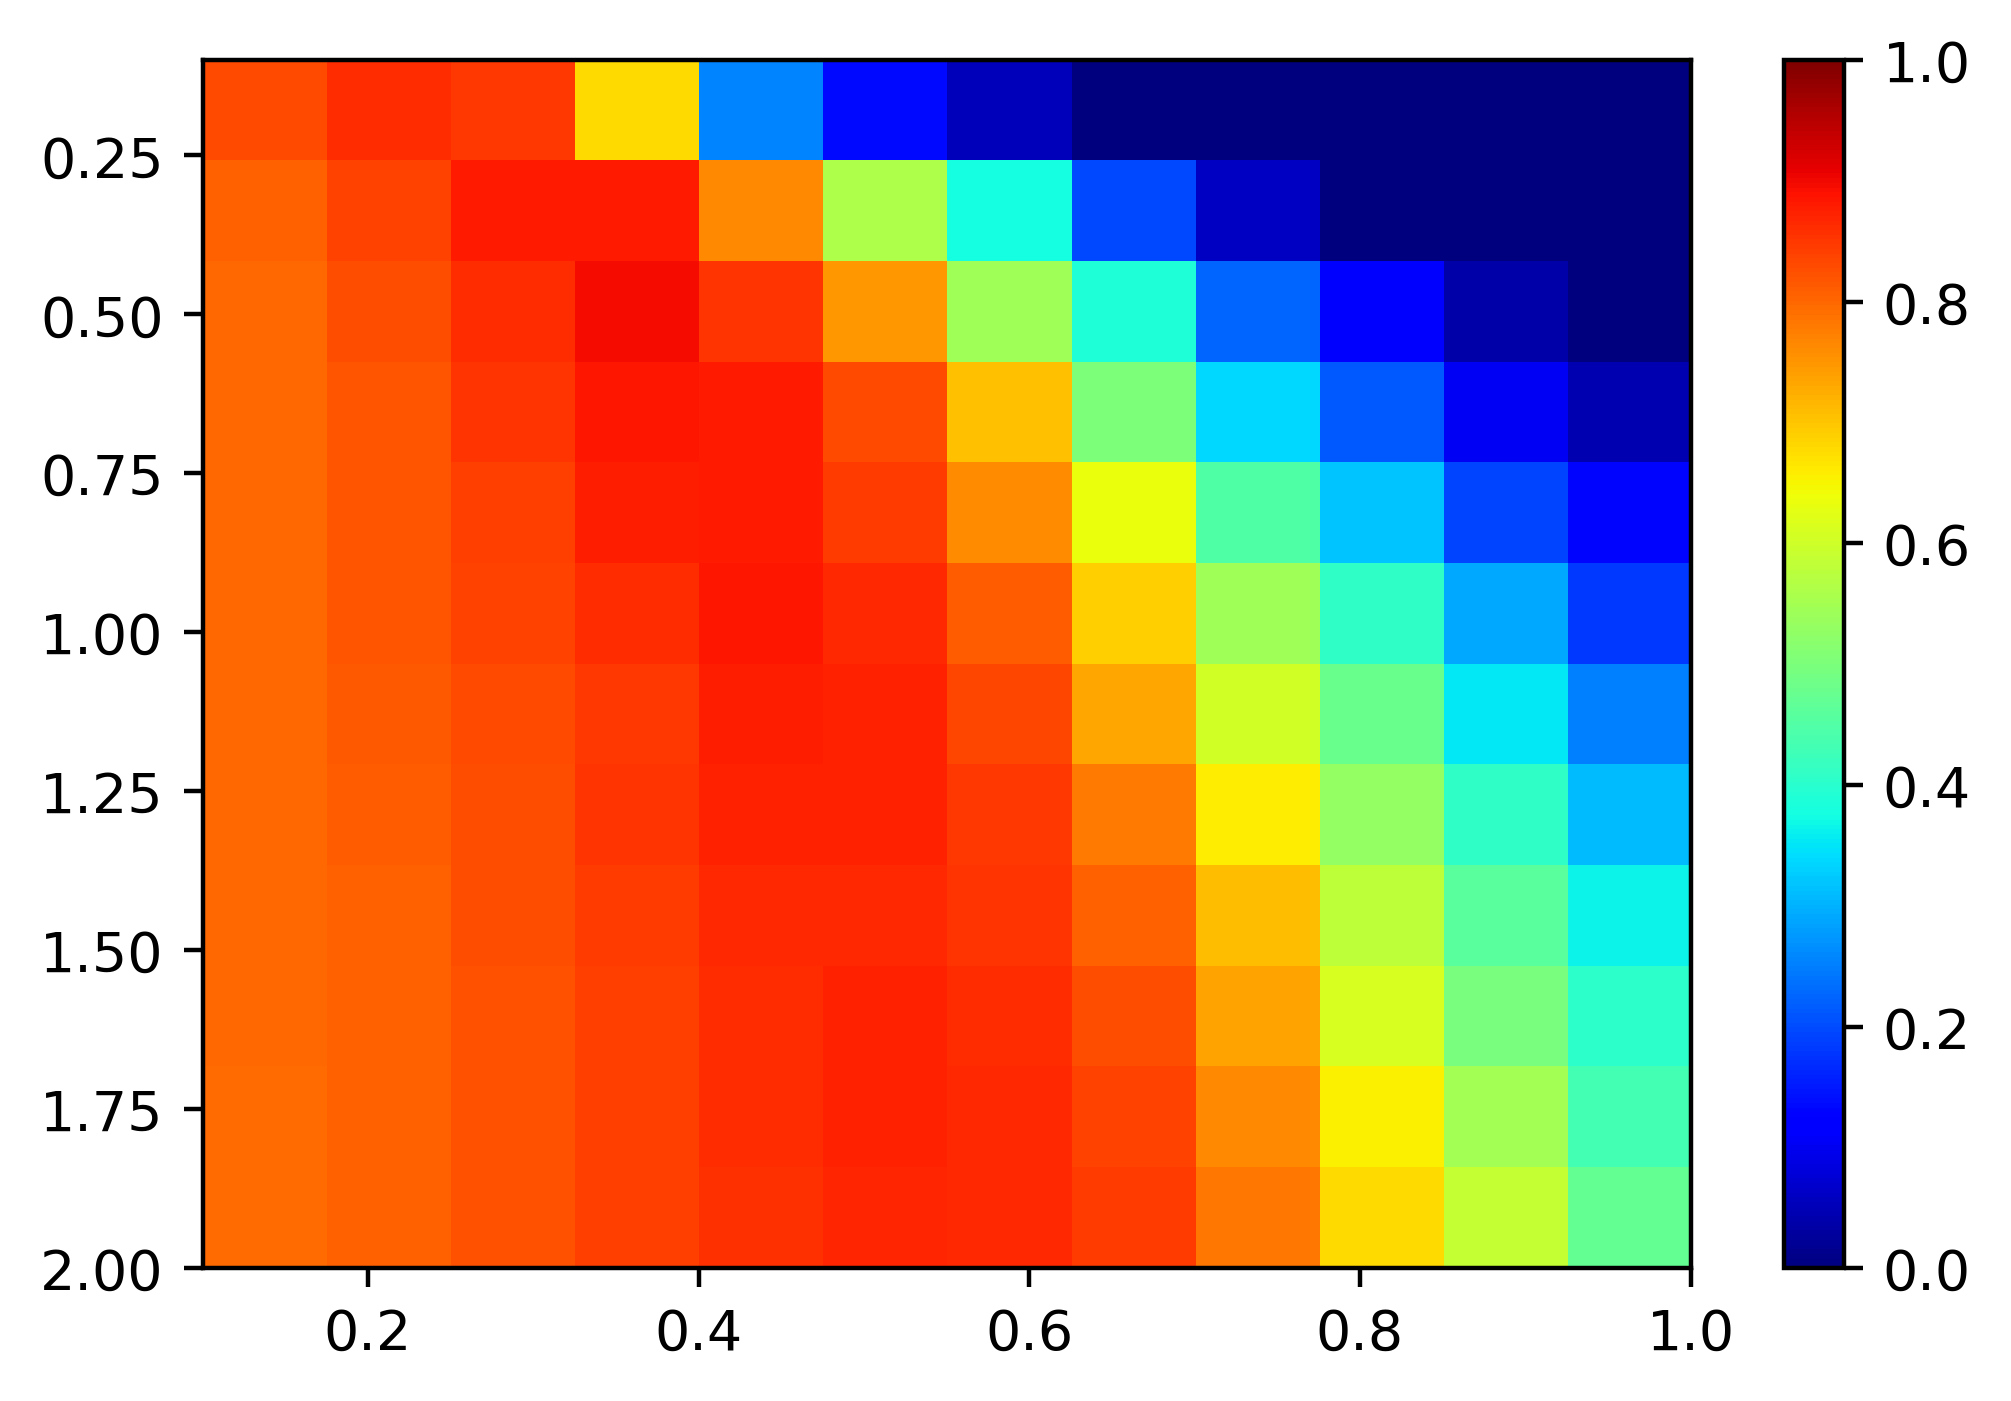

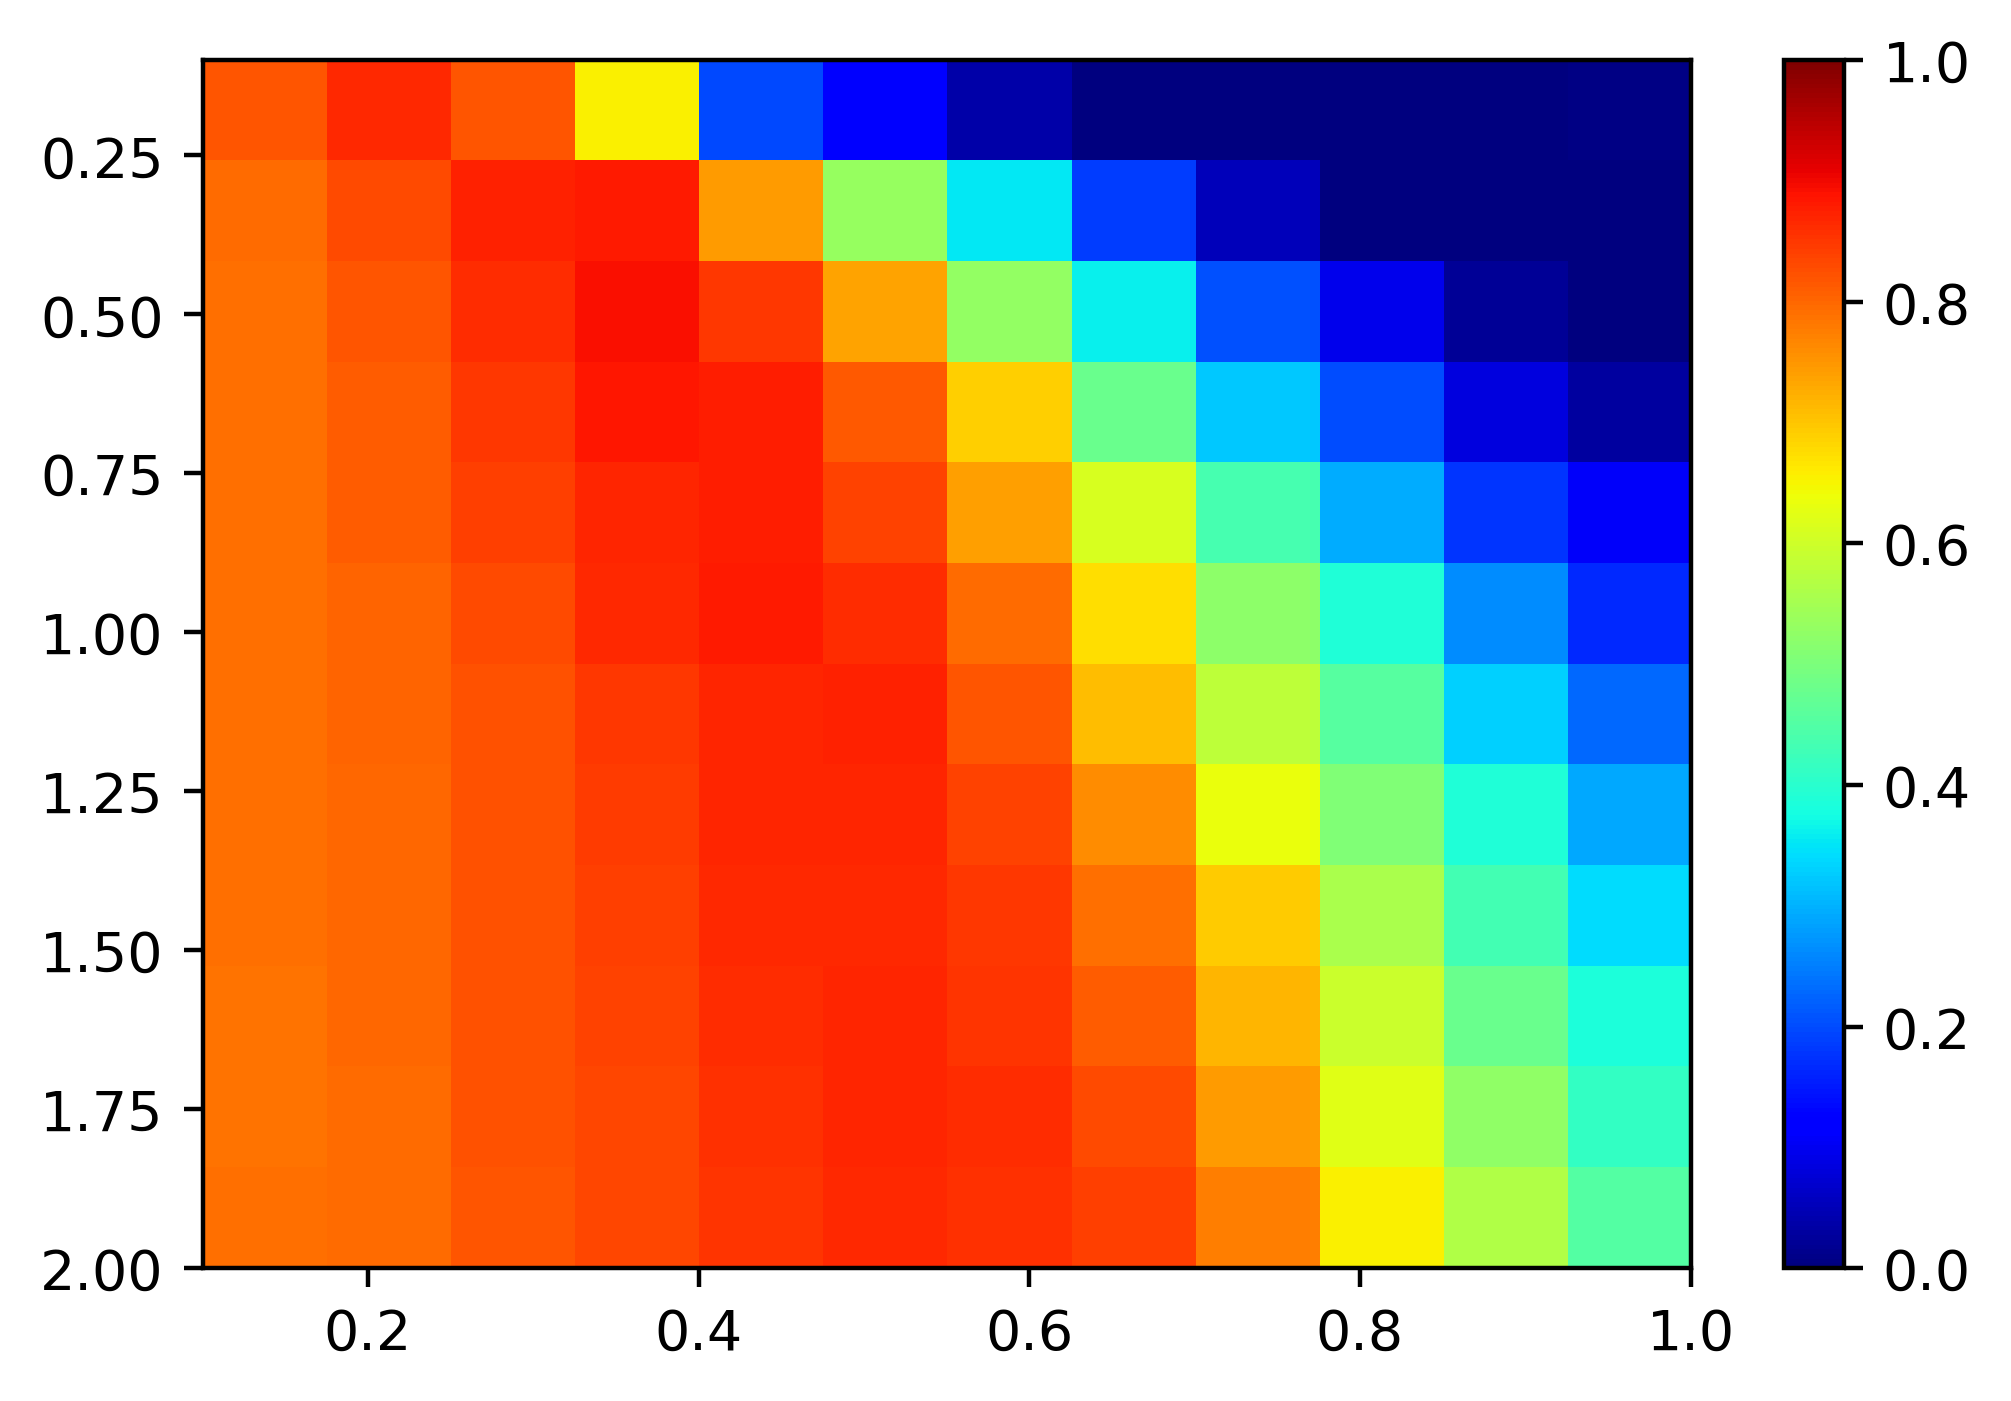

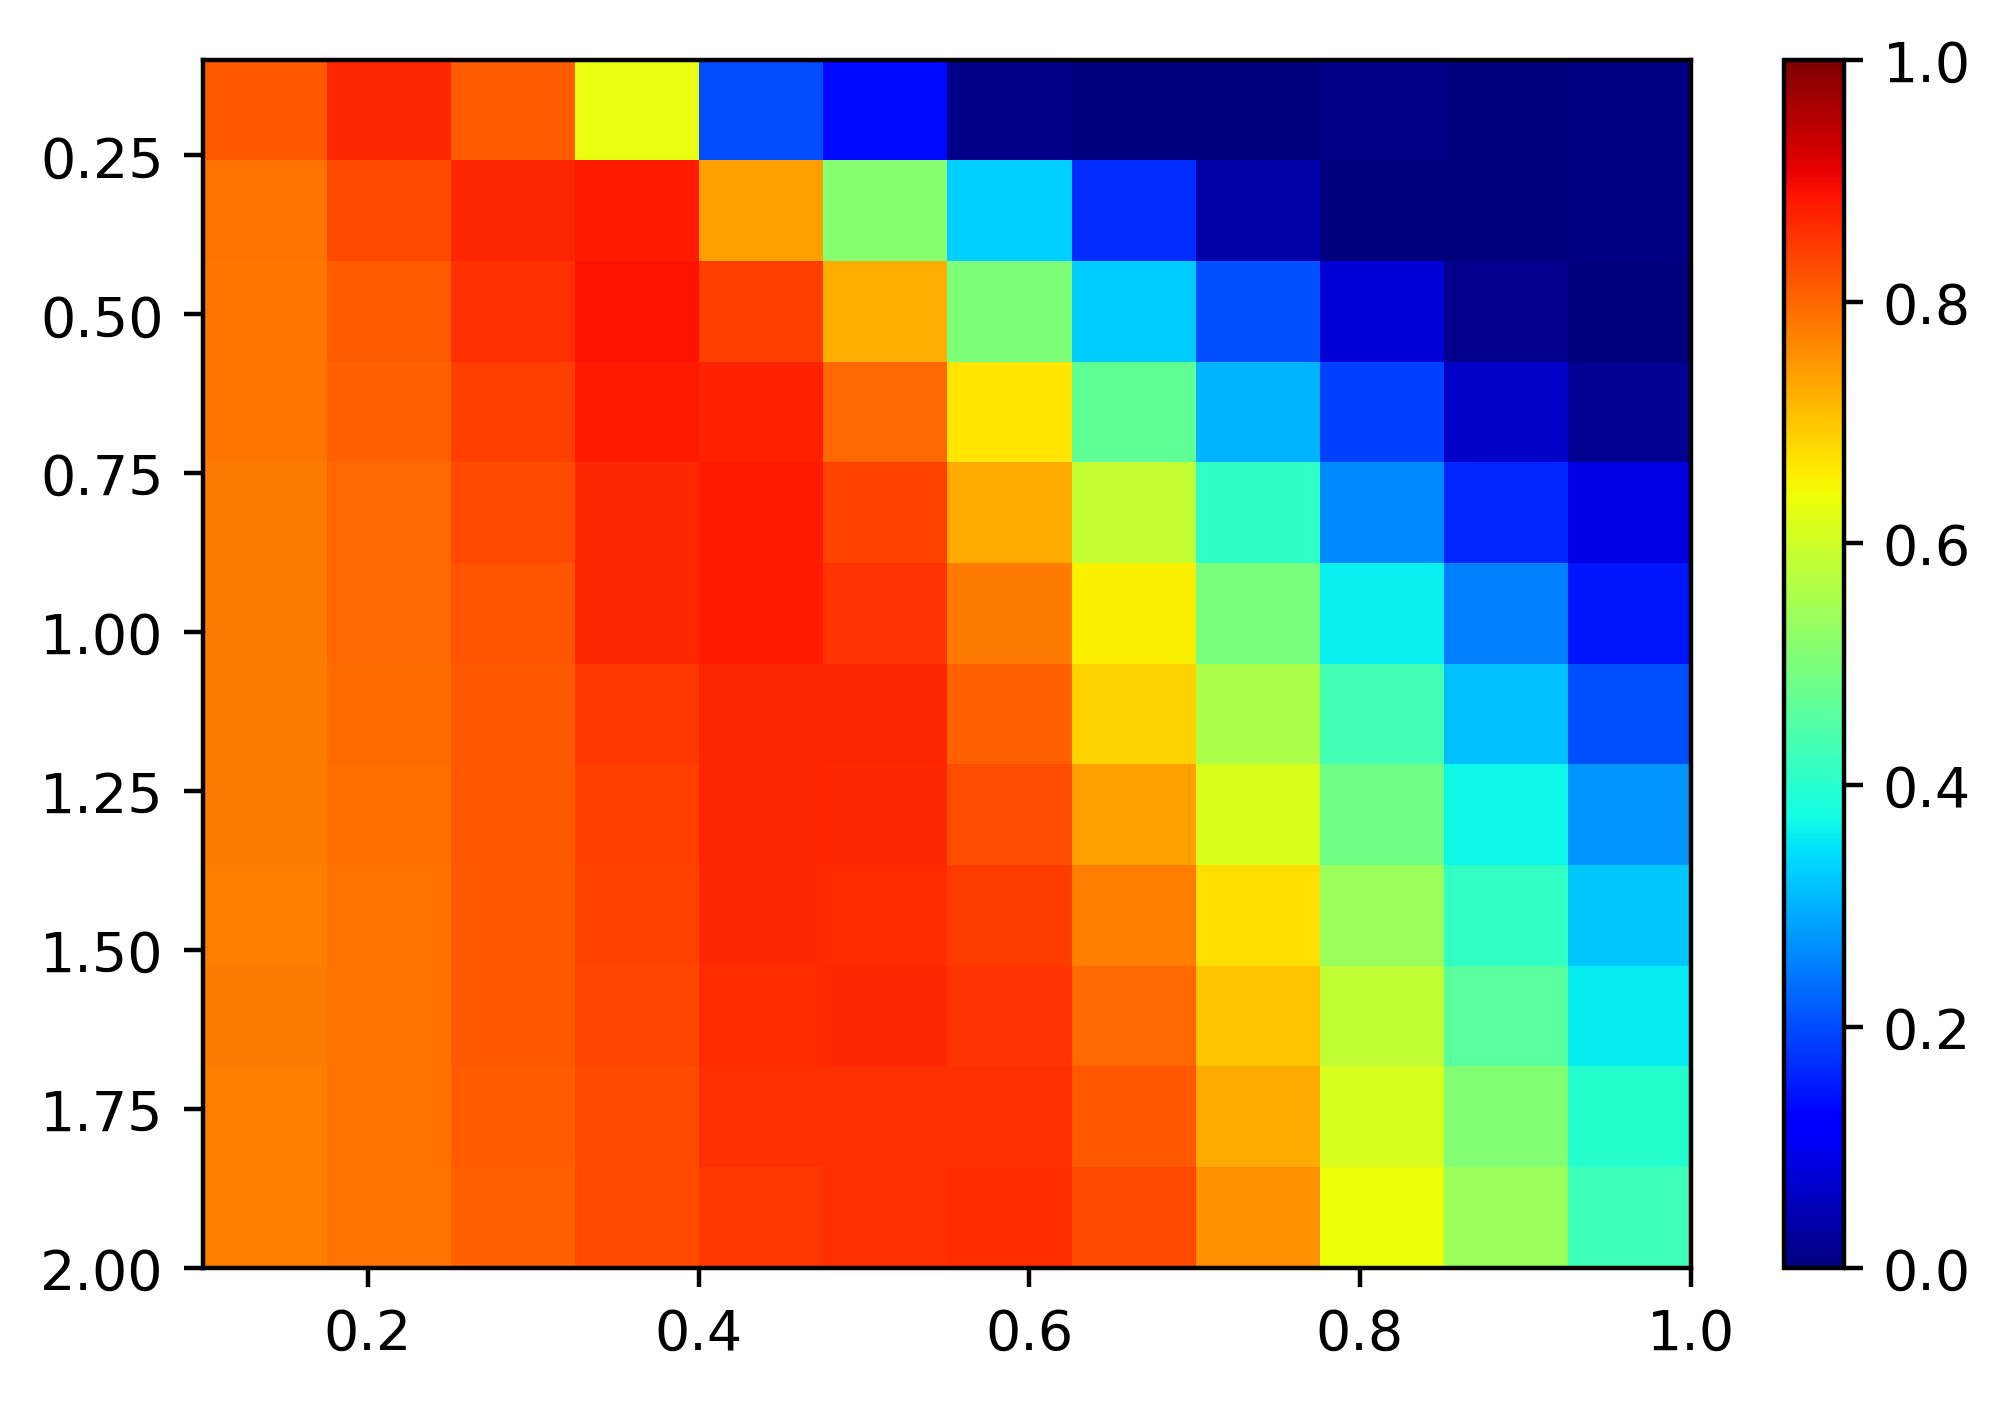

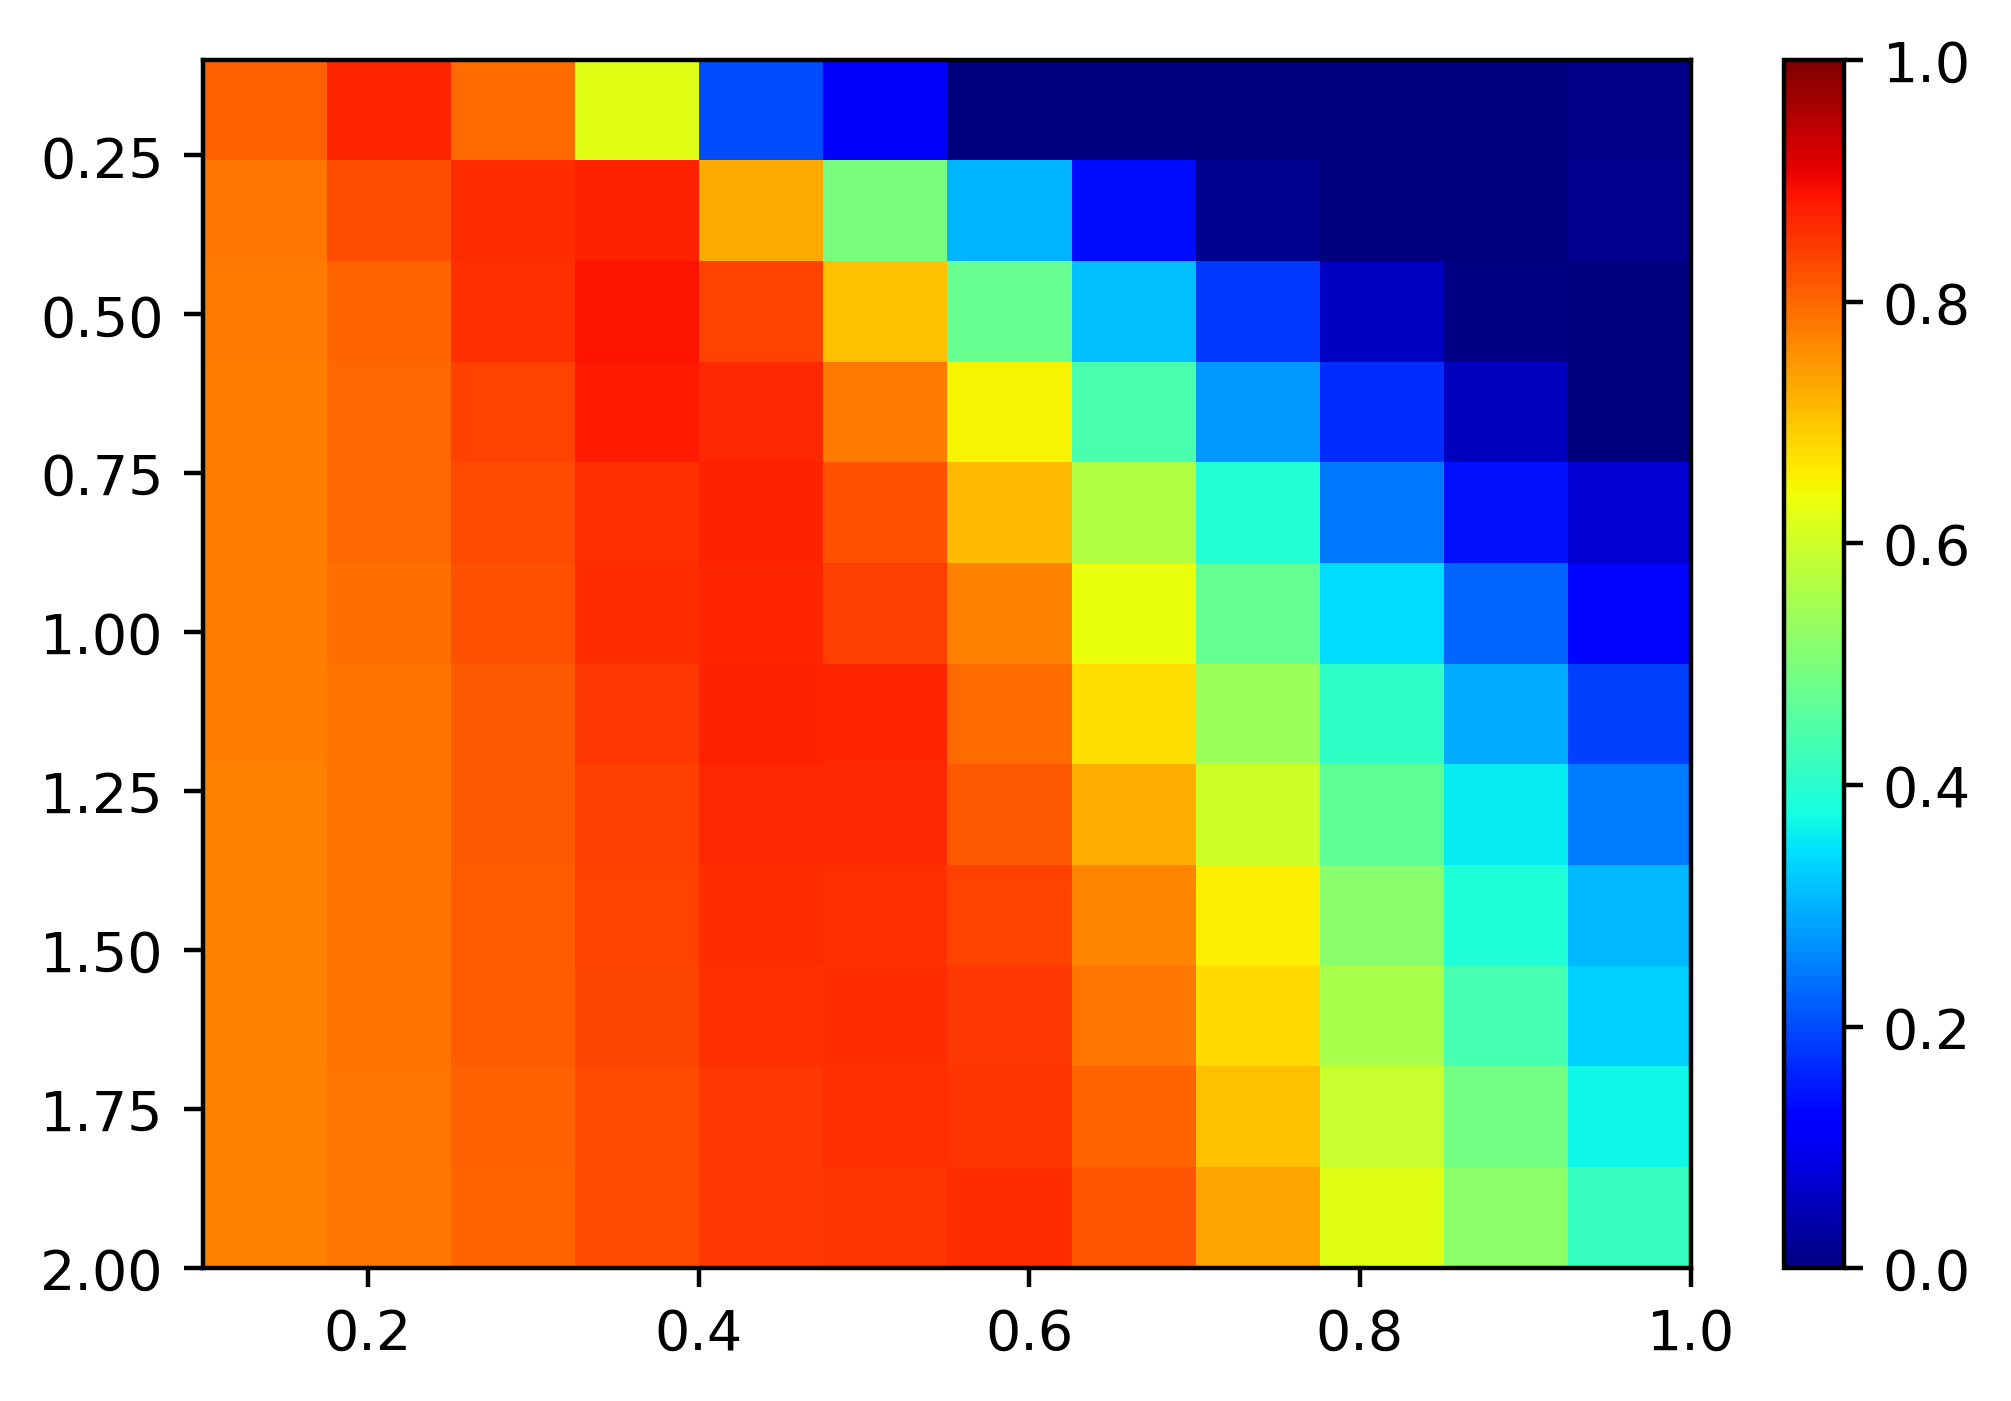

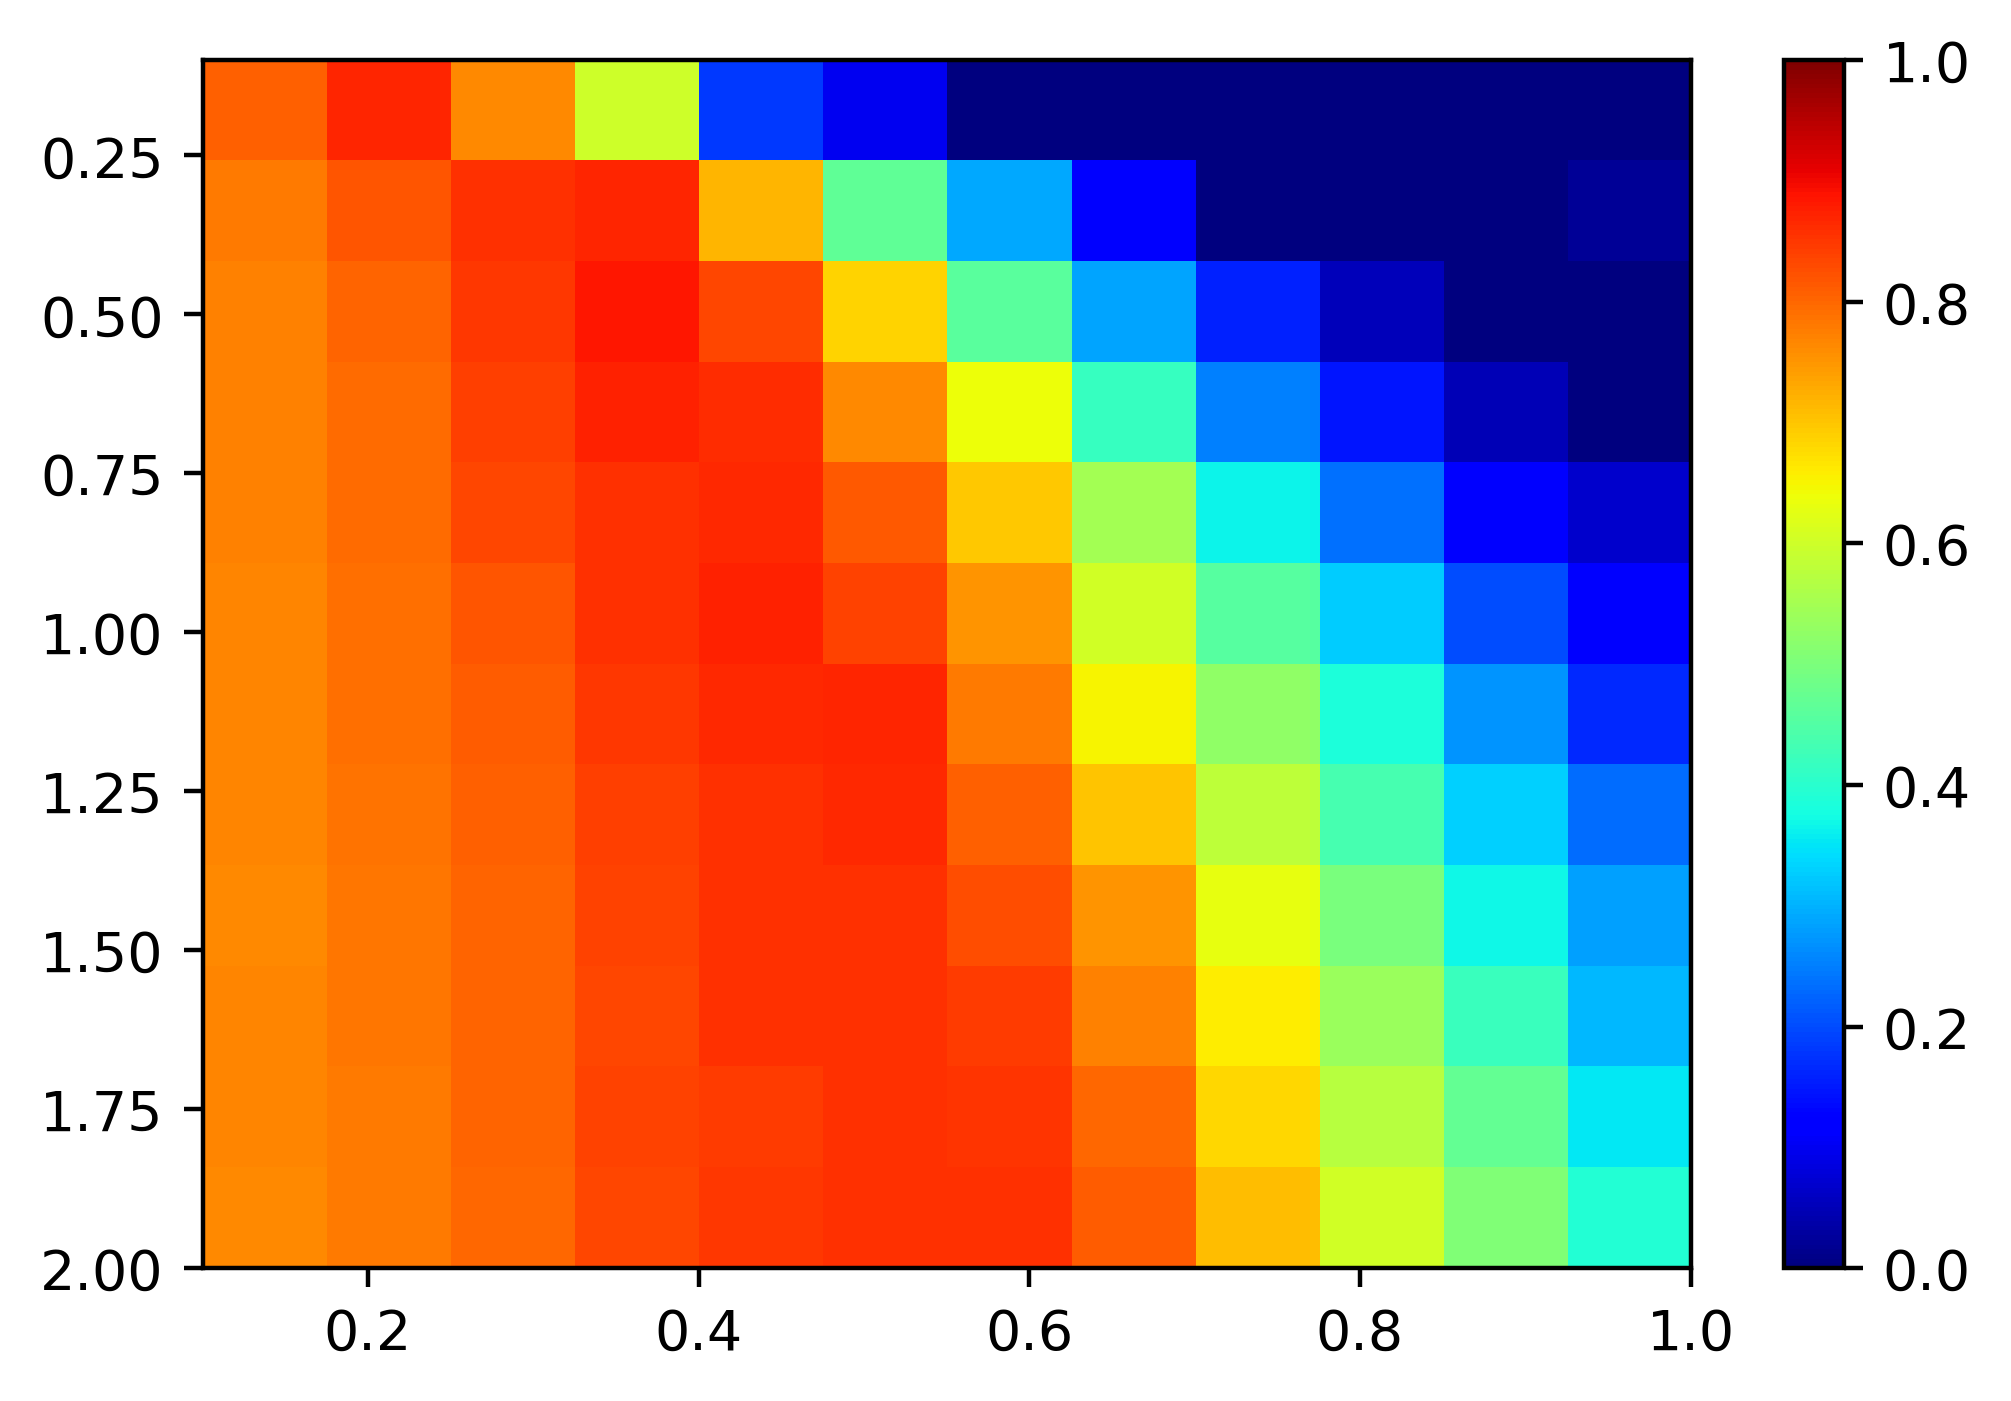

In [161]:
#print( corr[:,:,M-1] )
for i in np.arange(1,M,1):
    #ax = plt.axes()
    fig = plt.figure(dpi=400)
    plt.imshow( corr[:,:,i], cmap="jet", clim=[0,1],  extent =[I2_min, I2_max, I1_max, I1_min], aspect = 'auto' )
    plt.colorbar()
    plt.show()
    fig.savefig('corr/' + str(i) + '.png')
    